# Elements Logiciels pour le Traitement de Données Massives -- Projet
## ENSAE ParisTech 

## Distributed Stochastic Gradient Descent avec Spark Apache

#### Auteurs : Mélanie Finas, Peter Martigny

#### Le jeu de données est un sous-ensemble des données extraites du Netflix Prize : large_nb_ratings.txt and small_nb_ratings.txt qui sont respectivement la base d'apprentissage et de test. Chaque ligne des fichiers test et d'apprentissage a le format suivant : movie_id, user_id, rating.   

### Le but de ce projet est de mettre en place un algorithme de SGD Distribué avec Spark Apache et d'ensuite étudier ses performances en terme de temps de calcul

### Nous avons suivi la méthodologie suivante:

####  - Exploration du jeu de données

####  - Implentation de l'algorithme de Distributed Stochastic Gradient

####  -  Temps de computation de l'algorithme



In [1]:
import os
import sys
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

## Exploration du jeu de données extrait du Netflix prize

In [2]:
## Téléchargements du jeu de données
data_large = pd.read_csv("large_nb_ratings.txt", sep = ',', header = None)
data_small = pd.read_csv("small_nb_ratings.txt", sep = ',', header = None)

## Renommer les colonnes
data_large.columns = ['movie_id', 'user_id', 'rating']
data_small.columns = ['movie_id', 'user_id', 'rating']

## Longueur des bases de données
print('Longueur de la grande base (nombre de ratings) :', data_large.shape[0])
print('Longueur de la faible base (nombre de ratings):', data_small.shape[0])

## Nombre de films différents et d'utilisateurs différents dans la grande base
print('Nombre de film différents dans la grande base:', len(data_large['movie_id'].unique()))
print('Nombre d utilisateurs différents dans la grande base :', len(data_large['user_id'].unique()))
      
## Nombre de films et d'utilisateurs différents dans la faible base
print('Nombre de film différents dans la faible base:', len(data_small['movie_id'].unique()))
print('Nombre d utilisateurs différents dans la faible base :', len(data_small['user_id'].unique()))


Longueur de la grande base (nombre de ratings) : 3255352
Longueur de la faible base (nombre de ratings): 100478
Nombre de film différents dans la grande base: 1821
Nombre d utilisateurs différents dans la grande base : 28978
Nombre de film différents dans la faible base: 1701
Nombre d utilisateurs différents dans la faible base : 27555


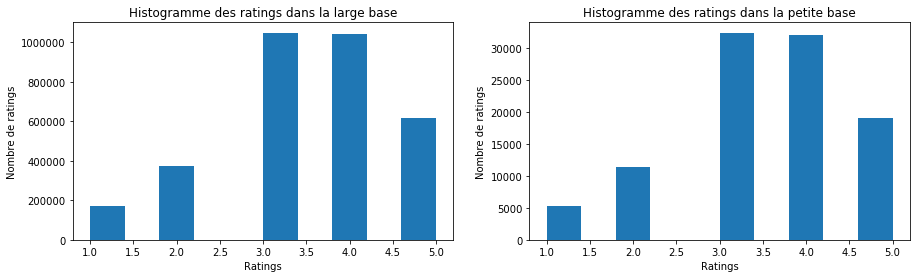

In [3]:
##Representation des ratings dans chacunes des bases

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1,2,1)
plt.hist(data_large['rating'])
plt.xlabel('Ratings')
plt.ylabel('Nombre de ratings')
plt.title('Histogramme des ratings dans la large base')

plt.subplot(1,2,2)
plt.hist(data_small['rating'])
plt.xlabel('Ratings')
plt.ylabel('Nombre de ratings')
plt.title('Histogramme des ratings dans la petite base')
plt.show()

## Implementation de l'algorithme de Distributed Stochastic Gradient Descent

#### Défintions des fonctions utilisées pour coder DSGD :

In [3]:
## Fonction permettant de créer pour chaque ligne de chaque fichier une liste contenant les trois éléments suivants :
## [movie_id, user_id, rating]

def split_file(line):
    line = line.split(",")
    return [int(line[0]), int(line[1]),float(line[2])]

In [4]:
## Fonction permettant de générer aléatoirement les stratas (cf. Rapport Projet)

def random_strata(num_workers):
    return np.random.permutation(num_workers)+1

In [5]:

def assign_block_index (index, num_data, num_workers):
    block_size = num_data / num_workers
    if(num_data % num_workers != 0): block_size = block_size + 1
    return int(np.floor(index / np.ceil(block_size)))+1

In [6]:
## Fonction permettant de faire tourner SGD sur un bloque donné avec en entrée des 
## itérations de (Vblock, (Wblock, Hbloc))

def SGD(keyed_iterable, step_size, num_factors, lbda, mse, n_updates, scale_rating):
    
    iterlist = (keyed_iterable.next())
    Miter = iterlist[1][0]
    Hiter = iterlist[1][1]
    Witer = iterlist[1][2]
    
    Wdict = {}
    Hdict = {}
    
    Wout = {}
    Hout = {}
    
    # iterations parmi H et W et création d'un dictionnaire d'éléments
    for h in Hiter:
        Hdict[h[0]] = h[1]
    
    for w in Witer:
        Wdict[w[0]] = w[1]
    
    # iterations des entrées de M pour calculer la L2-loss
    for m in Miter:
        (i,j,rate) = m
        
        if i not in Wdict:
            Wdict[i] = tuple([i,scale_rating*np.random.rand(1,num_factors).astype(np.float32)])
        if j not in Hdict:
            Hdict[j] = tuple([j,scale_rating*np.random.rand(num_factors,1).astype(np.float32)])

        (Nw, Wprev) = Wdict[i]
        (Nh, Hprev) = Hdict[j]

        delta = -2*(rate - Wprev.dot(Hprev))
        mse += (rate - Wprev.dot(Hprev))**2

        Wnew = Wprev - step_size.value*(delta*Hprev.T + (2.0*lbda.value/Nh)*Wprev)
        Hnew = Hprev - step_size.value*(delta*Wprev.T + (2.0*lbda.value/Nw)*Hprev)

        n_updates += 1

        Wout[i] = tuple([Nw, Wnew])
        Hout[j] = tuple([Nh, Hnew])
        
        return (tuple(['W',Wout.items()]), tuple(['H',Hout.items()]))


### Code Distributed Stochastic Gradient Descent

In [7]:
def DSGD(num_factors, num_workers, max_iter, beta, lbda):
    
    num_workers = int(num_workers)
    max_iter = int(max_iter)
    num_factors = int(num_factors)
    beta = float(beta)
    lbda = sc.broadcast(lbda)
    
    ### Téléchargement des données qui sont contenus en triplets (user, movie, rating)
    # M = sc.textFile("large_nb_ratings.txt").map(split_file).persist()
    M = sc.textFile("small_nb_ratings.txt").map(split_file).persist()
    
    ### Statistiques pour obtenir le nombre de colonnes et lignes ainsi que le rating moyen
    start = time.time()
    num_rows = M.max(lambda x : x[0])[0] +1
    num_cols = M.max(lambda x : x[1])[1] +1
    avg_rating = M.map(lambda x: x[2]).mean()
    
    ## on calcule le rating initial que l'on va affecter pour intitaliser nos matrices W et H de manière à ce que
    ## le dot product(W0,H0) soit de l'ordre de grandeur du rating moyen
    initial_rating = np.sqrt(avg_rating / num_factors)
    
    tau = 100   
    mse_list = []
    times = []
    
    ## on construit des bloques de la matrice M de manière à diviser les lignes et les colonnes en des bloques 
    ## de tailles num_rows/num_cols et num_cols/num_workers
    
    Mblocked = M.keyBy(lambda x: assign_block_index(x[0], num_rows, num_workers)).partitionBy(num_workers)
    
    # on intialise W et H en leur attachant le nombre de valeurs non nulles
    W = M.map(lambda x: tuple([int(x[0]),1])).reduceByKey(lambda x,y : x+y).map(lambda x: tuple([x[0],tuple([x[1],initial_rating*np.random.rand(1, num_factors).astype(np.float32)])])).persist()
    H = M.map(lambda x: tuple([int(x[1]),1])).reduceByKey(lambda x,y : x+y).map(lambda x: tuple([x[0],tuple([x[1],initial_rating*np.random.rand(num_factors,1).astype(np.float32)])])).persist()
        
    for iteration in range(max_iter):
        mse = sc.accumulator(0.0)
        n_updates = sc.accumulator(0.0)
        
        # calcul du step_size
        step_size = sc.broadcast(np.power(tau + iteration, -beta))
        
        # on génére des strata aléatoires
        permutations = random_strata(num_workers)
        
        # on ne garde les données de la matrice correspondant au block définis par le strata
        Mfilt = Mblocked.filter(lambda x: permutations[x[0]-1]==assign_block_index(x[1][1],num_cols,num_workers)).persist()
        
        # on retrouve les blocks W et H correspondant en utilisant le nombre de bloques comme clé
        Hblocked = H.keyBy(lambda x: permutations[assign_block_index(x[0], num_rows, num_workers)-1])
        Wblocked = W.keyBy(lambda x: assign_block_index(x[0], num_rows, num_workers))
        
        #on regroupe les RDDs ensemble
        groupRDD = Mfilt.groupWith(Hblocked, Wblocked).partitionBy(num_workers)
        Mfilt.unpersist()
        
        #on applique SGD sur chaque bloque
        WH = groupRDD.mapPartitions(lambda x: SGD(x, step_size, num_factors,lbda, mse, n_updates,scale_rating)).reduceByKey(lambda x,y: x+y).persist()
    
        W = WH.filter(lambda x: x[0]=='W').flatMap(lambda x: x[1]).persist()
        H = WH.filter(lambda x: x[0]=='H').flatMap(lambda x: x[1]).persist()
        
        times.append(time.time()-start)
        
    print(times)

## Présentation des résultats

#### 1. Sur la large base

In [15]:
l1 = DSGD(100, 2, 1000, 10, 0.1)

[28.77024555206299, 29.102030277252197, 29.418132543563843, 29.753384351730347, 30.053305864334106, 30.37439799308777, 30.659680366516113, 30.9602210521698, 31.292009115219116, 31.592952728271484, 31.877825498580933, 32.16281533241272, 32.463361501693726, 32.77984428405762, 33.09629249572754, 33.42796587944031, 33.712485551834106, 33.99779987335205, 34.3136522769928, 34.63000798225403, 34.93087029457092, 35.23136043548584, 35.516223430633545, 35.83290195465088, 36.13386082649231, 36.45027732849121, 36.75114822387695, 37.036003828048706, 37.37181544303894, 37.651758432388306, 37.95200848579407, 38.23732781410217, 38.522643089294434, 38.83921933174133, 39.13965630531311, 39.4764928817749, 39.75507473945618, 40.071877002716064, 40.39347839355469, 40.6935715675354, 40.8245735168457, 41.07525634765625, 41.35663437843323, 41.67384099960327, 41.95818376541138, 42.28026628494263, 42.558589696884155, 42.843260765075684, 43.159337282180786, 43.444294929504395, 43.744837522506714, 44.045400619506

In [16]:
##on augmente le nombre de workers
l2 = DSGD(100, 4, 1000, 10, 0.1)
## Légère diminution du temps de computation

[27.27337384223938, 27.574085474014282, 27.72127938270569, 27.858511686325073, 27.97440528869629, 28.089841842651367, 28.190241813659668, 28.305681467056274, 28.439769744873047, 28.544076681137085, 28.67475438117981, 28.7906813621521, 28.921773195266724, 29.059463500976562, 29.17517614364624, 29.290711879730225, 29.40621566772461, 29.521708250045776, 29.64325499534607, 29.77464008331299, 29.890207052230835, 30.005674839019775, 30.121353149414062, 30.25860357284546, 30.374573469161987, 30.490098237991333, 30.605573177337646, 30.72109627723694, 30.8426570892334, 30.958216428756714, 31.07376194000244, 31.174102783203125, 31.290053844451904, 31.425698041915894, 31.543667793273926, 31.67493724822998, 31.790634155273438, 31.90654230117798, 32.02237820625305, 32.14418601989746, 32.26030874252319, 32.37628388404846, 32.49220514297485, 32.623502254486084, 32.74565243721008, 32.86088514328003, 32.976332664489746, 33.07667350769043, 33.207457542419434, 33.3233916759491, 33.44516158103943, 33.5611

In [17]:
## on diminue le nombre de facteurs latents
l3 = DSGD(10, 4, 1000, 10, 0.1)
## faible diminution du temps de computation

[26.808698892593384, 26.990194082260132, 27.21222186088562, 27.390955924987793, 27.575982809066772, 27.776395082473755, 27.94549560546875, 28.092321157455444, 28.214744329452515, 28.33069109916687, 28.44588828086853, 28.54614233970642, 28.677709102630615, 28.793354749679565, 28.930629014968872, 29.046184062957764, 29.161927700042725, 29.277358770370483, 29.39336109161377, 29.51516032218933, 29.630802392959595, 29.762863397598267, 29.89396023750305, 29.99432921409607, 30.11632490158081, 30.23204278945923, 30.34764289855957, 30.47923755645752, 30.595205307006836, 30.717248916625977, 30.83298349380493, 30.948896408081055, 31.079983234405518, 31.179809093475342, 31.28023910522461, 31.395753383636475, 31.517629146575928, 31.633487939834595, 31.749062061309814, 31.849292278289795, 31.964871883392334, 32.064861536026, 32.18031859397888, 32.280539751052856, 32.39612650871277, 32.51780128479004, 32.63405799865723, 32.74909996986389, 32.8489887714386, 32.96457362174988, 33.08019137382507, 33.180

In [18]:
l4 = DSGD(1000, 4, 1000, 10, 0.1)
## augmentation du temps de computations en augmentant les facteurs latents

[25.7486515045166, 26.065138578414917, 26.424423217773438, 26.719655990600586, 27.02036738395691, 27.337013006210327, 27.637969255447388, 27.969688892364502, 28.270659685134888, 28.571572065353394, 28.872458457946777, 29.16290545463562, 29.49473738670349, 29.773985624313354, 30.07493567466736, 30.39760398864746, 30.694011926651, 30.99941897392273, 31.300365924835205, 31.600974559783936, 31.879273653030396, 32.180195331573486, 32.48111438751221, 32.78172779083252, 33.06686091423035, 33.40427613258362, 33.70470976829529, 34.00592350959778, 34.306411266326904, 34.60681700706482, 34.88611960411072, 35.17052626609802, 35.5037784576416, 35.787089109420776, 36.071879386901855, 36.38836216926575, 36.67356300354004, 36.99010920524597, 37.27531123161316, 37.56019639968872, 37.86019325256348, 38.145516872406006, 38.46212816238403, 38.76258707046509, 39.04785418510437, 39.363834619522095, 39.64819669723511, 39.98038125038147, 40.26546788215637, 40.55043005943298, 40.85127282142639, 41.136054277420

In [11]:
l4 = DSGD(10000, 4, 1000, 10, 0.1)
## augmentation du temps de computations en augmentant les facteurs latents

[26.756000995635986, 27.155443906784058, 27.54070019721985, 27.892142295837402, 28.24053931236267, 28.604093551635742, 28.958019018173218, 29.34272599220276, 29.743130922317505, 30.090111017227173, 30.420926094055176, 30.774497747421265, 31.158791303634644, 31.505720853805542, 31.843103408813477, 32.189589977264404, 32.52041959762573, 32.90912961959839, 33.30416750907898, 33.64153242111206, 33.97291612625122, 34.3193736076355, 34.703656911849976, 35.041491985321045, 35.387998819351196, 35.71930122375488, 36.04139518737793, 36.25694441795349, 36.64068102836609, 36.97259569168091, 37.3034303188324, 37.65715026855469, 38.035890102386475, 38.3723258972168, 38.703155517578125, 39.04005980491638, 39.37139081954956, 39.75567960739136, 40.139936208724976, 40.4868905544281, 40.80256724357605, 41.15618562698364, 41.51875019073486, 41.87157726287842, 42.20241355895996, 42.53932070732117, 42.87585234642029, 43.25568413734436, 43.637932777404785, 43.97076892852783, 44.30259561538696, 44.63999104499

1000


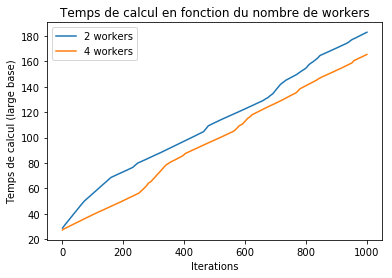

In [13]:
### Temps de calcul en fonction du nombre de workers (2 ou 4) pour la large base

list_iter=[i for i in range(1,1001)]
print(len(list_iter))
l1 = [28.77024555206299, 29.102030277252197, 29.418132543563843, 29.753384351730347, 30.053305864334106, 30.37439799308777, 30.659680366516113, 30.9602210521698, 31.292009115219116, 31.592952728271484, 31.877825498580933, 32.16281533241272, 32.463361501693726, 32.77984428405762, 33.09629249572754, 33.42796587944031, 33.712485551834106, 33.99779987335205, 34.3136522769928, 34.63000798225403, 34.93087029457092, 35.23136043548584, 35.516223430633545, 35.83290195465088, 36.13386082649231, 36.45027732849121, 36.75114822387695, 37.036003828048706, 37.37181544303894, 37.651758432388306, 37.95200848579407, 38.23732781410217, 38.522643089294434, 38.83921933174133, 39.13965630531311, 39.4764928817749, 39.75507473945618, 40.071877002716064, 40.39347839355469, 40.6935715675354, 40.8245735168457, 41.07525634765625, 41.35663437843323, 41.67384099960327, 41.95818376541138, 42.28026628494263, 42.558589696884155, 42.843260765075684, 43.159337282180786, 43.444294929504395, 43.744837522506714, 44.045400619506836, 44.346280574798584, 44.66245985031128, 44.962968826293945, 45.30110263824463, 45.58638548851013, 45.880815744400024, 46.18690729141235, 46.4659788608551, 46.751280784606934, 47.05144286155701, 47.33678698539734, 47.65330266952515, 47.93818259239197, 48.238221168518066, 48.52356004714966, 48.824503660202026, 49.15658688545227, 49.44147849082947, 49.72672963142395, 49.99550485610962, 50.11484909057617, 50.315547704696655, 50.53178358078003, 50.747191429138184, 50.96298408508301, 51.163390159606934, 51.378910779953, 51.5945029258728, 51.81647610664368, 52.016642570495605, 52.21759605407715, 52.433663845062256, 52.649449586868286, 52.880436182022095, 53.09628939628601, 53.317312717437744, 53.53433346748352, 53.73497176170349, 53.93505334854126, 54.13523530960083, 54.35101270675659, 54.58283352851868, 54.78341770172119, 54.999634742736816, 55.20444178581238, 55.42221450805664, 55.63762927055359, 55.85356163978577, 56.054195165634155, 56.254117488861084, 56.45432376861572, 56.68562150001526, 56.901443004608154, 57.123006105422974, 57.32322287559509, 57.52301597595215, 57.73876237869263, 57.954694986343384, 58.17073440551758, 58.370749950408936, 58.57133603096008, 58.80273103713989, 59.01925039291382, 59.24113988876343, 59.457059144973755, 59.657504081726074, 59.88933324813843, 60.08922290802002, 60.305378437042236, 60.505354166030884, 60.72767424583435, 60.959145069122314, 61.15907049179077, 61.37454891204834, 61.59026503562927, 61.79081964492798, 62.02866458892822, 62.22917413711548, 62.429420471191406, 62.628838777542114, 62.845048904418945, 63.061009645462036, 63.277270555496216, 63.50862908363342, 63.70843768119812, 63.90880227088928, 64.14690065383911, 64.34719443321228, 64.56325626373291, 64.76346826553345, 64.96409869194031, 65.19549989700317, 65.3961501121521, 65.63371157646179, 65.83337807655334, 66.04968070983887, 66.2660117149353, 66.46545457839966, 66.68147540092468, 66.88166427612305, 67.09743070602417, 67.31320858001709, 67.52909135818481, 67.75104761123657, 67.95141553878784, 68.16720199584961, 68.38358902931213, 68.58933353424072, 68.7054545879364, 68.81584310531616, 68.93752837181091, 69.03746247291565, 69.15309047698975, 69.26857948303223, 69.38430428504944, 69.50021600723267, 69.61612939834595, 69.71605730056763, 69.83551096916199, 69.93802785873413, 70.0379707813263, 70.15361785888672, 70.26913785934448, 70.38459014892578, 70.50058102607727, 70.6160626411438, 70.71634340286255, 70.83231616020203, 70.93873453140259, 71.03901648521423, 71.15461301803589, 71.25481414794922, 71.37026119232178, 71.47039699554443, 71.58597421646118, 71.68596386909485, 71.80150508880615, 71.9171838760376, 72.01714158058167, 72.13314199447632, 72.2340714931488, 72.33866930007935, 72.45453810691833, 72.57007503509521, 72.67456459999084, 72.78568649291992, 72.90121674537659, 73.00184440612793, 73.11731481552124, 73.21717309951782, 73.33869624137878, 73.4547712802887, 73.55458354949951, 73.67031526565552, 73.78610491752625, 73.90204071998596, 74.001708984375, 74.117267370224, 74.21714329719543, 74.33506083488464, 74.45474553108215, 74.58588194847107, 74.68584156036377, 74.78588533401489, 74.9014458656311, 75.01735734939575, 75.13436079025269, 75.23922228813171, 75.3392596244812, 75.43923735618591, 75.55497074127197, 75.67093396186829, 75.78688478469849, 75.90198636054993, 76.0022804737091, 76.11780714988708, 76.21762537956238, 76.33914756774902, 76.43902659416199, 76.6399736404419, 76.83996367454529, 77.07124280929565, 77.2713987827301, 77.48769092559814, 77.69251298904419, 77.90337896347046, 78.11926937103271, 78.34155535697937, 78.55826187133789, 78.73727607727051, 78.95756983757019, 79.17342472076416, 79.38892602920532, 79.62032556533813, 79.8422167301178, 79.942631483078, 80.0424108505249, 80.15852451324463, 80.27428984642029, 80.374276638031, 80.49020743370056, 80.59039068222046, 80.69024682044983, 80.80573391914368, 80.92166209220886, 81.02194547653198, 81.12183284759521, 81.22174310684204, 81.34359979629517, 81.44377827644348, 81.54427242279053, 81.65987539291382, 81.7597017288208, 81.87560248374939, 81.99120736122131, 82.091561794281, 82.207510471344, 82.30733108520508, 82.40770483016968, 82.50760436058044, 82.62323641777039, 82.74451017379761, 82.84492087364197, 82.96063756942749, 83.06043004989624, 83.17587089538574, 83.30707478523254, 83.42250370979309, 83.54399824142456, 83.64478158950806, 83.76052927970886, 83.86083936691284, 83.97637677192688, 84.10741591453552, 84.20788431167603, 84.30805730819702, 84.42402529716492, 84.52348852157593, 84.6449408531189, 84.74487161636353, 84.86058259010315, 84.9607183933258, 85.07644438743591, 85.2079541683197, 85.32359504699707, 85.42340731620789, 85.53949427604675, 85.64536547660828, 85.7458221912384, 85.86168599128723, 85.96157455444336, 86.07709980010986, 86.19300866127014, 86.32456851005554, 86.42444944381714, 86.5463969707489, 86.64632225036621, 86.76221227645874, 86.86212539672852, 86.97781014442444, 87.07763624191284, 87.17846488952637, 87.29441022872925, 87.41030311584473, 87.51013398170471, 87.61055541038513, 87.73083186149597, 87.84537720680237, 87.94792294502258, 88.06355547904968, 88.16377806663513, 88.27969217300415, 88.37964248657227, 88.49556565284729, 88.61109900474548, 88.71113681793213, 88.82673192024231, 88.94328880310059, 89.04821228981018, 89.16426801681519, 89.27990365028381, 89.37996435165405, 89.49570488929749, 89.61153984069824, 89.745112657547, 89.86505484580994, 89.98064708709717, 90.09615278244019, 90.2272458076477, 90.34622573852539, 90.44954419136047, 90.56536817550659, 90.68082189559937, 90.79698324203491, 90.92813491821289, 91.04881525039673, 91.15013790130615, 91.2817735671997, 91.41301560401917, 91.513352394104, 91.62863945960999, 91.75014519691467, 91.86611366271973, 91.99722218513489, 92.12855362892151, 92.25022101402283, 92.35019659996033, 92.46621537208557, 92.59729313850403, 92.71802949905396, 92.8292191028595, 92.95116710662842, 93.05106663703918, 93.18285799026489, 93.29838037490845, 93.41401433944702, 93.52993249893188, 93.62984228134155, 93.75138759613037, 93.86700510978699, 93.98295426368713, 94.09866166114807, 94.21411371231079, 94.33002305030823, 94.45249366760254, 94.56840515136719, 94.66869974136353, 94.78451919555664, 94.91587543487549, 95.03150486946106, 95.14997029304504, 95.25401997566223, 95.36946558952332, 95.50149083137512, 95.6013662815094, 95.71684432029724, 95.83285450935364, 95.9488251209259, 96.05512547492981, 96.17128944396973, 96.28684329986572, 96.4028091430664, 96.51871991157532, 96.65105319023132, 96.75657749176025, 96.87193083763123, 96.98787117004395, 97.10336446762085, 97.2189633846283, 97.35287022590637, 97.47286438941956, 97.58877158164978, 97.70919823646545, 97.8362488746643, 97.95477604866028, 98.05792450904846, 98.17405915260315, 98.2898919582367, 98.40538811683655, 98.53663396835327, 98.6583514213562, 98.77411007881165, 98.88995790481567, 99.00540590286255, 99.1215329170227, 99.23739457130432, 99.35798072814941, 99.45882415771484, 99.60637640953064, 99.72158670425415, 99.82152724266052, 99.92159724235535, 100.03703379631042, 100.15854907035828, 100.27501511573792, 100.39092087745667, 100.50681471824646, 100.60711240768433, 100.73831868171692, 100.83851337432861, 100.9600899219513, 101.0757622718811, 101.1920382976532, 101.32345485687256, 101.43940377235413, 101.53923177719116, 101.69226288795471, 101.8571891784668, 101.9762692451477, 102.09178876876831, 102.2073438167572, 102.307626247406, 102.42360949516296, 102.55624437332153, 102.66063451766968, 102.76105952262878, 102.86136841773987, 102.97671842575073, 103.09224081039429, 103.20795226097107, 103.32366371154785, 103.4235908985138, 103.53900790214539, 103.6605851650238, 103.7766535282135, 103.89252305030823, 104.00813937187195, 104.1081645488739, 104.22371554374695, 104.39284014701843, 104.56141304969788, 104.73971486091614, 104.9608006477356, 105.29342818260193, 105.57798171043396, 105.86239242553711, 106.16259407997131, 106.44092798233032, 106.76176834106445, 107.04127478599548, 107.32633328437805, 107.61126732826233, 107.91100907325745, 108.26192283630371, 108.54194045066833, 108.84157228469849, 109.12589240074158, 109.3414454460144, 109.46336221694946, 109.57917976379395, 109.69476985931396, 109.81076073646545, 109.92665314674377, 110.05820393562317, 110.16430950164795, 110.28003525733948, 110.39587235450745, 110.51141667366028, 110.62703585624695, 110.74269938468933, 110.8594651222229, 110.9643964767456, 111.08048939704895, 111.21209859848022, 111.3271837234497, 111.44313383102417, 111.55988454818726, 111.66520619392395, 111.78121376037598, 111.89681887626648, 112.01228475570679, 112.11261129379272, 112.22805380821228, 112.36566996574402, 112.4816689491272, 112.59764051437378, 112.70149612426758, 112.81275582313538, 112.9440062046051, 113.0658221244812, 113.1658411026001, 113.2817690372467, 113.39731478691101, 113.51280879974365, 113.61314511299133, 113.72906470298767, 113.84499979019165, 113.94467544555664, 114.06691527366638, 114.18283319473267, 114.28286266326904, 114.38317942619324, 114.49872493743896, 114.61422610282898, 114.71406149864197, 114.82960081100464, 114.92977333068848, 115.04531025886536, 115.14563012123108, 115.26522707939148, 115.3667380809784, 115.46716165542603, 115.56746912002563, 115.6990077495575, 115.79888916015625, 115.91436719894409, 116.0147008895874, 116.11501407623291, 116.2306182384491, 116.34629607200623, 116.44627070426941, 116.55156922340393, 116.66778206825256, 116.76787281036377, 116.88351058959961, 116.98343443870544, 117.09894585609436, 117.19922304153442, 117.31517386436462, 117.41505575180054, 117.53098440170288, 117.63080668449402, 117.7350754737854, 117.846932888031, 117.96837997436523, 118.06913471221924, 118.1690285205841, 118.26942157745361, 118.38499546051025, 118.48490858078003, 118.58474683761597, 118.70032334327698, 118.80049419403076, 118.9164183139801, 119.03208470344543, 119.13223886489868, 119.24802088737488, 119.3479573726654, 119.46978306770325, 119.56980419158936, 119.66970324516296, 119.76988911628723, 119.86979460716248, 119.98582625389099, 120.10169529914856, 120.2019567489624, 120.3171615600586, 120.41748046875, 120.53295588493347, 120.6328763961792, 120.74881315231323, 120.84912467002869, 120.94851660728455, 121.07006287574768, 121.18604493141174, 121.28554630279541, 121.40122890472412, 121.501549243927, 121.61752343177795, 121.71738409996033, 121.83334875106812, 121.93299746513367, 122.04866623878479, 122.17013192176819, 122.27050042152405, 122.37030911445618, 122.48627781867981, 122.58639907836914, 122.70630836486816, 122.8176691532135, 122.93323135375977, 123.03311705589294, 123.13298654556274, 123.27068042755127, 123.38659906387329, 123.50165128707886, 123.60196805000305, 123.71737813949585, 123.83284854888916, 123.9485285282135, 124.065358877182, 124.17046809196472, 124.27052211761475, 124.38620018959045, 124.50208258628845, 124.60231876373291, 124.70266199111938, 124.80264067649841, 124.91832494735718, 125.03413128852844, 125.13444018363953, 125.25030040740967, 125.35026359558105, 125.47256565093994, 125.63494300842285, 125.7505292892456, 125.86656665802002, 125.97236609458923, 126.07227516174316, 126.18798351287842, 126.28826713562012, 126.4037754535675, 126.50376987457275, 126.61960077285767, 126.71992063522339, 126.8355495929718, 126.93544006347656, 127.05089378356934, 127.15134119987488, 127.2728419303894, 127.37290501594543, 127.48871660232544, 127.58901786804199, 127.69296002388, 127.80401062965393, 127.9198956489563, 128.03540205955505, 128.1356701850891, 128.25133395195007, 128.35121250152588, 128.47123384475708, 128.5735523700714, 128.67333269119263, 128.78899884223938, 128.90496706962585, 129.02039766311646, 129.12119913101196, 129.2527253627777, 129.37440395355225, 129.59054112434387, 129.805992603302, 129.9902355670929, 130.12137961387634, 130.2727632522583, 130.4059238433838, 130.53716015815735, 130.67036533355713, 130.7902262210846, 130.92137837409973, 131.0524845123291, 131.19007921218872, 131.3218686580658, 131.45304250717163, 131.69048142433167, 131.97515320777893, 132.17534947395325, 132.35407137870789, 132.523010969162, 132.6965353488922, 132.87629628181458, 133.07653880119324, 133.25483584403992, 133.4242227077484, 133.60899758338928, 133.7933428287506, 133.9933316707611, 134.15579199790955, 134.35585570335388, 134.52492499351501, 134.74027609825134, 135.05601358413696, 135.34071826934814, 135.64153718948364, 135.92606139183044, 136.2417652606964, 136.55836653709412, 136.84359216690063, 137.1285378932953, 137.42877864837646, 137.71345233917236, 138.02987432479858, 138.33035016059875, 138.61497974395752, 138.89936637878418, 139.21518778800964, 139.53107905387878, 139.76251745224, 140.06252908706665, 140.34738659858704, 140.63200330734253, 140.9326102733612, 141.21707701683044, 141.50196766853333, 141.76464319229126, 141.98694276809692, 142.2344663143158, 142.403480052948, 142.58825159072876, 142.76649689674377, 142.95082139968872, 143.11948490142822, 143.3038456439972, 143.48794054985046, 143.6662745475769, 143.85056829452515, 144.05119228363037, 144.23556208610535, 144.40431237220764, 144.58838891983032, 144.76654028892517, 144.96626567840576, 145.15063405036926, 145.28797793388367, 145.403822183609, 145.53502678871155, 145.68210291862488, 145.80408024787903, 145.92003107070923, 146.05133724212646, 146.18872237205505, 146.32054591178894, 146.4364845752716, 146.55200338363647, 146.68955969810486, 146.80568885803223, 146.95284223556519, 147.0688192844391, 147.1905562877655, 147.3216996192932, 147.43816685676575, 147.56970286369324, 147.70744705200195, 147.83859276771545, 147.95417833328247, 148.09190464019775, 148.22315573692322, 148.33875036239624, 148.469952583313, 148.59206748008728, 148.7236065864563, 148.85466742515564, 148.9917426109314, 149.10823607444763, 149.23937678337097, 149.37070727348328, 149.49270105361938, 149.62461638450623, 149.7713713645935, 149.99365520477295, 150.14087510108948, 150.32608246803284, 150.49493598937988, 150.65769267082214, 150.82637190818787, 150.99441409111023, 151.1732051372528, 151.34213948249817, 151.51116180419922, 151.68908619880676, 151.84283566474915, 152.01192355155945, 152.1954996585846, 152.35866975784302, 152.52749681472778, 152.69600296020508, 152.89111495018005, 153.02786111831665, 153.14338397979736, 153.24369144439697, 153.37430906295776, 153.55894422531128, 153.72740125656128, 153.89672255516052, 154.02809977531433, 154.19692182540894, 154.39374923706055, 154.54468202590942, 154.71366786956787, 154.99809336662292, 155.29476475715637, 155.59897208213806, 155.89803099632263, 156.1785593032837, 156.46335196495056, 156.80105805397034, 157.10105109214783, 157.3170611858368, 157.50196838378906, 157.68485689163208, 157.86500120162964, 158.06557059288025, 158.25012350082397, 158.41914820671082, 158.6022026538849, 158.78172731399536, 158.96623349189758, 159.11977219581604, 159.25094079971313, 159.36682271957397, 159.50490760803223, 159.70507311820984, 159.88374590873718, 160.0684094429016, 160.25295448303223, 160.43752765655518, 160.62225031852722, 160.80721783638, 161.00092124938965, 161.18555426597595, 161.37016105651855, 161.55480194091797, 161.73901200294495, 161.92378067970276, 162.1070041656494, 162.28665685653687, 162.5094473361969, 162.7875497341156, 163.0880365371704, 163.37256360054016, 163.65766763687134, 163.95844841003418, 164.2427532672882, 164.47444319725037, 164.61176872253418, 164.71174693107605, 164.8280050754547, 164.92785382270813, 165.04381561279297, 165.14392352104187, 165.25989723205566, 165.37543940544128, 165.4912989139557, 165.59139347076416, 165.70968222618103, 165.81308770179749, 165.92945218086243, 166.0293071269989, 166.14483213424683, 166.2604522705078, 166.36032819747925, 166.47587490081787, 166.57616090774536, 166.67601084709167, 166.79195928573608, 166.90784740447998, 167.01417517662048, 167.11419939994812, 167.22984981536865, 167.32963156700134, 167.43035078048706, 167.546284198761, 167.64580941200256, 167.7616581916809, 167.86150407791138, 167.97713255882263, 168.093026638031, 168.212890625, 168.31478548049927, 168.41506910324097, 168.51498699188232, 168.63068509101868, 168.74617886543274, 168.846533536911, 168.96213793754578, 169.0620822906494, 169.17798972129822, 169.29385328292847, 169.41029286384583, 169.5161488056183, 169.61646008491516, 169.73159170150757, 169.83190202713013, 169.94708251953125, 170.06266331672668, 170.17827320098877, 170.2781846523285, 170.39372515678406, 170.49382185935974, 170.61455178260803, 170.7154564857483, 170.83123207092285, 170.9311912059784, 171.04669618606567, 171.1622757911682, 171.27826309204102, 171.39358639717102, 171.51525354385376, 171.61530590057373, 171.73128581047058, 171.83118295669556, 171.94686579704285, 172.0624132156372, 172.1623842716217, 172.2778742313385, 172.39330911636353, 172.5123724937439, 172.61534237861633, 172.7307333946228, 172.84667253494263, 172.946702003479, 173.0626242160797, 173.16247868537903, 173.26277542114258, 173.37854146957397, 173.49402689933777, 173.6116840839386, 173.7159869670868, 173.83184552192688, 173.9320204257965, 174.04773831367493, 174.16356873512268, 174.27947545051575, 174.37932991981506, 174.47933745384216, 174.61648321151733, 174.8321647644043, 175.01666498184204, 175.21769523620605, 175.41790413856506, 175.61753582954407, 175.7804455757141, 175.98026609420776, 176.18087196350098, 176.36524367332458, 176.58147382736206, 176.7505385875702, 176.8655755519867, 176.9967224597931, 177.11870074272156, 177.23427748680115, 177.34994077682495, 177.46540474891663, 177.5813410282135, 177.7014172077179, 177.81884598731995, 177.9344038963318, 178.04996037483215, 178.16565489768982, 178.29685187339783, 178.41930890083313, 178.51908922195435, 178.63530683517456, 178.73511910438538, 178.83502388000488, 178.9661078453064, 179.13545417785645, 179.2510097026825, 179.3669466972351, 179.4824230670929, 179.6150267124176, 179.73588943481445, 179.8515748977661, 179.98282384872437, 180.09860563278198, 180.2175521850586, 180.32054162025452, 180.4518039226532, 180.5518078804016, 180.6672956943512, 180.79838371276855, 180.92083978652954, 181.0368092060089, 181.15255761146545, 181.26800155639648, 181.38389253616333, 181.49938917160034, 181.63658118247986, 181.75294184684753, 181.8684697151184, 181.99954199790955, 182.1218502521515, 182.25342535972595, 182.36934328079224, 182.48439264297485, 182.60014128684998, 182.72185492515564, 182.8375415802002, 182.9535412788391]
l2 = [27.27337384223938, 27.574085474014282, 27.72127938270569, 27.858511686325073, 27.97440528869629, 28.089841842651367, 28.190241813659668, 28.305681467056274, 28.439769744873047, 28.544076681137085, 28.67475438117981, 28.7906813621521, 28.921773195266724, 29.059463500976562, 29.17517614364624, 29.290711879730225, 29.40621566772461, 29.521708250045776, 29.64325499534607, 29.77464008331299, 29.890207052230835, 30.005674839019775, 30.121353149414062, 30.25860357284546, 30.374573469161987, 30.490098237991333, 30.605573177337646, 30.72109627723694, 30.8426570892334, 30.958216428756714, 31.07376194000244, 31.174102783203125, 31.290053844451904, 31.425698041915894, 31.543667793273926, 31.67493724822998, 31.790634155273438, 31.90654230117798, 32.02237820625305, 32.14418601989746, 32.26030874252319, 32.37628388404846, 32.49220514297485, 32.623502254486084, 32.74565243721008, 32.86088514328003, 32.976332664489746, 33.07667350769043, 33.207457542419434, 33.3233916759491, 33.44516158103943, 33.56117486953735, 33.67714715003967, 33.80865836143494, 33.92462635040283, 34.04511213302612, 34.14641547203064, 34.278167963027954, 34.409703731536865, 34.52516460418701, 34.64699578285217, 34.76317381858826, 34.87877345085144, 34.99432158470154, 35.10997557640076, 35.24779915809631, 35.34761381149292, 35.46355175971985, 35.594651222229004, 35.69494581222534, 35.81046271324158, 35.92614698410034, 36.04820656776428, 36.1793372631073, 36.29527807235718, 36.41536498069763, 36.52660799026489, 36.64812135696411, 36.7795684337616, 36.87945103645325, 37.01101517677307, 37.1109778881073, 37.226579666137695, 37.348227739334106, 37.46422028541565, 37.58012866973877, 37.695666551589966, 37.811604261398315, 37.949238300323486, 38.0493688583374, 38.16574573516846, 38.266013860702515, 38.381558656692505, 38.512611627578735, 38.64424729347229, 38.75015377998352, 38.85092639923096, 38.98209238052368, 39.0979745388031, 39.21360778808594, 39.32926273345947, 39.45032548904419, 39.56671166419983, 39.69830870628357, 39.81422519683838, 39.93016791343689, 40.030418157577515, 40.15147852897644, 40.26708650588989, 40.36744046211243, 40.4830219745636, 40.58298301696777, 40.69856929779053, 40.81450128555298, 40.93000268936157, 41.03078293800354, 41.14984488487244, 41.2525680065155, 41.369004011154175, 41.468632221221924, 41.58452558517456, 41.68466520309448, 41.7845778465271, 41.90035438537598, 42.01590037345886, 42.13145899772644, 42.23132276535034, 42.346885204315186, 42.45318126678467, 42.55314898490906, 42.66871619224548, 42.76878213882446, 42.88429117202759, 43.000200271606445, 43.1001513004303, 43.215622663497925, 43.331151247024536, 43.4312744140625, 43.55287313461304, 43.65286564826965, 43.76867699623108, 43.88418436050415, 43.98415684700012, 44.099897384643555, 44.199713468551636, 44.31544041633606, 44.41528511047363, 44.53103017807007, 44.652525424957275, 44.75260663032532, 44.868417263031006, 44.96839118003845, 45.08400559425354, 45.19960808753967, 45.29956245422363, 45.415152072906494, 45.530784368515015, 45.63078427314758, 45.752289056777954, 45.86789512634277, 45.96814703941345, 46.08362579345703, 46.18363809585571, 46.31492209434509, 46.41922116279602, 46.531179904937744, 46.64902997016907, 46.752827882766724, 46.85313367843628, 46.96903944015503, 47.08452749252319, 47.18488693237305, 47.28479313850403, 47.40071249008179, 47.51638579368591, 47.632270097732544, 47.732611417770386, 47.84857225418091, 47.95490574836731, 48.05518865585327, 48.154969215393066, 48.254863262176514, 48.3547625541687, 48.470643520355225, 48.58661437034607, 48.702041149139404, 48.80236101150513, 48.90265917778015, 49.01809549331665, 49.13400363922119, 49.233975648880005, 49.35050892829895, 49.455785274505615, 49.57191038131714, 49.687390089035034, 49.802934885025024, 49.91841149330139, 50.033920764923096, 50.15589690208435, 50.271937131881714, 50.403481006622314, 50.50395154953003, 50.6194212436676, 50.72399306297302, 50.83502125740051, 50.97315335273743, 51.08911848068237, 51.22062802314758, 51.33622097969055, 51.458152294158936, 51.55865287780762, 51.67457890510559, 51.79009175300598, 51.905980587005615, 52.02173686027527, 52.15962219238281, 52.27553677558899, 52.39094686508179, 52.506418228149414, 52.60670065879822, 52.73819136619568, 52.85611319541931, 52.959933042526245, 53.060277700424194, 53.17619037628174, 53.30738377571106, 53.40766954421997, 53.507978677749634, 53.623533487319946, 53.72355031967163, 53.83921837806702, 53.96067571640015, 54.06146168708801, 54.193177938461304, 54.32471489906311, 54.440571308135986, 54.54075741767883, 54.663185358047485, 54.794344663619995, 54.91031002998352, 55.01013374328613, 55.11091756820679, 55.21084189414978, 55.32679843902588, 55.442404985427856, 55.56399130821228, 55.68009328842163, 55.79561972618103, 55.91109848022461, 56.02706599235535, 56.14215970039368, 56.31152057647705, 56.54341173171997, 56.78139281272888, 56.99759268760681, 57.244609117507935, 57.46575736999512, 57.68198037147522, 57.91321349143982, 58.129263401031494, 58.36667513847351, 58.58236575126648, 58.798354387283325, 59.045732736587524, 59.26603627204895, 59.49904251098633, 59.71484398841858, 59.94630146026611, 60.18408489227295, 60.39999747276306, 60.61596369743347, 60.800501108169556, 61.08444046974182, 61.400575399398804, 61.70144748687744, 62.00195360183716, 62.24866819381714, 62.53403115272522, 62.834999799728394, 63.119046211242676, 63.40377187728882, 63.673041343688965, 63.973475217819214, 64.27046656608582, 64.43679928779602, 64.59030151367188, 64.72142958641052, 64.83736944198608, 64.9750542640686, 65.10623955726624, 65.30688333511353, 65.57165002822876, 65.82277274131775, 66.10715246200562, 66.35939526557922, 66.63857173919678, 66.89268088340759, 67.15529274940491, 67.43972682952881, 67.69242119789124, 67.95507574081421, 68.20835137367249, 68.47560262680054, 68.77164149284363, 69.02375745773315, 69.30890369415283, 69.47791385650635, 69.72501921653748, 70.00963759422302, 70.27441215515137, 70.52524328231812, 70.79380416870117, 71.05603361129761, 71.34031391143799, 71.59414076805115, 71.87805485725403, 72.12514400482178, 72.37869954109192, 72.65752172470093, 72.92599868774414, 73.19520354270935, 73.44166898727417, 73.69490098953247, 73.97889637947083, 74.2414801120758, 74.5101535320282, 74.77849221229553, 75.04130172729492, 75.3256287574768, 75.57849884033203, 75.84140539169312, 76.07990884780884, 76.34287190437317, 76.62775158882141, 76.8965744972229, 77.18139290809631, 77.42849040031433, 77.69779753684998, 77.98159456253052, 78.22986936569214, 78.5142707824707, 78.64584445953369, 78.7834198474884, 78.91491365432739, 79.03085470199585, 79.13073110580444, 79.37974858283997, 79.53154015541077, 79.64747858047485, 79.76291584968567, 80.01607584953308, 80.28481769561768, 80.40087914466858, 80.51658797264099, 80.64802598953247, 80.7635977268219, 80.90143966674805, 81.01722192764282, 81.1331615447998, 81.24834942817688, 81.36820721626282, 81.48585939407349, 81.60190296173096, 81.71783876419067, 81.83288168907166, 81.9640371799469, 82.08560991287231, 82.20132255554199, 82.30118536949158, 82.41677570343018, 82.54796957969666, 82.68602538108826, 82.80199837684631, 82.93353462219238, 83.04942584037781, 83.18663382530212, 83.31840085983276, 83.43395757675171, 83.56500387191772, 83.68750214576721, 83.8190426826477, 83.9349844455719, 84.06652116775513, 84.18899178504944, 84.30469274520874, 84.43623208999634, 84.56741857528687, 84.68941807746887, 84.80535292625427, 84.92105174064636, 85.05262279510498, 85.16808867454529, 85.28965067863464, 85.40535521507263, 85.59016108512878, 85.73738884925842, 85.93790698051453, 86.16853952407837, 86.37387943267822, 86.60643672943115, 86.85378098487854, 87.08930563926697, 87.26980018615723, 87.45392370223999, 87.56983661651611, 87.69185185432434, 87.80735349655151, 87.92312502861023, 88.0229799747467, 88.13884687423706, 88.27025365829468, 88.37021732330322, 88.47024917602539, 88.57017827033997, 88.68720149993896, 88.79188847541809, 88.90763235092163, 89.023184299469, 89.12314629554749, 89.2387490272522, 89.35436606407166, 89.45434713363647, 89.56985712051392, 89.69015073776245, 89.79157042503357, 89.90768122673035, 90.0079562664032, 90.12348127365112, 90.22347450256348, 90.33892726898193, 90.45491361618042, 90.57082509994507, 90.68837285041809, 90.78911995887756, 90.89294362068176, 91.00860452651978, 91.13015460968018, 91.23997926712036, 91.34030151367188, 91.47137665748596, 91.59344625473022, 91.7090859413147, 91.80921268463135, 91.9247658252716, 92.04071378707886, 92.15630173683167, 92.27177500724792, 92.37171411514282, 92.49324679374695, 92.59314250946045, 92.69311809539795, 92.80879545211792, 92.90869784355164, 93.02461647987366, 93.14004826545715, 93.27133846282959, 93.37163400650024, 93.48857879638672, 93.59345936775208, 93.6934335231781, 93.80928468704224, 93.9252724647522, 94.0402615070343, 94.14023447036743, 94.24028325080872, 94.35593056678772, 94.47184753417969, 94.57216286659241, 94.67203736305237, 94.79453134536743, 94.89433741569519, 95.01039290428162, 95.11071252822876, 95.2108461856842, 95.3266704082489, 95.44262528419495, 95.55826020240784, 95.67375349998474, 95.774080991745, 95.87429904937744, 95.99439406394958, 96.09625840187073, 96.19624948501587, 96.29621481895447, 96.41212773323059, 96.5277304649353, 96.62803435325623, 96.7434720993042, 96.8437671661377, 96.95961046218872, 97.0755066871643, 97.19499659538269, 97.2978527545929, 97.3982982635498, 97.49810838699341, 97.61383557319641, 97.72947144508362, 97.82948517799377, 97.94541883468628, 98.04491448402405, 98.1604015827179, 98.260262966156, 98.37592029571533, 98.47620487213135, 98.59665536880493, 98.71343111991882, 98.81372904777527, 98.91399312019348, 99.01426649093628, 99.11415314674377, 99.22968316078186, 99.33002495765686, 99.44545197486877, 99.54627275466919, 99.66134285926819, 99.77727794647217, 99.89536643028259, 99.99880647659302, 100.09927296638489, 100.19956254959106, 100.31524801254272, 100.43073034286499, 100.53082942962646, 100.63081908226013, 100.73522114753723, 100.86227250099182, 100.96213030815125, 101.07773280143738, 101.19924998283386, 101.31499242782593, 101.43088054656982, 101.54670667648315, 101.66231179237366, 101.77808809280396, 101.87839579582214, 102.01558828353882, 102.13108849525452, 102.24660086631775, 102.36248326301575, 102.47795176506042, 102.59945631027222, 102.69998693466187, 102.81546068191528, 102.91579747200012, 103.03143429756165, 103.14739990234375, 103.2477023601532, 103.3631682395935, 103.4633412361145, 103.57881999015808, 103.6787211894989, 103.80066871643066, 103.91672277450562, 104.0169620513916, 104.11689186096191, 104.24821639060974, 104.34558272361755, 104.46358680725098, 104.57920432090759, 104.70116138458252, 104.83259439468384, 104.94855546951294, 105.0642499923706, 105.23360180854797, 105.40242028236389, 105.61857056617737, 105.8497064113617, 106.06597685813904, 106.2820212841034, 106.50436115264893, 106.73608636856079, 106.95192766189575, 107.16787075996399, 107.42055249214172, 107.70504927635193, 108.03583765029907, 108.32082319259644, 108.60522079467773, 108.90381002426147, 109.13817119598389, 109.28490209579468, 109.40688681602478, 109.53872632980347, 109.67008638381958, 109.80504608154297, 109.92354702949524, 110.0546817779541, 110.18585395812988, 110.30735635757446, 110.43913578987122, 110.5550491809845, 110.7239990234375, 110.97140598297119, 111.22487545013428, 111.48783802986145, 111.81011533737183, 112.05690550804138, 112.32569646835327, 112.57278609275818, 112.82644438743591, 113.11119747161865, 113.35866689682007, 113.6284499168396, 113.87504696846008, 114.14333176612854, 114.44347262382507, 114.70779037475586, 114.96026706695557, 115.21184468269348, 115.32959342002869, 115.47632002830505, 115.61388039588928, 115.72945094108582, 115.93009209632874, 116.14574408531189, 116.41529726982117, 116.63063216209412, 116.84642028808594, 117.06246709823608, 117.27837586402893, 117.51598906517029, 117.73182368278503, 117.96368408203125, 118.09520983695984, 118.21671223640442, 118.34826278686523, 118.44862341880798, 118.56422281265259, 118.66453218460083, 118.76448774337769, 118.88049936294556, 118.99613189697266, 119.11803412437439, 119.23387908935547, 119.34953427314758, 119.4811019897461, 119.59675669670105, 119.73478674888611, 119.85072779655457, 119.98226618766785, 120.09801435470581, 120.22046613693237, 120.35201287269592, 120.4991352558136, 120.63658237457275, 120.76808667182922, 120.91823506355286, 121.03748631477356, 121.15336728096008, 121.2531487941742, 121.38910484313965, 121.50054693222046, 121.62242794036865, 121.7223207950592, 121.85361766815186, 121.96909952163696, 122.08518719673157, 122.2011194229126, 122.32249665260315, 122.42328119277954, 122.5551118850708, 122.65541696548462, 122.78612494468689, 122.88600397109985, 123.00167751312256, 123.13920164108276, 123.25514459609985, 123.37071180343628, 123.47069835662842, 123.60182595252991, 123.72366237640381, 123.83926057815552, 123.97077536582947, 124.08626961708069, 124.20168876647949, 124.32371306419373, 124.43932247161865, 124.5548939704895, 124.67082190513611, 124.77075695991516, 124.88668942451477, 124.98662567138672, 125.1025903224945, 125.20265436172485, 125.32393312454224, 125.44019198417664, 125.55579781532288, 125.65577387809753, 125.75610971450806, 125.87197637557983, 125.97227811813354, 126.08791756629944, 126.20386552810669, 126.30373668670654, 126.408447265625, 126.54152703285217, 126.64136838912964, 126.75732636451721, 126.85726475715637, 126.9731695652008, 127.08860492706299, 127.20424675941467, 127.30446910858154, 127.4260413646698, 127.52612590789795, 127.65785360336304, 127.75785946846008, 127.87333345413208, 128.00484037399292, 128.12630677223206, 128.25765466690063, 128.37320756912231, 128.4735450744629, 128.5890200138092, 128.6888952255249, 128.80482816696167, 128.9267773628235, 129.02735376358032, 129.12764525413513, 129.2432804107666, 129.35919499397278, 129.50616192817688, 129.62761521339417, 129.75927257537842, 129.87481498718262, 130.05930829048157, 130.19084358215332, 130.32301425933838, 130.44433665275574, 130.591561794281, 130.80713391304016, 130.94475030899048, 131.0606918334961, 131.19177913665771, 131.30769205093384, 131.4297478199005, 131.56129217147827, 131.67725539207458, 131.8078315258026, 131.9307632446289, 132.04667615890503, 132.17622709274292, 132.29343795776367, 132.40895581245422, 132.5313868522644, 132.66250777244568, 132.83131647109985, 132.96326899528503, 133.06318378448486, 133.178715467453, 133.278990983963, 133.39453196525574, 133.51008200645447, 133.61040997505188, 133.71073818206787, 133.82834243774414, 133.93268465995789, 134.04824209213257, 134.148090839386, 134.26385617256165, 134.37974977493286, 134.49566078186035, 134.62715935707092, 134.73348760604858, 134.88053393363953, 135.08110213279724, 135.21263909339905, 135.34995126724243, 135.5349988937378, 135.78220391273499, 136.03518891334534, 136.29847717285156, 136.567706823349, 136.83178091049194, 137.0842354297638, 137.35351014137268, 137.6376895904541, 137.90129232406616, 138.16954231262207, 138.3692798614502, 138.50037384033203, 138.61585330963135, 138.73778080940247, 138.8847279548645, 139.00061202049255, 139.13773393630981, 139.2538332939148, 139.39517045021057, 139.51619720458984, 139.63815784454346, 139.75442790985107, 139.88593912124634, 140.01753163337708, 140.15520977973938, 140.27115178108215, 140.4100639820099, 140.53690314292908, 140.66273736953735, 140.78506207466125, 140.90488076210022, 141.02971196174622, 141.1465220451355, 141.26648688316345, 141.3798382282257, 141.50863695144653, 141.62995982170105, 141.76481819152832, 141.89265942573547, 142.01501488685608, 142.13285565376282, 142.26270008087158, 142.3915421962738, 142.52439546585083, 142.6532380580902, 142.77355909347534, 142.89488220214844, 143.02221941947937, 143.15006017684937, 143.27639532089233, 143.39370679855347, 143.51202178001404, 143.63284373283386, 143.76044464111328, 143.86939477920532, 143.98531246185303, 144.1168565750122, 144.2480504512787, 144.3704867362976, 144.48644542694092, 144.6019721031189, 144.72773241996765, 144.84406208992004, 144.95853090286255, 145.0739448070526, 145.24331498146057, 145.4426190853119, 145.6437578201294, 145.8287010192871, 145.9602403640747, 146.0761501789093, 146.21119952201843, 146.34528422355652, 146.49216556549072, 146.66149139404297, 146.7927761077881, 146.91517877578735, 147.04647088050842, 147.17755484580994, 147.31561708450317, 147.44629669189453, 147.56209111213684, 147.67797994613647, 147.7935733795166, 147.89343976974487, 147.99336576461792, 148.11525559425354, 148.21537923812866, 148.33093786239624, 148.43078207969666, 148.53111386299133, 148.64662146568298, 148.7623152732849, 148.86226749420166, 148.97820520401, 149.07853865623474, 149.1785969734192, 149.29406452178955, 149.3938536643982, 149.49407148361206, 149.61558866500854, 149.71559762954712, 149.83150720596313, 149.93135976791382, 150.0468978881836, 150.1467776298523, 150.2625274658203, 150.3624541759491, 150.4780251979828, 150.59394764900208, 150.6939733028412, 150.79852628707886, 150.91496539115906, 151.0159215927124, 151.1315140724182, 151.24703192710876, 151.36735224723816, 151.47834014892578, 151.57828187942505, 151.69388937950134, 151.79419803619385, 151.91511845588684, 152.01693439483643, 152.1324143409729, 152.24820399284363, 152.34802341461182, 152.46445846557617, 152.56991481781006, 152.68035459518433, 152.79625034332275, 152.89616298675537, 153.01830339431763, 153.14894890785217, 153.26489114761353, 153.38083600997925, 153.48089957237244, 153.596843957901, 153.71275281906128, 153.8190634250641, 153.93455862998962, 154.05101203918457, 154.15085864067078, 154.2667474746704, 154.38211059570312, 154.48259377479553, 154.59813141822815, 154.72018098831177, 154.8195242881775, 154.93511128425598, 155.03542685508728, 155.15137028694153, 155.2669153213501, 155.3827850818634, 155.4987292289734, 155.59868359565735, 155.69855046272278, 155.82041382789612, 155.93659901618958, 156.0364546775818, 156.152081489563, 156.26756739616394, 156.38754773139954, 156.52048683166504, 156.63637518882751, 156.75208449363708, 156.8676016330719, 156.98301768302917, 157.09902811050415, 157.23640418052673, 157.35199189186096, 157.45185542106628, 157.56738257408142, 157.66740727424622, 157.76767706871033, 157.88343119621277, 157.9835855960846, 158.11561512947083, 158.221173286438, 158.35257625579834, 158.521160364151, 158.6993227005005, 158.86868476867676, 159.06844758987427, 159.36913967132568, 159.66962456703186, 159.97068524360657, 160.2398943901062, 160.5241904258728, 160.65604066848755, 160.77197527885437, 160.8878951072693, 161.00358319282532, 161.11921501159668, 161.2255413532257, 161.34110283851624, 161.4411244392395, 161.55675649642944, 161.67261624336243, 161.7884542942047, 161.90396070480347, 162.0042643547058, 162.12217116355896, 162.22634100914001, 162.34227848052979, 162.45816826820374, 162.57366037368774, 162.68916535377502, 162.8047239780426, 162.92628479003906, 163.04185438156128, 163.1574285030365, 163.27301955223083, 163.40414595603943, 163.52616500854492, 163.65743136405945, 163.7571976184845, 163.87329483032227, 163.98871231079102, 164.12586307525635, 164.24156165122986, 164.3574709892273, 164.4731421470642, 164.5891101360321, 164.6894006729126, 164.80467772483826, 164.90464401245117, 165.0263328552246, 165.14236044883728, 165.24239706993103, 165.35811734199524, 165.4583089351654]
y1 = plt.plot(list_iter, l1, label ='2 workers')
y2 = plt.plot(list_iter, l2, label='4 workers')
plt.legend( loc='upper left', numpoints = 1 )
plt.xlabel('Iterations')
plt.ylabel('Temps de calcul (large base)')
plt.title('Temps de calcul en fonction du nombre de workers')
plt.show()

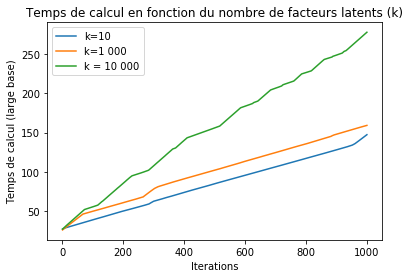

In [17]:
## Temps de calcul en fonction du nombre de facteurs latent (10, 100, 1000)

# 10 facteurs latents
l3 = [26.808698892593384, 26.990194082260132, 27.21222186088562, 27.390955924987793, 27.575982809066772, 27.776395082473755, 27.94549560546875, 28.092321157455444, 28.214744329452515, 28.33069109916687, 28.44588828086853, 28.54614233970642, 28.677709102630615, 28.793354749679565, 28.930629014968872, 29.046184062957764, 29.161927700042725, 29.277358770370483, 29.39336109161377, 29.51516032218933, 29.630802392959595, 29.762863397598267, 29.89396023750305, 29.99432921409607, 30.11632490158081, 30.23204278945923, 30.34764289855957, 30.47923755645752, 30.595205307006836, 30.717248916625977, 30.83298349380493, 30.948896408081055, 31.079983234405518, 31.179809093475342, 31.28023910522461, 31.395753383636475, 31.517629146575928, 31.633487939834595, 31.749062061309814, 31.849292278289795, 31.964871883392334, 32.064861536026, 32.18031859397888, 32.280539751052856, 32.39612650871277, 32.51780128479004, 32.63405799865723, 32.74909996986389, 32.8489887714386, 32.96457362174988, 33.08019137382507, 33.180055379867554, 33.29594564437866, 33.41754674911499, 33.53359508514404, 33.633896827697754, 33.749683141708374, 33.8651168346405, 33.981067419052124, 34.08104133605957, 34.196948766708374, 34.29696607589722, 34.419206380844116, 34.51898813247681, 34.61978101730347, 34.735379457473755, 34.8511917591095, 34.982770919799805, 35.09837293624878, 35.21931791305542, 35.321078062057495, 35.436991691589355, 35.53718113899231, 35.63699293136597, 35.721179723739624, 35.85250449180603, 35.95283484458923, 36.06881809234619, 36.18446946144104, 36.300034046173096, 36.42215967178345, 36.537699937820435, 36.653680086135864, 36.75374460220337, 36.86933469772339, 36.984824895858765, 37.100266456604004, 37.22190713882446, 37.33787226676941, 37.45385479927063, 37.56894516944885, 37.68450140953064, 37.78446125984192, 37.9002959728241, 38.02196502685547, 38.13756585121155, 38.299893379211426, 38.3998498916626, 38.52181911468506, 38.62173581123352, 38.73728537559509, 38.83751440048218, 38.953033447265625, 39.06871843338013, 39.184216260910034, 39.29991126060486, 39.41842532157898, 39.52172088623047, 39.62158679962158, 39.75287628173828, 39.868550300598145, 39.968528270721436, 40.084108114242554, 40.183879375457764, 40.3002655506134, 40.422202587127686, 40.52270317077637, 40.63843607902527, 40.73835301399231, 40.85418939590454, 40.97014546394348, 41.07007551193237, 41.185569047927856, 41.28538799285889, 41.40176820755005, 41.52387714385986, 41.62373757362366, 41.73952293395996, 41.83951449394226, 41.95543384552002, 42.07044839859009, 42.17077708244324, 42.286282777786255, 42.38619327545166, 42.50170421600342, 42.62391757965088, 42.723697900772095, 42.83979773521423, 42.940080642700195, 43.05564069747925, 43.18718123435974, 43.28740310668945, 43.402987003326416, 43.524566411972046, 43.64600586891174, 43.77173900604248, 43.88731145858765, 44.002795696258545, 44.125280141830444, 44.24120259284973, 44.35715293884277, 44.472660779953, 44.588146686553955, 44.70365571975708, 44.8251633644104, 44.95671486854553, 45.072771310806274, 45.18859076499939, 45.28887605667114, 45.38915801048279, 45.50509977340698, 45.605371952056885, 45.72740912437439, 45.82722067832947, 45.92753744125366, 46.04305171966553, 46.15857672691345, 46.274211168289185, 46.37450194358826, 46.490012884140015, 46.590296030044556, 46.70575928688049, 46.824809074401855, 46.92750692367554, 47.04346466064453, 47.15896677970886, 47.359312772750854, 47.474857568740845, 47.5904061794281, 47.70583963394165, 47.806302070617676, 47.926788330078125, 48.02798938751221, 48.127833127975464, 48.24352955818176, 48.35947346687317, 48.45954751968384, 48.55944085121155, 48.675368547439575, 48.77542757987976, 48.87534022331238, 48.99084281921387, 49.090739250183105, 49.20616626739502, 49.30600380897522, 49.427550077438354, 49.5277898311615, 49.627639293670654, 49.72829747200012, 49.8437077999115, 49.9438591003418, 50.04384517669678, 50.143707036972046, 50.24401831626892, 50.35988259315491, 50.459757804870605, 50.559696197509766, 50.675605058670044, 50.77497339248657, 50.89063048362732, 51.00629758834839, 51.10609412193298, 51.20687747001648, 51.30683898925781, 51.4229302406311, 51.528504371643066, 51.628459215164185, 51.728328466415405, 51.82839870452881, 51.9442081451416, 52.04413318634033, 52.14394736289978, 52.24382519721985, 52.34398698806763, 52.443862438201904, 52.5596182346344, 52.659621477127075, 52.75962281227112, 52.85964322090149, 52.975449562072754, 53.07531952857971, 53.17951226234436, 53.27552056312561, 53.37541651725769, 53.490883111953735, 53.606547117233276, 53.710994482040405, 53.806769132614136, 53.906710386276245, 54.02823615074158, 54.12810254096985, 54.228272438049316, 54.32566809654236, 54.42316794395447, 54.52833104133606, 54.62816572189331, 54.74370098114014, 54.859768867492676, 54.95970559120178, 55.07535719871521, 55.1908597946167, 55.291152238845825, 55.39098000526428, 55.50645089149475, 55.60678577423096, 55.72497868537903, 55.82879567146301, 55.92930197715759, 56.02918219566345, 56.145103216171265, 56.24516940116882, 56.361101150512695, 56.47655463218689, 56.57651734352112, 56.69203329086304, 56.792179107666016, 56.90778708457947, 57.00774788856506, 57.107619762420654, 57.2291955947876, 57.32914137840271, 57.444836378097534, 57.56077980995178, 57.66073536872864, 57.776660203933716, 57.87615966796875, 57.99169611930847, 58.09169960021973, 58.19196343421936, 58.307573080062866, 58.40752673149109, 58.52678990364075, 58.6295530796051, 58.72989845275879, 58.976566791534424, 59.24566411972046, 59.47713613510132, 59.72824311256409, 59.96133613586426, 60.17711305618286, 60.40861749649048, 60.646997690200806, 60.87801480293274, 61.109723806381226, 61.37901163101196, 61.64796257019043, 61.879741191864014, 62.095402002334595, 62.24831986427307, 62.36383938789368, 62.47937893867493, 62.59532856941223, 62.69516348838806, 62.810638666152954, 62.9322030544281, 63.0482861995697, 63.148317098617554, 63.248271226882935, 63.363800287246704, 63.479461431503296, 63.57946467399597, 63.6994411945343, 63.81140208244324, 63.91159987449646, 64.03369784355164, 64.14920234680176, 64.24933648109436, 64.36527180671692, 64.46508288383484, 64.5810341835022, 64.69655299186707, 64.7964551448822, 64.91199922561646, 65.0118818283081, 65.13337588310242, 65.23416543006897, 65.35026502609253, 65.46620750427246, 65.5660195350647, 65.69724583625793, 65.79754590988159, 65.93138360977173, 66.0348391532898, 66.16615915298462, 66.29772186279297, 66.4327335357666, 66.5346200466156, 66.65060758590698, 66.76618719100952, 66.88207149505615, 66.99766421318054, 67.11353659629822, 67.21385097503662, 67.31339979171753, 67.43532752990723, 67.53594255447388, 67.65156197547913, 67.76714849472046, 67.86746549606323, 67.98244166374207, 68.08231806755066, 68.19786357879639, 68.29814910888672, 68.39761662483215, 68.51351141929626, 68.63500118255615, 68.73567938804626, 68.836177110672, 68.9517412185669, 69.06755661964417, 69.16749334335327, 69.28309774398804, 69.38329720497131, 69.49923205375671, 69.61490321159363, 69.73653078079224, 69.83656740188599, 69.95284271240234, 70.05268168449402, 70.18383193016052, 70.29933214187622, 70.4149739742279, 70.53606033325195, 70.63740849494934, 70.76855039596558, 70.8841323852539, 71.00009322166443, 71.09997701644897, 71.21539449691772, 71.35313439369202, 71.45302486419678, 71.56856179237366, 71.68453669548035, 71.80026364326477, 71.91571044921875, 72.03734159469604, 72.15334486961365, 72.26925206184387, 72.38513278961182, 72.50079369544983, 72.61637449264526, 72.73502039909363, 72.838294506073, 72.95424914360046, 73.08581399917603, 73.20175504684448, 73.31768608093262, 73.43611693382263, 73.5396044254303, 73.67131757736206, 73.78714799880981, 73.90244030952454, 74.01791167259216, 74.13982057571411, 74.25547194480896, 74.37100529670715, 74.48645210266113, 74.58673644065857, 74.70267367362976, 74.81829929351807, 74.9406898021698, 75.05663633346558, 75.15691566467285, 75.25682258605957, 75.37241840362549, 75.48794102668762, 75.60386776924133, 75.70366406440735, 75.80365252494812, 75.91918611526489, 76.04088091850281, 76.14082551002502, 76.24074172973633, 76.3568217754364, 76.47278046607971, 76.57307243347168, 76.67298793792725, 76.78892540931702, 76.88919425010681, 77.0046284198761, 77.10453915596008, 77.20487880706787, 77.32074284553528, 77.44225859642029, 77.5421621799469, 77.65829873085022, 77.7740867137909, 77.87444138526917, 77.9742751121521, 78.08976149559021, 78.19469332695007, 78.30557012557983, 78.4211049079895, 78.52126574516296, 78.64185309410095, 78.74280858039856, 78.85853123664856, 78.97411036491394, 79.07441735267639, 79.18993759155273, 79.28985524177551, 79.39019703865051, 79.50576138496399, 79.60602927207947, 79.7217960357666, 79.8440260887146, 79.94380640983582, 80.04369688034058, 80.14419293403625, 80.2601249217987, 80.37565636634827, 80.47575664520264, 80.57603192329407, 80.67611122131348, 80.79182505607605, 80.90738892555237, 81.00735831260681, 81.12313437461853, 81.22306704521179, 81.34468126296997, 81.44469213485718, 81.56045031547546, 81.66034436225891, 81.77661371231079, 81.87656807899475, 81.99250888824463, 82.10793352127075, 82.20753407478333, 82.30763864517212, 82.42343473434448, 82.52361512184143, 82.6422963142395, 82.74575114250183, 82.8455502986908, 82.96142101287842, 83.07749056816101, 83.26211857795715, 83.37802791595459, 83.49396228790283, 83.60945558547974, 83.74525618553162, 83.84711360931396, 83.96318459510803, 84.0635199546814, 84.17947816848755, 84.2949447631836, 84.39527177810669, 84.51076817512512, 84.61919379234314, 84.726065158844, 84.84359049797058, 84.94821691513062, 85.0480899810791, 85.14805555343628, 85.24799489974976, 85.36414384841919, 85.47993278503418, 85.57980298995972, 85.69549894332886, 85.81146764755249, 85.91144490242004, 86.02727174758911, 86.14724206924438, 86.24883890151978, 86.34923577308655, 86.46494770050049, 86.58056879043579, 86.68089151382446, 86.79642486572266, 86.8967297077179, 87.01261782646179, 87.11261892318726, 87.21292662620544, 87.32806372642517, 87.42797040939331, 87.54946875572205, 87.6493911743164, 87.7654013633728, 87.86534094810486, 87.96520066261292, 88.08086061477661, 88.1964430809021, 88.29627394676208, 88.41184115409851, 88.51204538345337, 88.6275007724762, 88.73183035850525, 88.84902286529541, 88.94967770576477, 89.06520485877991, 89.18084049224854, 89.2810869216919, 89.38138008117676, 89.49694442749023, 89.59726452827454, 89.71275639533997, 89.82869863510132, 89.92877864837646, 90.04593849182129, 90.14916324615479, 90.25057864189148, 90.36665177345276, 90.46697878837585, 90.58258628845215, 90.68292427062988, 90.79869437217712, 90.89858222007751, 91.01412296295166, 91.11411142349243, 91.22959232330322, 91.32989001274109, 91.42935037612915, 91.54503345489502, 91.64640092849731, 91.75071811676025, 91.8518750667572, 91.96781301498413, 92.06784176826477, 92.16810774803162, 92.28341698646545, 92.38336992263794, 92.49905300140381, 92.59938311576843, 92.71492791175842, 92.81499648094177, 92.93049049377441, 93.04710459709167, 93.14690947532654, 93.25227665901184, 93.35297274589539, 93.45303893089294, 93.56856369972229, 93.66873741149902, 93.78452396392822, 93.88485407829285, 94.0008556842804, 94.10109806060791, 94.20102739334106, 94.31652498245239, 94.41662096977234, 94.53220582008362, 94.63251447677612, 94.7542085647583, 94.8546142578125, 94.97023320198059, 95.08588433265686, 95.18578314781189, 95.301278591156, 95.4016010761261, 95.51709079742432, 95.6326379776001, 95.73295068740845, 95.8329210281372, 95.93280386924744, 96.04966878890991, 96.15536856651306, 96.270836353302, 96.3713047504425, 96.48694038391113, 96.58730101585388, 96.68719100952148, 96.80280184745789, 96.90283584594727, 97.01876735687256, 97.11886548995972, 97.23441958427429, 97.33451437950134, 97.43453311920166, 97.55053329467773, 97.65435981750488, 97.75604724884033, 97.85633277893066, 97.97200584411621, 98.08786821365356, 98.18785762786865, 98.30337071418762, 98.40333318710327, 98.5192666053772, 98.61915564537048, 98.7243766784668, 98.83528900146484, 98.95515561103821, 99.05694079399109, 99.15689706802368, 99.27275967597961, 99.38839936256409, 99.48840284347534, 99.60387372970581, 99.70377254486084, 99.80368256568909, 99.91917204856873, 100.01912713050842, 100.13468098640442, 100.23462677001953, 100.35643458366394, 100.45629668235779, 100.55612397193909, 100.67174625396729, 100.77181553840637, 100.8873221874237, 101.00327825546265, 101.11919951438904, 101.23511290550232, 101.33509659767151, 101.43504428863525, 101.55638837814331, 101.6568603515625, 101.75689888000488, 101.87256288528442, 101.98851656913757, 102.08880829811096, 102.20441770553589, 102.30469989776611, 102.40498185157776, 102.50497722625732, 102.62073349952698, 102.7210419178009, 102.83616018295288, 102.93644952774048, 103.03635430335999, 103.15814256668091, 103.2742030620575, 103.37411236763, 103.49003958702087, 103.60558795928955, 103.70998883247375, 103.82139706611633, 103.9369707107544, 104.0371036529541, 104.13713645935059, 104.25810861587524, 104.35942673683167, 104.4593255519867, 104.57546377182007, 104.6757595539093, 104.79150867462158, 104.9074375629425, 105.0077714920044, 105.12333488464355, 105.22297501564026, 105.33894801139832, 105.46044445037842, 105.55882096290588, 105.63899159431458, 105.73929214477539, 105.83959436416626, 105.96152377128601, 106.06146049499512, 106.16132760047913, 106.2770299911499, 106.37706160545349, 106.49301171302795, 106.59296369552612, 106.70839548110962, 106.80860757827759, 106.92412090301514, 107.03967714309692, 107.13953518867493, 107.23988127708435, 107.34019041061401, 107.46266198158264, 107.5624737739563, 107.67841672897339, 107.77870035171509, 107.89427947998047, 108.00978016853333, 108.10976958274841, 108.20990705490112, 108.3100950717926, 108.42558169364929, 108.54105186462402, 108.6576931476593, 108.76182436943054, 108.86312627792358, 108.96312808990479, 109.0787079334259, 109.19427108764648, 109.2944815158844, 109.40993189811707, 109.51026678085327, 109.62593674659729, 109.72577953338623, 109.82610487937927, 109.94165992736816, 110.04159116744995, 110.1637954711914, 110.26357698440552, 110.36404705047607, 110.47987246513367, 110.59550452232361, 110.69555306434631, 110.79545402526855, 110.91099309921265, 111.02688097953796, 111.12628650665283, 111.24189138412476, 111.34186816215515, 111.46087646484375, 111.56358003616333, 111.66349339485168, 111.79480457305908, 111.89496064186096, 112.01051449775696, 112.11032724380493, 112.2102382183075, 112.32581377029419, 112.42567348480225, 112.54165077209473, 112.64197516441345, 112.7637460231781, 112.87939596176147, 112.97930479049683, 113.09482717514038, 113.19500589370728, 113.29532885551453, 113.41100597381592, 113.52657103538513, 113.6267499923706, 113.73135137557983, 113.84234237670898, 113.94268012046814, 114.04255938529968, 114.15869307518005, 114.26453185081482, 114.36460614204407, 114.48042702674866, 114.59634280204773, 114.69664883613586, 114.79666137695312, 114.91260409355164, 115.02829194068909, 115.12859845161438, 115.24416995048523, 115.3442690372467, 115.46587681770325, 115.56586456298828, 115.68138837814331, 115.79702281951904, 115.91285800933838, 116.02831554412842, 116.14373326301575, 116.26261854171753, 116.36550807952881, 116.4656183719635, 116.58137083053589, 116.7128598690033, 116.81323075294495, 116.92896437644958, 117.02919960021973, 117.1291515827179, 117.24509119987488, 117.34543919563293, 117.4454779624939, 117.56740999221802, 117.66730332374573, 117.78297734260559, 117.88287377357483, 117.9988169670105, 118.09860277175903, 118.19844007492065, 118.31397819519043, 118.41429805755615, 118.52987217903137, 118.62978315353394, 118.73418593406677, 118.84560346603394, 118.9644558429718, 119.06695532798767, 119.16690707206726, 119.26716613769531, 119.38274598121643, 119.49870443344116, 119.59864139556885, 119.69896507263184, 119.81442427635193, 119.93024945259094, 120.03030276298523, 120.14627265930176, 120.24655508995056, 120.36713886260986, 120.48400712013245, 120.58385610580444, 120.68387722969055, 120.79981398582458, 120.89978265762329, 121.0153214931488, 121.13084506988525, 121.23117566108704, 121.3313581943512, 121.44728636741638, 121.56651830673218, 121.66930747032166, 121.76934885978699, 121.88567590713501, 122.00072717666626, 122.11625027656555, 122.2165367603302, 122.31685733795166, 122.43236589431763, 122.53269076347351, 122.63220238685608, 122.73207092285156, 122.84798264503479, 122.94797348976135, 123.06797218322754, 123.18578314781189, 123.28590297698975, 123.4013843536377, 123.50169086456299, 123.60161566734314, 123.72168827056885, 123.83294105529785, 123.93326687812805, 124.04909896850586, 124.14904952049255, 124.27150297164917, 124.37181115150452, 124.48683619499207, 124.6025333404541, 124.70244717597961, 124.81796622276306, 124.93379759788513, 125.03372359275818, 125.14962244033813, 125.24906468391418, 125.3680727481842, 125.47087669372559, 125.58723187446594, 125.68706345558167, 125.80289196968079, 125.91847777366638, 126.01875901222229, 126.13425040245056, 126.24971985816956, 126.34961700439453, 126.47204828262329, 126.57182788848877, 126.68768167495728, 126.8031210899353, 126.90297198295593, 127.0185112953186, 127.13412404060364, 127.25001811981201, 127.36646318435669, 127.47042870521545, 127.57183909416199, 127.75077152252197, 127.87025380134583, 127.9725456237793, 128.0732901096344, 128.1733295917511, 128.28892922401428, 128.38926100730896, 128.48954486846924, 128.60502576828003, 128.70918917655945, 128.82111883163452, 128.936678647995, 129.05224299430847, 129.15241265296936, 129.27387046813965, 129.37388968467712, 129.48993802070618, 129.6055290699005, 129.70555710792542, 129.8213930130005, 129.9369719028473, 130.03683710098267, 130.15327739715576, 130.25322318077087, 130.3747763633728, 130.47516226768494, 130.5902979373932, 130.70582056045532, 130.80627536773682, 130.92192196846008, 131.03786969184875, 131.1734516620636, 131.27524209022522, 131.37512016296387, 131.49141335487366, 131.6069016456604, 131.73847079277039, 131.83877038955688, 131.9388120174408, 132.05472826957703, 132.17649912834167, 132.29250860214233, 132.40841794013977, 132.52397274971008, 132.6238055229187, 132.7399241924286, 132.87448263168335, 132.97760915756226, 133.09346675872803, 133.20940780639648, 133.32534909248352, 133.45690774917603, 133.5793788433075, 133.71510457992554, 133.89555597305298, 134.0801396369934, 134.3116397857666, 134.59660744667053, 134.81233668327332, 134.99696111679077, 135.14415311813354, 135.3441264629364, 135.51305627822876, 135.68142986297607, 135.98187565803528, 136.28222799301147, 136.48332715034485, 136.77968406677246, 137.06246066093445, 137.34739875793457, 137.6627984046936, 137.98486328125, 138.28545904159546, 138.56404566764832, 138.8492271900177, 139.1343116760254, 139.43484473228455, 139.71978569030762, 140.00485372543335, 140.28933310508728, 140.62160897254944, 140.92179036140442, 141.2070689201355, 141.49226927757263, 141.77066683769226, 142.05560207366943, 142.37171125411987, 142.65638947486877, 142.957261800766, 143.24255299568176, 143.54325485229492, 143.8588104248047, 144.14371538162231, 144.4287304878235, 144.71383595466614, 145.0145161151886, 145.31490659713745, 145.5997223854065, 145.9001603126526, 146.1788604259491, 146.50126099586487, 146.80219745635986, 147.1031789779663, 147.38104128837585]
# 1000 facteurs latents
l4 = [25.7486515045166, 26.065138578414917, 26.424423217773438, 26.719655990600586, 27.02036738395691, 27.337013006210327, 27.637969255447388, 27.969688892364502, 28.270659685134888, 28.571572065353394, 28.872458457946777, 29.16290545463562, 29.49473738670349, 29.773985624313354, 30.07493567466736, 30.39760398864746, 30.694011926651, 30.99941897392273, 31.300365924835205, 31.600974559783936, 31.879273653030396, 32.180195331573486, 32.48111438751221, 32.78172779083252, 33.06686091423035, 33.40427613258362, 33.70470976829529, 34.00592350959778, 34.306411266326904, 34.60681700706482, 34.88611960411072, 35.17052626609802, 35.5037784576416, 35.787089109420776, 36.071879386901855, 36.38836216926575, 36.67356300354004, 36.99010920524597, 37.27531123161316, 37.56019639968872, 37.86019325256348, 38.145516872406006, 38.46212816238403, 38.76258707046509, 39.04785418510437, 39.363834619522095, 39.64819669723511, 39.98038125038147, 40.26546788215637, 40.55043005943298, 40.85127282142639, 41.136054277420044, 41.45214295387268, 41.73748445510864, 42.02230477333069, 42.35402727127075, 42.6393187046051, 42.95493173599243, 43.25554585456848, 43.556004762649536, 43.840895652770996, 44.14182424545288, 44.473998069763184, 44.75890278816223, 45.059890031814575, 45.376442670822144, 45.66168689727783, 45.977290630340576, 46.09319758415222, 46.226269483566284, 46.330626010894775, 46.44703197479248, 46.56274080276489, 46.66302728652954, 46.778605699539185, 46.894516944885254, 46.994425773620605, 47.12895488739014, 47.23194885253906, 47.33209681510925, 47.448142528533936, 47.56346416473389, 47.66346716880798, 47.77887225151062, 47.89447474479675, 48.01000499725342, 48.109872579574585, 48.23138785362244, 48.34780812263489, 48.44744062423706, 48.56305813789368, 48.662951707839966, 48.778748989105225, 48.894450664520264, 49.01012706756592, 49.10999250411987, 49.23111629486084, 49.331921100616455, 49.43247604370117, 49.548084020614624, 49.663763999938965, 49.76404809951782, 49.879953145980835, 49.97998785972595, 50.0956814289093, 50.19590377807617, 50.311461210250854, 50.41127920150757, 50.53377628326416, 50.63360905647278, 50.74955701828003, 50.84990382194519, 50.96573543548584, 51.0657262802124, 51.16636848449707, 51.28225231170654, 51.38223719596863, 51.49819207191467, 51.614128828048706, 51.71404147148132, 51.83026075363159, 51.935728549957275, 52.05179977416992, 52.15168213844299, 52.25190496444702, 52.367841720581055, 52.4681556224823, 52.583391427993774, 52.69918966293335, 52.79906344413757, 52.91465950012207, 53.014634132385254, 53.135199785232544, 53.236392974853516, 53.33655285835266, 53.45225644111633, 53.55234718322754, 53.66796946525574, 53.76798129081726, 53.883469104766846, 53.99919414520264, 54.114726543426514, 54.23631429672241, 54.35200238227844, 54.45229244232178, 54.58350110054016, 54.69898295402527, 54.81494641304016, 54.91477966308594, 55.01471924781799, 55.13617920875549, 55.236993074417114, 55.352904081344604, 55.46837306022644, 55.58430290222168, 55.70024609565735, 55.80007791519165, 55.915650844573975, 56.01560068130493, 56.13153910636902, 56.23705267906189, 56.35278010368347, 56.453375577926636, 56.568904876708984, 56.68438267707825, 56.799925088882446, 56.89973187446594, 57.01593589782715, 57.136411905288696, 57.23847246170044, 57.3387815952301, 57.43906283378601, 57.554107904434204, 57.66996455192566, 57.77028751373291, 57.88626527786255, 58.00174307823181, 58.10165309906006, 58.2172474861145, 58.317219257354736, 58.417173862457275, 58.53629946708679, 58.63959717750549, 58.75518488883972, 58.85528826713562, 58.970909118652344, 59.07087326049805, 59.18678259849548, 59.301918506622314, 59.4018018245697, 59.51738977432251, 59.61758208274841, 59.740023374557495, 59.83934664726257, 59.95510172843933, 60.05533027648926, 60.17132544517517, 60.28727173805237, 60.40272641181946, 60.518261671066284, 60.63709568977356, 60.7399685382843, 60.855584383010864, 60.97156119346619, 61.08674192428589, 61.18669056892395, 61.30259561538696, 61.422367334365845, 61.53477716445923, 61.63960003852844, 61.740312337875366, 61.85535216331482, 61.97129201889038, 62.0868878364563, 62.186824798583984, 62.302687644958496, 62.41818857192993, 62.53722429275513, 62.64043211936951, 62.740254163742065, 62.85601043701172, 62.97169232368469, 63.10330843925476, 63.20307779312134, 63.302934646606445, 63.41868996620178, 63.51873421669006, 63.640432834625244, 63.75652837753296, 63.872477769851685, 63.97219944000244, 64.08800864219666, 64.20351982116699, 64.30382990837097, 64.41940069198608, 64.53494000434875, 64.63594722747803, 64.7416262626648, 64.84148526191711, 64.9573302268982, 65.05744218826294, 65.1573896408081, 65.288494348526, 65.40401029586792, 65.52421164512634, 65.64179396629333, 65.75733470916748, 65.87321090698242, 65.9891574382782, 66.10511445999146, 66.22101068496704, 66.35864233970642, 66.47448182106018, 66.59044647216797, 66.70595455169678, 66.82149863243103, 66.94333505630493, 67.0594208240509, 67.19058990478516, 67.30608177185059, 67.40603423118591, 67.5215675830841, 67.64307069778442, 67.75861716270447, 67.8749737739563, 67.99091482162476, 68.39093899726868, 68.67595195770264, 68.96085405349731, 69.26144289970398, 69.54631447792053, 69.84626173973083, 70.14352989196777, 70.4466450214386, 70.76315402984619, 71.07925200462341, 71.36405229568481, 71.64743900299072, 71.92768907546997, 72.22856903076172, 72.5133957862854, 72.79870247840881, 73.08401250839233, 73.36829948425293, 73.68440866470337, 74.00071620941162, 74.28569626808167, 74.57079744338989, 74.855304479599, 75.1553270816803, 75.4531261920929, 75.71872687339783, 76.00406312942505, 76.28855395317078, 76.58892321586609, 76.9052836894989, 77.19032955169678, 77.45957851409912, 77.73825287818909, 78.06103467941284, 78.35497856140137, 78.53956413269043, 78.74013090133667, 78.90953803062439, 79.1255578994751, 79.32562112808228, 79.51012301445007, 79.710702419281, 79.89519047737122, 80.11108136177063, 80.3109974861145, 80.4959545135498, 80.68031430244446, 80.86440300941467, 81.02765464782715, 81.14316582679749, 81.28075742721558, 81.39625883102417, 81.52813816070557, 81.64404201507568, 81.7820303440094, 81.89758038520813, 82.02914547920227, 82.14507174491882, 82.26654982566833, 82.3982002735138, 82.529367685318, 82.6453046798706, 82.7645378112793, 82.88255476951599, 82.99842095375061, 83.11388993263245, 83.2136812210083, 83.31428408622742, 83.44567704200745, 83.54546689987183, 83.66792821884155, 83.78392577171326, 83.89984250068665, 84.04662799835205, 84.16755628585815, 84.28463649749756, 84.40054416656494, 84.53169298171997, 84.64725589752197, 84.76968789100647, 84.88529825210571, 85.00085401535034, 85.11653280258179, 85.24775290489197, 85.36970353126526, 85.48575925827026, 85.60167145729065, 85.70195579528809, 85.83349895477295, 85.96755075454712, 86.08741331100464, 86.20334482192993, 86.31840920448303, 86.43868565559387, 86.56648802757263, 86.68754148483276, 86.78748297691345, 86.9033932685852, 87.03458952903748, 87.15024185180664, 87.2721996307373, 87.37225437164307, 87.4722306728363, 87.58826017379761, 87.70422029495239, 87.81992506980896, 87.92014145851135, 88.02003908157349, 88.13551235198975, 88.27306962013245, 88.38872814178467, 88.48877048492432, 88.6203088760376, 88.73619270324707, 88.8696973323822, 88.99012494087219, 89.1060540676117, 89.23759198188782, 89.3535053730011, 89.47542643547058, 89.59154057502747, 89.70750522613525, 89.80778956413269, 89.92342209815979, 90.03925037384033, 90.15482139587402, 90.25471472740173, 90.37664747238159, 90.49266719818115, 90.60800457000732, 90.70788168907166, 90.82344698905945, 90.92329835891724, 91.03897595405579, 91.1392457485199, 91.25487470626831, 91.35483813285828, 91.45966100692749, 91.57569098472595, 91.67703199386597, 91.79267573356628, 91.89299297332764, 92.00852656364441, 92.10881614685059, 92.22424364089966, 92.32447743415833, 92.42476797103882, 92.54036450386047, 92.65617442131042, 92.77789282798767, 92.87838101387024, 92.99428534507751, 93.09423470497131, 93.21014022827148, 93.3260509967804, 93.4102942943573, 93.52599120140076, 93.62590456008911, 93.74151968955994, 93.8574640750885, 93.95735144615173, 94.07483649253845, 94.17877244949341, 94.29459524154663, 94.39444231987, 94.49433040618896, 94.60997009277344, 94.70997905731201, 94.82561540603638, 94.941575050354, 95.04186058044434, 95.15744853019714, 95.27598834037781, 95.3798155784607, 95.49544930458069, 95.61138987541199, 95.72638940811157, 95.84227132797241, 95.95779347419739, 96.07481408119202, 96.17968416213989, 96.2795991897583, 96.37946915626526, 96.49544262886047, 96.61108303070068, 96.72657990455627, 96.84205389022827, 96.94234085083008, 97.05873417854309, 97.18032813072205, 97.28068947792053, 97.3961808681488, 97.4955484867096, 97.62661480903625, 97.72742938995361, 97.85858750343323, 97.95864653587341, 98.05858445167542, 98.18061304092407, 98.28089213371277, 98.39646744728088, 98.49672770500183, 98.61265254020691, 98.71252608299255, 98.82801747322083, 98.94390392303467, 99.04375863075256, 99.14405488967896, 99.25999355316162, 99.38111019134521, 99.48107147216797, 99.58101058006287, 99.6967887878418, 99.79709911346436, 99.91280722618103, 100.02823567390442, 100.1439437866211, 100.24389863014221, 100.35960507392883, 100.48125314712524, 100.58149361610413, 100.69729518890381, 100.79761481285095, 100.91334915161133, 101.02926087379456, 101.12919807434082, 101.22921371459961, 101.34517741203308, 101.46547603607178, 101.57666516304016, 101.68200469017029, 101.78331518173218, 101.89919328689575, 102.01511931419373, 102.11478304862976, 102.21459937095642, 102.33054041862488, 102.43086218833923, 102.54640555381775, 102.66213631629944, 102.76226019859314, 102.88080596923828, 102.9841148853302, 103.08402848243713, 103.19973587989807, 103.31546568870544, 103.39976334571838, 103.49962306022644, 103.60040521621704, 103.71568131446838, 103.83143591880798, 103.94694757461548, 104.0785903930664, 104.19967794418335, 104.31527471542358, 104.41511082649231, 104.53101825714111, 104.64656734466553, 104.78039407730103, 104.88421535491943, 104.99993348121643, 105.11548352241516, 105.23140525817871, 105.36266469955444, 105.47838020324707, 105.58474493026733, 105.70069980621338, 105.80057287216187, 105.94747376441956, 106.06339859962463, 106.16370248794556, 106.26364469528198, 106.38020348548889, 106.48505473136902, 106.58516025543213, 106.70133996009827, 106.81698656082153, 106.91718554496765, 107.04828548431396, 107.1637122631073, 107.28536462783813, 107.40172219276428, 107.50166630744934, 107.63274216651917, 107.74863886833191, 107.86463260650635, 107.98289108276367, 108.08618307113647, 108.21729922294617, 108.33316946029663, 108.44906115531921, 108.54898118972778, 108.64894723892212, 108.78137707710266, 108.88648533821106, 108.98694467544556, 109.08620953559875, 109.2023184299469, 109.31780982017517, 109.43376469612122, 109.53410792350769, 109.64960813522339, 109.7498893737793, 109.86503529548645, 109.96490597724915, 110.08299446105957, 110.18734431266785, 110.28765606880188, 110.40320348739624, 110.51916766166687, 110.63443303108215, 110.75038480758667, 110.86583042144775, 111.00339937210083, 111.10403656959534, 111.21999382972717, 111.35153031349182, 111.45557641983032, 111.58862853050232, 111.7198634147644, 111.83545184135437, 111.95094847679138, 112.06652235984802, 112.18842697143555, 112.30400800704956, 112.41955757141113, 112.53542757034302, 112.651038646698, 112.78863668441772, 112.91979742050171, 113.01974582672119, 113.15126419067383, 113.25109314918518, 113.35141181945801, 113.46687316894531, 113.58878207206726, 113.68872594833374, 113.82027101516724, 113.93616247177124, 114.05208802223206, 114.16779565811157, 114.28985452651978, 114.40581703186035, 114.5373957157135, 114.63767886161804, 114.7532205581665, 114.86877393722534, 114.98755192756653, 115.0913827419281, 115.20688676834106, 115.32234001159668, 115.43880701065063, 115.53909492492676, 115.6549460887909, 115.77080297470093, 115.87071657180786, 115.98668837547302, 116.09353113174438, 116.2094841003418, 116.30956816673279, 116.40945148468018, 116.52509903907776, 116.62543869018555, 116.7408618927002, 116.84105134010315, 116.95667004585266, 117.07240128517151, 117.17271018028259, 117.29018759727478, 117.39498114585876, 117.49497842788696, 117.59573316574097, 117.7116711139679, 117.82727408409119, 117.92752027511597, 118.04301238059998, 118.1589457988739, 118.25899863243103, 118.3740746974945, 118.4740583896637, 118.59593558311462, 118.69585752487183, 118.79574418067932, 118.92730498313904, 119.04322600364685, 119.17457604408264, 119.29013228416443, 119.39699482917786, 119.5283875465393, 119.6443521976471, 119.75973463058472, 119.87532091140747, 119.9917950630188, 120.09700798988342, 120.2127332687378, 120.31274318695068, 120.42822790145874, 120.52849769592285, 120.64435696601868, 120.75948548316956, 120.85980010032654, 120.97564601898193, 121.09664988517761, 121.21328854560852, 121.31357216835022, 121.4134087562561, 121.51349949836731, 121.62939643859863, 121.72962307929993, 121.84523630142212, 122.01378750801086, 122.11391353607178, 122.21379613876343, 122.32971358299255, 122.42963767051697, 122.54560661315918, 122.64593172073364, 122.76184272766113, 122.87745356559753, 122.9999451637268, 123.11520504951477, 123.21547722816467, 123.31575393676758, 123.43124866485596, 123.54682970046997, 123.64701771736145, 123.76270818710327, 123.8630199432373, 123.96291208267212, 124.07835912704468, 124.20028853416443, 124.30073189735413, 124.4162015914917, 124.51650285720825, 124.63208889961243, 124.73202300071716, 124.84763479232788, 124.9479455947876, 125.04740619659424, 125.16333508491516, 125.27932262420654, 125.39676237106323, 125.50113224983215, 125.6009955406189, 125.71723198890686, 125.81669235229492, 125.93265628814697, 126.03301405906677, 126.1486701965332, 126.2801866531372, 126.3801257610321, 126.50214862823486, 126.61811661720276, 126.73403000831604, 126.86507177352905, 126.98066020011902, 127.09721279144287, 127.20221138000488, 127.31823921203613, 127.44942617416382, 127.56523489952087, 127.68070101737976, 127.80320596694946, 127.919118642807, 128.0504126548767, 128.15035009384155, 128.26593446731567, 128.3818678855896, 128.49956035614014, 128.61985993385315, 128.73576831817627, 128.8512933254242, 128.95159268379211, 129.06704258918762, 129.2041721343994, 129.30413484573364, 129.40450048446655, 129.5204577445984, 129.63599944114685, 129.76752638816833, 129.86780881881714, 129.98339080810547, 130.10581016540527, 130.20561528205872, 130.3216290473938, 130.42142987251282, 130.52174925804138, 130.63739609718323, 130.7377371788025, 130.853045463562, 130.95338439941406, 131.06855249404907, 131.1688756942749, 131.28448367118835, 131.40640902519226, 131.50662565231323, 131.6222927570343, 131.73774313926697, 131.85366559028625, 131.96957397460938, 132.0854833126068, 132.18579936027527, 132.30741810798645, 132.407879114151, 132.5234718322754, 132.62371730804443, 132.73965454101562, 132.83908247947693, 132.95457339286804, 133.0702006816864, 133.18579626083374, 133.27012395858765, 133.3699290752411, 133.48554968833923, 133.60733032226562, 133.72342467308044, 133.82372403144836, 133.92315077781677, 134.02341532707214, 134.13912081718445, 134.25505805015564, 134.37096571922302, 134.47092151641846, 134.57072019577026, 134.68634414672852, 134.78621912002563, 134.8862190246582, 134.98609566688538, 135.10767793655396, 135.22327327728271, 135.32335329055786, 135.43892693519592, 135.53877139091492, 135.65452599525452, 135.75483679771423, 135.8705174922943, 135.98617482185364, 136.10187911987305, 136.20822381973267, 136.3239550590515, 136.42926907539368, 136.53930687904358, 136.65495896339417, 136.7704336643219, 136.8861906528473, 137.00272464752197, 137.10817766189575, 137.20798206329346, 137.323734998703, 137.45516204833984, 137.5554437637329, 137.67102646827698, 137.7867259979248, 137.88699460029602, 138.00882124900818, 138.12484645843506, 138.22510242462158, 138.34105730056763, 138.45624685287476, 138.58737301826477, 138.6872341632843, 138.80398392677307, 138.90918970108032, 139.00913262367249, 139.14049887657166, 139.2408013343811, 139.35622453689575, 139.47218251228333, 139.58719897270203, 139.7244098186493, 139.82433986663818, 139.94026589393616, 140.05617094039917, 140.17207837104797, 140.30567836761475, 140.40947127342224, 140.52496457099915, 140.64109778404236, 140.7569715976715, 140.8880956172943, 141.01008868217468, 141.12626361846924, 141.24218201637268, 141.35761380195618, 141.47765135765076, 141.58873867988586, 141.7077031135559, 141.81068420410156, 141.92670226097107, 142.0577998161316, 142.15855383872986, 142.27403473854065, 142.38948583602905, 142.51069593429565, 142.62746810913086, 142.7432360649109, 142.8743119239807, 142.9902205467224, 143.0901861190796, 143.21176528930664, 143.312073469162, 143.41207456588745, 143.5436975955963, 143.64352941513062, 143.7593023777008, 143.87478256225586, 143.9903643131256, 144.10929799079895, 144.2131462097168, 144.34471035003662, 144.46026515960693, 144.5760259628296, 144.69174218177795, 144.81374621391296, 144.96136379241943, 145.23104429244995, 145.47851300239563, 145.66350293159485, 145.84779119491577, 146.06371474266052, 146.24858379364014, 146.41758060455322, 146.6134431362152, 146.78019332885742, 146.91780304908752, 147.04893016815186, 147.1648690700531, 147.28949618339539, 147.39639544487, 147.53406977653503, 147.64975905418396, 147.76523661613464, 147.88079380989075, 147.99674153327942, 148.11879920959473, 148.23473596572876, 148.33474206924438, 148.45038390159607, 148.56586575508118, 148.69713687896729, 148.81940913200378, 148.93506264686584, 149.05068564414978, 149.16623044013977, 149.29736304283142, 149.3977165222168, 149.5188021659851, 149.61886358261108, 149.75012874603271, 149.88130140304565, 149.9970896244049, 150.11798310279846, 150.2196798324585, 150.33526492118835, 150.46686577796936, 150.58277297019958, 150.69825553894043, 150.81480813026428, 150.9201090335846, 151.0515215396881, 151.16738200187683, 151.28334832191467, 151.38278007507324, 151.51448726654053, 151.63578820228577, 151.75148463249207, 151.85142493247986, 151.96733164787292, 152.08257222175598, 152.19812297821045, 152.298424243927, 152.41800332069397, 152.51984310150146, 152.61981225013733, 152.73537802696228, 152.83527517318726, 152.93523240089417, 153.0506989955902, 153.1506063938141, 153.28215789794922, 153.38244199752808, 153.4824721813202, 153.58244466781616, 153.69793319702148, 153.81839776039124, 153.9196994304657, 154.0199489593506, 154.11996030807495, 154.2363510131836, 154.35225439071655, 154.46777176856995, 154.5677261352539, 154.68317413330078, 154.79914712905884, 154.92067098617554, 155.02072405815125, 155.13706469535828, 155.25256657600403, 155.3680431842804, 155.49917459487915, 155.61806845664978, 155.7209186553955, 155.8373143672943, 155.93686246871948, 156.06797456741333, 156.18361234664917, 156.29917645454407, 156.42054057121277, 156.5212321281433, 156.65259885787964, 156.75292372703552, 156.86844182014465, 156.9684934616089, 157.06861567497253, 157.18418836593628, 157.3000464439392, 157.39997029304504, 157.52163863182068, 157.62205529212952, 157.73761630058289, 157.83772373199463, 157.9535825252533, 158.0695276260376, 158.16954493522644, 158.28517866134644, 158.38514256477356, 158.50062656402588, 158.6009373664856, 158.71988916397095, 158.82233142852783, 158.9379584789276, 159.05353951454163, 159.1537013053894, 159.25402331352234]
# 10 000 facteurs latents
l5 = [26.756000995635986, 27.155443906784058, 27.54070019721985, 27.892142295837402, 28.24053931236267, 28.604093551635742, 28.958019018173218, 29.34272599220276, 29.743130922317505, 30.090111017227173, 30.420926094055176, 30.774497747421265, 31.158791303634644, 31.505720853805542, 31.843103408813477, 32.189589977264404, 32.52041959762573, 32.90912961959839, 33.30416750907898, 33.64153242111206, 33.97291612625122, 34.3193736076355, 34.703656911849976, 35.041491985321045, 35.387998819351196, 35.71930122375488, 36.04139518737793, 36.25694441795349, 36.64068102836609, 36.97259569168091, 37.3034303188324, 37.65715026855469, 38.035890102386475, 38.3723258972168, 38.703155517578125, 39.04005980491638, 39.37139081954956, 39.75567960739136, 40.139936208724976, 40.4868905544281, 40.80256724357605, 41.15618562698364, 41.51875019073486, 41.87157726287842, 42.20241355895996, 42.53932070732117, 42.87585234642029, 43.25568413734436, 43.637932777404785, 43.97076892852783, 44.30259561538696, 44.63999104499817, 45.01775407791138, 45.35514426231384, 45.68597722053528, 46.01778984069824, 46.356165170669556, 46.735918045043945, 47.10355496406555, 47.440911293029785, 47.77231192588806, 48.119508504867554, 48.488667726516724, 48.82000279426575, 49.157419204711914, 49.48824763298035, 49.819090127944946, 50.2038516998291, 50.57251787185669, 50.904335498809814, 51.243168115615845, 51.57451796531677, 51.78991222381592, 51.9211061000824, 52.04318714141846, 52.17429518699646, 52.28984308242798, 52.42095136642456, 52.55872201919556, 52.6742377281189, 52.80549144744873, 52.925519704818726, 53.058396339416504, 53.18962240219116, 53.305434226989746, 53.44289493560791, 53.55857062339783, 53.689671993255615, 53.82084321975708, 53.958552837371826, 54.074103593826294, 54.19006943702698, 54.32129621505737, 54.458630323410034, 54.574546098709106, 54.705987215042114, 54.82144093513489, 54.958638191223145, 55.09047532081604, 55.22184467315674, 55.34346795082092, 55.45930504798889, 55.59089255332947, 55.722288370132446, 55.84438180923462, 55.9602153301239, 56.09147119522095, 56.22266364097595, 56.36014771461487, 56.52259945869446, 56.66003966331482, 56.775636196136475, 56.90693163871765, 57.04413104057312, 57.15993309020996, 57.29108500480652, 57.47551608085632, 57.8223340511322, 58.222700119018555, 58.561498403549194, 58.89276647567749, 59.223888635635376, 59.56120443344116, 59.923808097839355, 60.2621808052063, 60.5930290222168, 60.92436456680298, 61.26221203804016, 61.60865640640259, 61.841615200042725, 62.04573345184326, 62.29288387298584, 62.62370991706848, 62.99259042739868, 63.323978662490845, 63.64568328857422, 63.97650361061096, 64.30784964561462, 64.70840740203857, 65.06141257286072, 65.37657451629639, 65.70841813087463, 66.04377341270447, 66.4087142944336, 66.72445297241211, 67.06137347221375, 67.3770694732666, 67.72350668907166, 68.12391257286072, 68.46176099777222, 68.7769730091095, 69.10924100875854, 69.44160556793213, 69.80922675132751, 70.12445569038391, 70.46237230300903, 70.77805995941162, 71.10935640335083, 71.51069831848145, 71.84903144836426, 72.16475987434387, 72.49656963348389, 72.82789063453674, 73.1968924999237, 73.51209282875061, 73.8494815826416, 74.16619801521301, 74.49703311920166, 74.89694881439209, 75.22826838493347, 75.55151677131653, 75.88335752487183, 76.21566128730774, 76.5838553905487, 76.9000494480133, 77.24853897094727, 77.56928491592407, 77.89085555076599, 78.3011085987091, 78.63341736793518, 78.954594373703, 79.2498688697815, 79.57114100456238, 79.94920086860657, 80.27096271514893, 80.60214281082153, 80.88640546798706, 81.21762871742249, 81.6331672668457, 81.95476937294006, 82.28611159324646, 82.60165905952454, 82.93777227401733, 83.30264234542847, 83.61878252029419, 83.95650362968445, 84.27161026000977, 84.60283637046814, 85.00275182723999, 85.33452367782593, 85.67172122001648, 85.98691892623901, 86.3192253112793, 86.6878571510315, 87.00405550003052, 87.33591556549072, 87.65766334533691, 87.98951625823975, 88.38992238044739, 88.73733711242676, 89.05997252464294, 89.37658667564392, 89.70839214324951, 90.07755851745605, 90.40889358520508, 90.73970746994019, 91.0619478225708, 91.39330124855042, 91.79421210289001, 92.12602615356445, 92.4422218799591, 92.7647352218628, 93.09654259681702, 93.46615624427795, 93.79800224304199, 94.11469030380249, 94.44599223136902, 94.71527099609375, 94.84652090072632, 94.96821761131287, 95.09954619407654, 95.215087890625, 95.3463032245636, 95.46781659126282, 95.59916353225708, 95.73032069206238, 95.84581732749939, 95.96780800819397, 96.09936022758484, 96.23061275482178, 96.34614968299866, 96.4677186012268, 96.58347368240356, 96.7303032875061, 96.84583187103271, 96.96773338317871, 97.09912109375, 97.21470952033997, 97.36255526542664, 97.48398065567017, 97.61512589454651, 97.74626350402832, 97.86819314956665, 97.99959540367126, 98.13089799880981, 98.26458406448364, 98.38418459892273, 98.49978613853455, 98.64696478843689, 98.78440451622009, 98.90035367012024, 99.0315957069397, 99.14751601219177, 99.2845950126648, 99.4161434173584, 99.56408596038818, 99.68507361412048, 99.81660962104797, 99.98502039909363, 100.11608171463013, 100.24799060821533, 100.38520979881287, 100.5162558555603, 100.66994118690491, 100.81717920303345, 100.94799208641052, 101.0699851512909, 101.20126628875732, 101.38533091545105, 101.51701354980469, 101.6485800743103, 101.78602433204651, 101.91755533218384, 102.14923882484436, 102.48756098747253, 102.81973385810852, 103.15142846107483, 103.49016404151917, 103.89139747619629, 104.23922610282898, 104.57139730453491, 104.89457082748413, 105.2264769077301, 105.59632349014282, 105.92852449417114, 106.26025176048279, 106.58328127861023, 106.91548991203308, 107.31671786308289, 107.64883923530579, 107.98715090751648, 108.31899571418762, 108.63556218147278, 109.0055820941925, 109.33730340003967, 109.66918587684631, 109.9923586845398, 110.32430624961853, 110.74114179611206, 111.07241773605347, 111.41152620315552, 111.72816133499146, 112.05992436408997, 112.42879676818848, 112.76060938835144, 113.0987319946289, 113.4149878025055, 113.74722075462341, 114.16415691375732, 114.50044012069702, 114.81913208961487, 115.15126609802246, 115.46739912033081, 115.83663964271545, 116.16881370544434, 116.50707507133484, 116.82362842559814, 117.17084693908691, 117.57209539413452, 117.91014242172241, 118.242342710495, 118.55891585350037, 118.89061212539673, 119.26057291030884, 119.59228682518005, 119.93056678771973, 120.26248693466187, 120.59413838386536, 121.009934425354, 121.34914565086365, 121.68134689331055, 122.01537775993347, 122.33639430999756, 122.72194576263428, 123.0528461933136, 123.38459801673889, 123.70105695724487, 124.03962659835815, 124.45629000663757, 124.78843665122986, 125.12468838691711, 125.44227600097656, 125.77447438240051, 126.14369797706604, 126.47583556175232, 126.80753421783447, 127.12983131408691, 127.4775960445404, 127.8990740776062, 128.23232650756836, 128.5644989013672, 128.89660167694092, 129.15065264701843, 129.2817542552948, 129.41329312324524, 129.53479504585266, 129.66635990142822, 129.8132565021515, 129.96621942520142, 130.09778380393982, 130.21354794502258, 130.41418504714966, 130.75300550460815, 131.1164288520813, 131.454749584198, 131.78681135177612, 132.11876916885376, 132.45701909065247, 132.87860584259033, 133.22128009796143, 133.55901503562927, 133.91597700119019, 134.24360585212708, 134.62267112731934, 134.94577503204346, 135.27781748771667, 135.6099317073822, 135.94866728782654, 136.3654980659485, 136.69763684272766, 137.0291929244995, 137.36749124526978, 137.71492719650269, 138.10046315193176, 138.43225598335266, 138.77060866355896, 139.1027808189392, 139.4349889755249, 139.83548283576965, 140.17423105239868, 140.50639748573303, 140.83807134628296, 141.17654538154602, 141.55552697181702, 141.92531633377075, 142.27913975715637, 142.61134123802185, 142.94840121269226, 143.2978343963623, 143.44503259658813, 143.56658482551575, 143.69770884513855, 143.82927656173706, 143.98251461982727, 144.1136519908905, 144.26335263252258, 144.3984649181366, 144.52960109710693, 144.69853019714355, 144.82996439933777, 144.96720480918884, 145.098637342453, 145.22989416122437, 145.36714482307434, 145.48278307914734, 145.61387610435486, 145.74557328224182, 145.8831136226654, 146.04553198814392, 146.1832311153412, 146.31454825401306, 146.44575715065002, 146.56731295585632, 146.72978973388672, 146.86339688301086, 146.99860334396362, 147.1301372051239, 147.267728805542, 147.43047428131104, 147.56801176071167, 147.71536016464233, 147.84650993347168, 147.98469257354736, 148.1469919681549, 148.2689447402954, 148.4006326198578, 148.531729221344, 148.66890835762024, 148.83189582824707, 148.96916460990906, 149.10110712051392, 149.23266983032227, 149.36993265151978, 149.50147080421448, 149.6326940059662, 149.7702353000641, 149.90146613121033, 150.03297519683838, 150.20169925689697, 150.40180110931396, 150.53339004516602, 150.67064428329468, 150.8020133972168, 150.93357467651367, 151.0710644721985, 151.21816277503967, 151.34961462020874, 151.48760771751404, 151.61869382858276, 151.7718267440796, 151.91869521141052, 152.0499610900879, 152.17190146446228, 152.31916689872742, 152.45032286643982, 152.60404753684998, 152.73544239997864, 152.8730607032776, 153.00507950782776, 153.16750121116638, 153.3051462173462, 153.4521415233612, 153.58966541290283, 153.7208788394928, 153.86812925338745, 154.00555539131165, 154.13669991493225, 154.27428555488586, 154.40561413764954, 154.57366704940796, 154.72180008888245, 154.87503123283386, 155.00645804405212, 155.1379086971283, 155.2751224040985, 155.43797135353088, 155.57555222511292, 155.72279715538025, 155.8538908958435, 156.00716948509216, 156.1722810268402, 156.30759739875793, 156.43891501426697, 156.57670903205872, 156.72375559806824, 156.87744760513306, 157.00863599777222, 157.1558232307434, 157.27740573883057, 157.44063758850098, 157.57812762260437, 157.7254445552826, 157.85699319839478, 157.99442791938782, 158.1271493434906, 158.2785723209381, 158.41008710861206, 158.75786352157593, 158.99587512016296, 159.38092851638794, 159.7822289466858, 160.11419820785522, 160.44642519950867, 160.78446626663208, 161.11651420593262, 161.48577094078064, 161.81796264648438, 162.15005254745483, 162.4860610961914, 162.8518831729889, 163.2364513874054, 163.56820845603943, 163.8912501335144, 164.20761132240295, 164.55512714385986, 164.90863800048828, 165.24033212661743, 165.57208132743835, 165.90994381904602, 166.27297711372375, 166.64244055747986, 166.9797134399414, 167.31278276443481, 167.62940430641174, 167.97726106643677, 168.33069324493408, 168.66268706321716, 168.9968523979187, 169.3169825077057, 169.6999831199646, 170.04893231391907, 170.3984410762787, 170.71893620491028, 171.035151720047, 171.36694765090942, 171.73680686950684, 172.06838274002075, 172.40079808235168, 172.72258186340332, 173.10403418540955, 173.4547176361084, 173.78676342964172, 174.12539553642273, 174.44164896011353, 174.77292346954346, 175.14289450645447, 175.47442889213562, 175.79098677635193, 176.11277103424072, 176.50957894325256, 176.86052751541138, 177.19195795059204, 177.53026008605957, 177.84612035751343, 178.1777846813202, 178.54705929756165, 178.8783357143402, 179.21653270721436, 179.53308248519897, 179.9185016155243, 180.29738116264343, 180.63550806045532, 180.96716237068176, 181.29936718940735, 181.63779592514038, 181.83797812461853, 181.96913862228394, 182.10026454925537, 182.23818469047546, 182.38537669181824, 182.53830075263977, 182.66971921920776, 182.80101895332336, 182.9389374256134, 183.07019972801208, 183.22307133674622, 183.35470747947693, 183.48626685142517, 183.62402200698853, 183.75556206703186, 183.92239093780518, 184.04000282287598, 184.17118430137634, 184.30275058746338, 184.4403736591339, 184.58718013763428, 184.72473311424255, 184.8560426235199, 184.98731923103333, 185.14066743850708, 185.2877552509308, 185.4253420829773, 185.55706644058228, 185.6881399154663, 185.82081770896912, 185.9727177619934, 186.10388684272766, 186.22587037086487, 186.35787391662598, 186.52425050735474, 186.67419123649597, 186.80572247505188, 186.94345235824585, 187.0749843120575, 187.2594711780548, 187.62890815734863, 187.96104335784912, 188.29280710220337, 188.430570602417, 188.57776069641113, 188.73101091384888, 188.86231350898743, 189.00905871391296, 189.13070511817932, 189.2777111530304, 189.4309253692627, 189.56232714653015, 189.69382977485657, 189.8316571712494, 189.99448013305664, 190.13196229934692, 190.31026411056519, 190.6488139629364, 190.98096776008606, 191.31307864189148, 191.68238759040833, 192.01430082321167, 192.2130846977234, 192.51358842849731, 192.88770484924316, 193.26861929893494, 193.585040807724, 193.9325225353241, 194.20219659805298, 194.53393697738647, 194.90342211723328, 195.2503592967987, 195.57278299331665, 195.90516591072083, 196.29071855545044, 196.65406560897827, 196.99239110946655, 197.3242347240448, 197.67202162742615, 197.99476289749146, 198.35819268226624, 198.6963050365448, 199.02770113945007, 199.3437077999115, 199.72826099395752, 200.09774470329285, 200.4297857284546, 200.76200199127197, 201.08437633514404, 201.4161560535431, 201.78522396087646, 202.11714959144592, 202.44933128356934, 202.7878737449646, 203.16679167747498, 203.5522768497467, 203.88944244384766, 204.2060797214508, 204.52264523506165, 204.6697769165039, 204.80784845352173, 204.93905067443848, 205.070303440094, 205.2080693244934, 205.35500049591064, 205.52393221855164, 205.6552381515503, 205.79254722595215, 205.92409443855286, 206.05549263954163, 206.20842123031616, 206.3398561477661, 206.4713888168335, 206.60909819602966, 206.75632166862488, 206.90902090072632, 207.05581784248352, 207.19106316566467, 207.30909323692322, 207.45580983161926, 207.60875606536865, 207.73986744880676, 207.87560272216797, 208.00887537002563, 208.14478039741516, 208.29141545295715, 208.42487812042236, 208.55603575706482, 208.6882131099701, 208.80952548980713, 208.95669054985046, 209.09387016296387, 209.22541689872742, 209.35692834854126, 209.59443497657776, 209.97381687164307, 210.3125936985016, 210.6597900390625, 210.97613620758057, 211.2139687538147, 211.36116480827332, 211.49874639511108, 211.63082218170166, 211.76210689544678, 211.91576051712036, 212.0624828338623, 212.19961500167847, 212.33130955696106, 212.46264600753784, 212.59681129455566, 212.7470507621765, 212.8784794807434, 212.9945991039276, 213.11606454849243, 213.278502702713, 213.43149518966675, 213.56305956840515, 213.7006733417511, 213.8317973613739, 213.96333742141724, 214.11655688285828, 214.24794840812683, 214.36348366737366, 214.49820637702942, 214.61686038970947, 214.76371884346008, 214.8794162273407, 214.99847102165222, 215.11668801307678, 215.2324891090393, 215.36406469345093, 215.49636459350586, 215.61732840538025, 215.73321294784546, 215.90172052383423, 216.28070259094238, 216.6185851097107, 216.9342794418335, 217.26608681678772, 217.60437035560608, 217.96728658676147, 218.30466389656067, 218.63599729537964, 218.9671778678894, 219.3358278274536, 219.92005252838135, 220.2824845314026, 220.6041123867035, 220.93544101715088, 221.26730728149414, 221.60564875602722, 221.96838760375977, 222.30578541755676, 222.63706159591675, 223.0059061050415, 223.33770632743835, 223.70736956596375, 224.0384602546692, 224.36981177330017, 224.7036895751953, 225.02330255508423, 225.15474891662598, 225.27067589759827, 225.3862099647522, 225.50779843330383, 225.6393768787384, 225.77088594436646, 225.88647508621216, 226.0081911087036, 226.13982272148132, 226.255517244339, 226.38712525367737, 226.50280046463013, 226.6241579055786, 226.73967814445496, 226.85558438301086, 226.98665499687195, 227.10880184173584, 227.22445607185364, 227.35560178756714, 227.4715440273285, 227.60894179344177, 227.72505927085876, 227.84012246131897, 227.97128891944885, 228.08719682693481, 228.2247760295868, 228.35615611076355, 228.47205686569214, 228.58756494522095, 228.7092125415802, 228.84106707572937, 229.0725269317627, 229.41129446029663, 229.7900128364563, 230.12739658355713, 230.48994970321655, 230.8273890018463, 231.15871667861938, 231.4905378818512, 231.84359788894653, 232.21172714233398, 232.5439908504486, 232.87637853622437, 233.26113629341125, 233.59245133399963, 233.96063685417175, 234.26114177703857, 234.59245228767395, 234.9298484325409, 235.26066827774048, 235.64562678337097, 235.97757148742676, 236.31538152694702, 236.69352912902832, 237.03121900558472, 237.4095447063446, 237.73231959342957, 238.07985639572144, 238.41452431678772, 238.74961233139038, 239.11921048164368, 239.45087242126465, 239.7821066379547, 240.1513123512268, 240.4987404346466, 240.86765503883362, 241.2169554233551, 241.5529088973999, 241.88472294807434, 242.22300744056702, 242.58638262748718, 242.9395968914032, 243.27184414863586, 243.4876890182495, 243.62482905387878, 243.75651359558105, 243.8724489212036, 243.98828125, 244.10376477241516, 244.2253339290619, 244.35701942443848, 244.47273635864258, 244.60384464263916, 244.72542905807495, 244.8410677909851, 244.97217774391174, 245.08811712265015, 245.20369124412537, 245.32565689086914, 245.44149208068848, 245.57269525527954, 245.68872833251953, 245.80459308624268, 245.9423623085022, 246.05796813964844, 246.1894235610962, 246.3049395084381, 246.42649865150452, 246.54223489761353, 246.7424819469452, 247.12612295150757, 247.4447169303894, 247.56053400039673, 247.70725870132446, 247.8288381099701, 247.97632145881653, 248.0922966003418, 248.2249402999878, 248.34561586380005, 248.47683548927307, 248.62970995903015, 248.76096963882446, 248.8980836868286, 249.04535222053528, 249.17649364471436, 249.3296616077423, 249.4768304824829, 249.60824871063232, 249.73030495643616, 249.86141276359558, 250.00845789909363, 250.14568638801575, 250.27767491340637, 250.40871381759644, 250.53170561790466, 250.67845034599304, 250.8098430633545, 250.94763565063477, 251.07873487472534, 251.20998573303223, 251.36282229423523, 251.49489068984985, 251.63270902633667, 252.01133704185486, 252.3501443862915, 252.713534116745, 253.05179572105408, 253.3839292526245, 253.71611833572388, 253.93837761878967, 254.08584570884705, 254.23249554634094, 254.3549861907959, 254.5017647743225, 254.63894820213318, 254.91773080825806, 255.2557017803192, 255.58765602111816, 255.9037902355194, 256.24212193489075, 256.6045825481415, 256.9430696964264, 257.2750942707062, 257.6437213420868, 257.9751477241516, 258.3447687625885, 258.6765263080597, 259.008526802063, 259.34619069099426, 259.67803502082825, 260.0469403266907, 260.3785660266876, 260.7106075286865, 261.08030557632446, 261.41188073158264, 261.7816517353058, 262.11372590065, 262.4456171989441, 262.7687921524048, 263.1000738143921, 263.46949672698975, 263.80167031288147, 264.1335778236389, 264.50301361083984, 264.8345694541931, 265.203852891922, 265.5356500148773, 265.85791969299316, 266.1901524066925, 266.5222382545471, 266.89221811294556, 267.23952174186707, 267.5622718334198, 267.9297959804535, 268.26256012916565, 268.64118218421936, 268.96383452415466, 269.2954761981964, 269.62648940086365, 269.96469259262085, 270.32805132865906, 270.66597986221313, 270.99781250953674, 271.36731696128845, 271.6991858482361, 272.0683925151825, 272.4000291824341, 272.731516122818, 273.063280582428, 273.3864414691925, 273.76834177970886, 274.08769488334656, 274.4350833892822, 274.8042244911194, 275.12074851989746, 275.48975372314453, 275.83754229545593, 276.17048501968384, 276.4921655654907, 276.8243148326874, 277.19432401657104, 277.5263888835907, 277.85805082321167, 278.22730803489685]

plt.plot(list_iter, l3, label='k=10')
plt.plot(list_iter, l4, label='k=1 000')
plt.plot(list_iter, l5, label ='k = 10 000')
plt.legend( loc='upper left', numpoints = 1 )
plt.xlabel('Iterations')
plt.ylabel('Temps de calcul (large base)')
plt.title('Temps de calcul en fonction du nombre de facteurs latents (k)')
plt.show()

#### Résultats sur la faible base

In [8]:
l1_small = DSGD(10, 2, 1000, 1, 0.1)

[8.805765628814697, 9.184810400009155, 9.554705381393433, 9.92453646659851, 10.305762767791748, 10.726379156112671, 11.073907613754272, 11.443270206451416, 11.790825128555298, 12.160187482833862, 12.545417785644531, 12.908355236053467, 13.246835470199585, 13.59451174736023, 13.948741674423218, 14.39557147026062, 14.74930214881897, 15.097098112106323, 15.451379299163818, 15.799031257629395, 16.183727979660034, 16.537559270858765, 16.884482860565186, 17.222872972488403, 17.570505380630493, 18.002169370651245, 18.3561589717865, 18.70358419418335, 19.041912317276, 19.389259099960327, 19.773921728134155, 20.1276376247406, 20.45967411994934, 20.807337045669556, 21.1607666015625, 21.592681646347046, 22.008673191070557, 22.362948656082153, 22.709952116012573, 23.047829151153564, 23.379450798034668, 23.73365831375122, 24.112695932388306, 24.451334953308105, 24.783087491989136, 25.13743495941162, 25.5376033782959, 25.916109085083008, 26.254241943359375, 26.601373434066772, 26.939863204956055, 27

In [22]:
l2_small = DSGD(10, 4, 1000, 1, 0.1)

[30.753907203674316, 30.869827270507812, 30.984838008880615, 31.100284814834595, 31.200536727905273, 31.320492029190063, 31.4219069480896, 31.52186870574951, 31.637776136398315, 31.737567901611328, 31.83792233467102, 31.953436851501465, 32.05372762680054, 32.15354585647583, 32.25335693359375, 32.36928153038025, 32.469186782836914, 32.568973779678345, 32.65371823310852, 32.73815369606018, 32.8379430770874, 32.93823957443237, 33.03855872154236, 33.13846254348755, 33.23825120925903, 33.33855581283569, 33.438374280929565, 33.53873896598816, 33.65465068817139, 33.75453567504883, 33.8545286655426, 33.95462155342102, 34.05457329750061, 34.17029356956482, 34.27028489112854, 34.370126247406006, 34.46997880935669, 34.569984674453735, 34.65461087226868, 34.75489640235901, 34.854857206344604, 34.955140829086304, 35.055054903030396, 35.154913902282715, 35.25501012802124, 35.35945725440979, 35.470431327819824, 35.570273876190186, 35.67009401321411, 35.77043533325195, 35.87033796310425, 35.9704957008

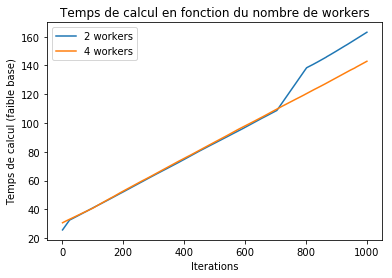

In [14]:
## Temps de calcul en fonction du nombre de workers (2 ou 4) dans la faible base

l1 = [25.78085994720459, 26.076119422912598, 26.360504388809204, 26.697453498840332, 27.013035535812378, 27.29788041114807, 27.576206922531128, 27.876586437225342, 28.197336435317993, 28.47729802131653, 28.761594772338867, 29.062242031097412, 29.346669912338257, 29.69937801361084, 29.978111743927002, 30.27760100364685, 30.562030792236328, 30.8466854095459, 31.163415670394897, 31.463988780975342, 31.748789310455322, 32.03362560272217, 32.317625522613525, 32.61856722831726, 32.71835422515869, 32.819154024124146, 32.919469118118286, 33.03499984741211, 33.13542604446411, 33.25137376785278, 33.366883754730225, 33.46669340133667, 33.58267569541931, 33.703166007995605, 33.80550813674927, 33.921385288238525, 34.021729946136475, 34.13716769218445, 34.23710250854492, 34.35262680053711, 34.452563524246216, 34.568018198013306, 34.66877031326294, 34.78405475616455, 34.90581750869751, 35.00596284866333, 35.105836629867554, 35.22156310081482, 35.33754801750183, 35.43694281578064, 35.552574157714844, 35.66819787025452, 35.772560119628906, 35.88399147987366, 36.00497317314148, 36.10578966140747, 36.22188997268677, 36.33765625953674, 36.45357060432434, 36.569523096084595, 36.66940116882324, 36.78536128997803, 36.90433669090271, 37.023321866989136, 37.12369132041931, 37.2392303943634, 37.33941459655762, 37.455323457717896, 37.57087445259094, 37.67114853858948, 37.786646127700806, 37.90207576751709, 38.008427143096924, 38.12410020828247, 38.224005699157715, 38.339582204818726, 38.43979549407959, 38.540077209472656, 38.670748472213745, 38.77064323425293, 38.88652539253235, 39.004194021224976, 39.10882878303528, 39.22449612617493, 39.32434821128845, 39.4403133392334, 39.55608344078064, 39.656434535980225, 39.77184343338013, 39.87215828895569, 39.97251534461975, 40.08839559555054, 40.18846774101257, 40.310245752334595, 40.4732940196991, 40.58877110481262, 40.70689249038696, 40.81023979187012, 40.91013693809509, 41.02612900733948, 41.12624907493591, 41.241880893707275, 41.34183621406555, 41.45765542984009, 41.57314419746399, 41.673465728759766, 41.789069414138794, 41.908610582351685, 42.010958671569824, 42.12671256065369, 42.24262475967407, 42.34228301048279, 42.44215512275696, 42.55807161331177, 42.673564434051514, 42.78899312019348, 42.88954138755798, 43.00811505317688, 43.11143517494202, 43.211381912231445, 43.32696318626404, 43.426961183547974, 43.542460918426514, 43.642627000808716, 43.75833010673523, 43.873783588409424, 43.97406625747681, 44.08960795402527, 44.189857006073, 44.3114755153656, 44.42726731300354, 44.52721071243286, 44.64302062988281, 44.742966413497925, 44.85858511924744, 44.97419190406799, 45.08979606628418, 45.211360692977905, 45.311362504959106, 45.427189111709595, 45.52716898918152, 45.642746448516846, 45.75865864753723, 45.858319997787476, 45.97395849227905, 46.089550495147705, 46.18984413146973, 46.29012989997864, 46.40807318687439, 46.51189827919006, 46.62797665596008, 46.743510723114014, 46.8590247631073, 46.95945692062378, 47.07513761520386, 47.2123076915741, 47.312519788742065, 47.42813324928284, 47.543670654296875, 47.659629344940186, 47.79082655906677, 47.90920972824097, 48.0125949382782, 48.128552198410034, 48.24432420730591, 48.359891176223755, 48.47562551498413, 48.611124992370605, 48.728902101516724, 48.84450554847717, 48.96007800102234, 49.07604384422302, 49.19194197654724, 49.29182529449463, 49.41206169128418, 49.51437330245972, 49.62989282608032, 49.7298686504364, 49.84571409225464, 49.94574785232544, 50.06164193153381, 50.177123069763184, 50.29264831542969, 50.41422367095947, 50.51411557197571, 50.62996792793274, 50.730305910110474, 50.8504204750061, 50.961886405944824, 51.06219506263733, 51.17815160751343, 51.27748727798462, 51.393290519714355, 51.4936158657074, 51.61007809638977, 51.715883016586304, 51.815943241119385, 51.94749879837036, 52.06300926208496, 52.162991762161255, 52.294184923172, 52.412819623947144, 52.516029357910156, 52.61607122421265, 52.747645139694214, 52.863444328308105, 52.96332550048828, 53.07879590988159, 53.195236682891846, 53.317254304885864, 53.433265209198, 53.54877209663391, 53.66426467895508, 53.7796995639801, 53.895695209503174, 54.017656564712524, 54.13321280479431, 54.249133348464966, 54.364699602127075, 54.480196714401245, 54.61288022994995, 54.71752691268921, 54.833696603775024, 54.949339389801025, 55.06495261192322, 55.18063020706177, 55.31442832946777, 55.417874336242676, 55.53400921821594, 55.64982748031616, 55.7701051235199, 55.88154363632202, 55.997068643569946, 56.11926865577698, 56.21858096122742, 56.35031485557556, 56.45066213607788, 56.56638026237488, 56.68189978599548, 56.797471046447754, 56.919426918029785, 57.03514790534973, 57.15105700492859, 57.26667094230652, 57.382476806640625, 57.49804639816284, 57.619614362716675, 57.720388412475586, 57.83591961860657, 57.93587279319763, 58.051814794540405, 58.15215849876404, 58.25192356109619, 58.36786198616028, 58.48379731178284, 58.59915065765381, 58.69910383224487, 58.820210456848145, 58.920756816864014, 59.02115082740784, 59.15272378921509, 59.252846002578735, 59.35273551940918, 59.483938217163086, 59.58424496650696, 59.7001519203186, 59.821829319000244, 59.93809986114502, 60.038381814956665, 60.15385317802429, 60.26943922042847, 60.385376930236816, 60.501036643981934, 60.622671127319336, 60.72255277633667, 60.85416030883789, 60.9697687625885, 61.08561420440674, 61.20149612426758, 61.32308340072632, 61.43909192085266, 61.55458617210388, 61.67010998725891, 61.76995491981506, 61.88544821739197, 62.02260899543762, 62.138262033462524, 62.254191398620605, 62.36979389190674, 62.48572540283203, 62.60162878036499, 62.701502323150635, 62.80183458328247, 62.92341709136963, 63.03933787345886, 63.15485906600952, 63.27033853530884, 63.370251417160034, 63.48586320877075, 63.60179352760315, 63.72422385215759, 63.840142488479614, 63.9401969909668, 64.05610585212708, 64.15644645690918, 64.272052526474, 64.38803935050964, 64.48803043365479, 64.6035635471344, 64.70340728759766, 64.82548379898071, 64.92581939697266, 65.04142546653748, 65.14135694503784, 65.25726175308228, 65.37278819084167, 65.47292613983154, 65.58866024017334, 65.68854665756226, 65.80867671966553, 65.92477011680603, 66.02610921859741, 66.14207100868225, 66.25800633430481, 66.3583357334137, 66.47396159172058, 66.58968472480774, 66.68997716903687, 66.78997611999512, 66.90549516677856, 67.02755331993103, 67.14318132400513, 67.24310851097107, 67.35853290557861, 67.45879602432251, 67.57474279403687, 67.69069385528564, 67.79099178314209, 67.90682768821716, 68.0067982673645, 68.12859654426575, 68.22867274284363, 68.34436750411987, 68.44464874267578, 68.56061482429504, 68.6765525341034, 68.7916738986969, 68.90759062767029, 69.0079255104065, 69.10785412788391, 69.22943234443665, 69.32973432540894, 69.4457802772522, 69.56136012077332, 69.66170120239258, 69.79259872436523, 69.8924548625946, 70.00805497169495, 70.10828256607056, 70.22998237609863, 70.34609317779541, 70.44595575332642, 70.56186962127686, 70.67694520950317, 70.78134822845459, 70.89322090148926, 71.00883674621582, 71.13024592399597, 71.23097515106201, 71.34710121154785, 71.46281599998474, 71.56312417984009, 71.67875266075134, 71.77873301506042, 71.91027092933655, 72.01019072532654, 72.1320412158966, 72.2483913898468, 72.34835720062256, 72.46404194831848, 72.57983207702637, 72.69574999809265, 72.79562067985535, 72.89589667320251, 73.02935194969177, 73.1493992805481, 73.26485276222229, 73.36521339416504, 73.4963264465332, 73.61177229881287, 73.73445248603821, 73.8342559337616, 73.95014691352844, 74.0500156879425, 74.15017008781433, 74.28169322013855, 74.3811182975769, 74.49729800224304, 74.6128146648407, 74.7330994606018, 74.85069227218628, 74.96622085571289, 75.08167433738708, 75.19727802276611, 75.33121967315674, 75.45056295394897, 75.56628894805908, 75.6818859577179, 75.78630661964417, 75.9173219203949, 76.05059766769409, 76.16623878479004, 76.2663745880127, 76.38191342353821, 76.49740028381348, 76.63504910469055, 76.7350025177002, 76.8509509563446, 76.96650099754333, 77.08220911026001, 77.21331143379211, 77.33445048332214, 77.43577432632446, 77.55219841003418, 77.66783571243286, 77.79936575889587, 77.91468620300293, 78.0332236289978, 78.13651156425476, 78.25244665145874, 78.36838626861572, 78.48417639732361, 78.59969592094421, 78.7156310081482, 78.83787155151367, 78.95381355285645, 79.06933808326721, 79.18482971191406, 79.30032110214233, 79.41574692726135, 79.53786492347717, 79.65342259407043, 79.75372314453125, 79.86937952041626, 79.96943187713623, 80.0851263999939, 80.20068502426147, 80.30093336105347, 80.41643953323364, 80.51644229888916, 80.63802075386047, 80.75468516349792, 80.85386610031128, 80.9692816734314, 81.07004570960999, 81.1856141090393, 81.30155515670776, 81.40187788009644, 81.51783466339111, 81.61727499961853, 81.73931574821472, 81.83915758132935, 81.9551510810852, 82.05509614944458, 82.17074203491211, 82.2863118648529, 82.38662719726562, 82.5021378993988, 82.60195779800415, 82.70174527168274, 82.8181722164154, 82.91833472251892, 83.01821398735046, 83.13529944419861, 83.24012541770935, 83.40286588668823, 83.51830530166626, 83.61835932731628, 83.73421573638916, 83.84008359909058, 83.94004607200623, 84.04012417793274, 84.15598845481873, 84.25592255592346, 84.37155151367188, 84.47180771827698, 84.58750343322754, 84.70347833633423, 84.80357360839844, 84.90347480773926, 85.01896214485168, 85.14061117172241, 85.24097919464111, 85.34075951576233, 85.45671510696411, 85.55683445930481, 85.6725423336029, 85.77706217765808, 85.88804912567139, 85.98798060417175, 86.10361838340759, 86.21960496902466, 86.3396418094635, 86.44061279296875, 86.55665516853333, 86.65694212913513, 86.77237486839294, 86.88790464401245, 86.98775625228882, 87.10330080986023, 87.20312881469727, 87.31883764266968, 87.44039130210876, 87.54064726829529, 87.65693736076355, 87.75642013549805, 87.871999502182, 87.97184562683105, 88.08733582496643, 88.20371699333191, 88.30381655693054, 88.4196343421936, 88.51997876167297, 88.63789796829224, 88.74224543571472, 88.84245252609253, 88.95831513404846, 89.058269739151, 89.17418622970581, 89.27414226531982, 89.38971781730652, 89.50546169281006, 89.60579919815063, 89.72118949890137, 89.83871459960938, 89.94303345680237, 90.04299068450928, 90.15876960754395, 90.25868797302246, 90.37418603897095, 90.47447085380554, 90.59042954444885, 90.70634460449219, 90.81095242500305, 90.94221711158752, 91.04401731491089, 91.16002011299133, 91.27589821815491, 91.39149737358093, 91.49169754981995, 91.60763883590698, 91.72285270690918, 91.82275819778442, 91.94126152992249, 92.04463410377502, 92.14530873298645, 92.26121854782104, 92.36154770851135, 92.47742509841919, 92.59300518035889, 92.70846700668335, 92.80845808982849, 92.90834021568298, 93.00826358795166, 93.12390327453613, 93.2242603302002, 93.34535646438599, 93.44548487663269, 93.56135153770447, 93.67729377746582, 93.77675914764404, 93.89269590377808, 94.00864052772522, 94.10872411727905, 94.22427082061768, 94.32433724403381, 94.44083070755005, 94.54670071601868, 94.64650511741638, 94.7623279094696, 94.86222290992737, 94.99371314048767, 95.09393692016602, 95.19416093826294, 95.32524704933167, 95.42565321922302, 95.54521203041077, 95.64715814590454, 95.747079372406, 95.8632583618164, 95.9635763168335, 96.07943320274353, 96.19537472724915, 96.29476833343506, 96.4103615283966, 96.51028943061829, 96.62600255012512, 96.74328756332397, 96.84809851646423, 96.94881510734558, 97.04860806465149, 97.18054676055908, 97.29634642601013, 97.41207647323608, 97.51193642616272, 97.62743902206421, 97.74919009208679, 97.86470818519592, 97.98034858703613, 98.09625673294067, 98.211909532547, 98.34948968887329, 98.4502739906311, 98.56618547439575, 98.68164896965027, 98.78132724761963, 98.9182448387146, 99.04532265663147, 99.15013480186462, 99.26619720458984, 99.38130474090576, 99.51268243789673, 99.62860751152039, 99.75012922286987, 99.86620831489563, 99.96629071235657, 100.09753751754761, 100.21313095092773, 100.32864332199097, 100.42864322662354, 100.54806327819824, 100.6823844909668, 100.80234289169312, 100.91825866699219, 101.0296893119812, 101.14846849441528, 101.26717185974121, 101.38265061378479, 101.48254752159119, 101.61394882202148, 101.72945618629456, 101.85141086578369, 101.9670057296753, 102.08266949653625, 102.19861173629761, 102.31418323516846, 102.4514217376709, 102.55142998695374, 102.65150928497314, 102.76737451553345, 102.86766648292542, 102.96763396263123, 103.08347129821777, 103.18377470970154, 103.29934048652649, 103.39936327934265, 103.49972200393677, 103.6152892112732, 103.71550130844116, 103.83120727539062, 103.94765520095825, 104.05350971221924, 104.15328907966614, 104.26911401748657, 104.384605884552, 104.48495292663574, 104.60082721710205, 104.7164695262909, 104.83225417137146, 104.9321939945221, 105.03213357925415, 105.15382170677185, 105.2542233467102, 105.36934351921082, 105.4848301410675, 105.60034370422363, 105.71576142311096, 105.8208863735199, 105.9163281917572, 106.0322778224945, 106.15405321121216, 106.26996302604675, 106.38554048538208, 106.50116753578186, 106.61665153503418, 106.73207497596741, 106.8536787033081, 106.96932721138, 107.0852882862091, 107.20116329193115, 107.30121040344238, 107.41675782203674, 107.53235220909119, 107.63271737098694, 107.7321228981018, 107.85060214996338, 107.95396566390991, 108.06906914710999, 108.16931700706482, 108.28522801399231, 108.38506364822388, 108.50056028366089, 108.60046792030334, 108.70047640800476, 108.9318835735321, 109.20109105110168, 109.5167191028595, 109.8175859451294, 110.134202003479, 110.41852140426636, 110.71902894973755, 111.05160856246948, 111.35423302650452, 111.63655591011047, 111.95884776115417, 112.25827980041504, 112.57577252388, 112.87638735771179, 113.17683172225952, 113.47744178771973, 113.7779290676117, 114.10961270332336, 114.41034460067749, 114.71064162254333, 115.02674412727356, 115.32710552215576, 115.6589708328247, 115.94363713264465, 116.24400854110718, 116.52929353713989, 116.83026552200317, 117.14655637741089, 117.44611287117004, 117.74660301208496, 118.06610417366028, 118.34788203239441, 118.66944003105164, 118.97056674957275, 119.27153730392456, 119.54990983009338, 119.84984540939331, 120.17254424095154, 120.47217321395874, 120.77039170265198, 121.0893988609314, 121.38992762565613, 121.70598554611206, 121.99097180366516, 122.29092764854431, 122.59133672714233, 122.89223337173462, 123.20836091041565, 123.52477669715881, 123.82463002204895, 124.14102530479431, 124.44200396537781, 124.75835919380188, 125.05810523033142, 125.34269976615906, 125.64295983314514, 125.92773747444153, 126.24381375312805, 126.54465460777283, 126.8451988697052, 127.18141078948975, 127.47739624977112, 127.79986047744751, 128.100182056427, 128.38475370407104, 128.6846067905426, 128.98480606079102, 129.30133247375488, 129.60198712348938, 129.8861265182495, 130.2186267375946, 130.51893019676208, 130.83407306671143, 131.13486766815186, 131.43487930297852, 131.7201361656189, 132.02049827575684, 132.33636593818665, 132.63637161254883, 132.92103600502014, 133.25306272506714, 133.5529808998108, 133.8686978816986, 134.16803002357483, 134.46790766716003, 134.76789808273315, 135.05271124839783, 135.38589215278625, 135.66995429992676, 135.97050189971924, 136.29271149635315, 136.59348821640015, 136.90947699546814, 137.22558283805847, 137.51003694534302, 137.79292392730713, 138.0725815296173, 138.37220430374146, 138.52549529075623, 138.6254301071167, 138.7409315109253, 138.84082984924316, 138.95676016807556, 139.071959733963, 139.17197561264038, 139.27200531959534, 139.38809657096863, 139.4935245513916, 139.60960459709167, 139.7254078388214, 139.84661388397217, 139.94142127037048, 140.05728244781494, 140.15718841552734, 140.27281832695007, 140.3728528022766, 140.4731364250183, 140.59423089027405, 140.69506001472473, 140.7953405380249, 140.92640662193298, 141.02689242362976, 141.15827083587646, 141.27370882034302, 141.39569234848022, 141.49605631828308, 141.61199808120728, 141.74306750297546, 141.843909740448, 141.9594748020172, 142.07498264312744, 142.1906337738037, 142.31266069412231, 142.42812371253967, 142.52843737602234, 142.64397859573364, 142.75947380065918, 142.8753674030304, 142.99743938446045, 143.11298060417175, 143.22849249839783, 143.3443853855133, 143.4602541923523, 143.57607579231262, 143.69774413108826, 143.79761123657227, 143.91325497627258, 144.044691324234, 144.1601963043213, 144.25999212265015, 144.37597799301147, 144.49596691131592, 144.61402082443237, 144.7140130996704, 144.82978582382202, 144.930104970932, 145.03004932403564, 145.14558029174805, 145.24560570716858, 145.36155080795288, 145.4614441394806, 145.73066592216492, 145.93078351020813, 146.04626297950745, 146.16198873519897, 146.2991189956665, 146.41515111923218, 146.53089714050293, 146.64662551879883, 146.778217792511, 146.91524839401245, 147.03096890449524, 147.14693403244019, 147.26248121261597, 147.4005880355835, 147.51654720306396, 147.63243055343628, 147.76397919654846, 147.87973308563232, 148.01740884780884, 148.1489725112915, 148.26477932929993, 148.39738178253174, 148.51793265342712, 148.63345861434937, 148.7647306919098, 148.8802890777588, 149.00227403640747, 149.1339819431305, 149.2653408050537, 149.38092350959778, 149.503431558609, 149.61918425559998, 149.75025844573975, 149.90349650382996, 150.01923370361328, 150.15081238746643, 150.28282070159912, 150.42053031921387, 150.55172061920166, 150.68328380584717, 150.82096934318542, 150.9521608352661, 151.0832600593567, 151.22044396400452, 151.3520405292511, 151.48315691947937, 151.6056170463562, 151.73704409599304, 151.88424229621887, 152.02205610275269, 152.15359449386597, 152.2691707611084, 152.4038097858429, 152.52278685569763, 152.62266421318054, 152.75408291816711, 152.8695092201233, 153.00541591644287, 153.12295508384705, 153.25418663024902, 153.36986756324768, 153.48577642440796, 153.6076033115387, 153.7548794746399, 153.8701114654541, 153.98560285568237, 154.10811686515808, 154.23968410491943, 154.3704218864441, 154.48603224754333, 154.6077265739441, 154.73967599868774, 154.85513472557068, 154.98622703552246, 155.10813903808594, 155.23978900909424, 155.37133884429932, 155.507470369339, 155.6404037475586, 155.77604055404663, 155.9065806865692, 156.02508211135864, 156.1563286781311, 156.30716347694397, 156.42519879341125, 156.556809425354, 156.68785619735718, 156.82576370239258, 156.95687198638916, 157.10409021377563, 157.22618770599365, 157.3573887348175, 157.48846554756165, 157.6257164478302, 157.7568895816803, 157.88847541809082, 158.02607488632202, 158.15764141082764, 158.28890371322632, 158.42680978775024, 158.55797171592712, 158.68913292884827, 158.81106114387512, 158.9739556312561, 159.08990335464478, 159.2275586128235, 159.35906720161438, 159.49042773246765, 159.6279513835907, 159.75909090042114, 159.89086031913757, 160.02854084968567, 160.15970492362976, 160.31294012069702, 160.44431138038635, 160.57588148117065, 160.70742344856262, 160.82974767684937, 160.97693848609924, 161.11427783966064, 161.23020839691162, 161.36177229881287, 161.49284291267395, 161.63095784187317, 161.76206421852112, 161.89363026618958, 162.03136444091797, 162.16247510910034, 162.3130693435669, 162.44719219207764, 162.56270027160645, 162.67816996574402, 162.81033277511597, 162.94703149795532, 163.078595161438]
l2 = [30.753907203674316, 30.869827270507812, 30.984838008880615, 31.100284814834595, 31.200536727905273, 31.320492029190063, 31.4219069480896, 31.52186870574951, 31.637776136398315, 31.737567901611328, 31.83792233467102, 31.953436851501465, 32.05372762680054, 32.15354585647583, 32.25335693359375, 32.36928153038025, 32.469186782836914, 32.568973779678345, 32.65371823310852, 32.73815369606018, 32.8379430770874, 32.93823957443237, 33.03855872154236, 33.13846254348755, 33.23825120925903, 33.33855581283569, 33.438374280929565, 33.53873896598816, 33.65465068817139, 33.75453567504883, 33.8545286655426, 33.95462155342102, 34.05457329750061, 34.17029356956482, 34.27028489112854, 34.370126247406006, 34.46997880935669, 34.569984674453735, 34.65461087226868, 34.75489640235901, 34.854857206344604, 34.955140829086304, 35.055054903030396, 35.154913902282715, 35.25501012802124, 35.35945725440979, 35.470431327819824, 35.570273876190186, 35.67009401321411, 35.77043533325195, 35.87033796310425, 35.97049570083618, 36.08594250679016, 36.1857385635376, 36.28653573989868, 36.386359453201294, 36.48620319366455, 36.586042404174805, 36.68624424934387, 36.78614664077759, 36.88593149185181, 36.9863805770874, 37.10230541229248, 37.20214295387268, 37.30197501182556, 37.402005434036255, 37.520355224609375, 37.623695373535156, 37.72307300567627, 37.82341432571411, 37.920485973358154, 38.0236234664917, 38.12359094619751, 38.22421431541443, 38.32400965690613, 38.423879861831665, 38.523959159851074, 38.62392783164978, 38.72376227378845, 38.823994874954224, 38.924071073532104, 39.03959631919861, 39.12375068664551, 39.23943495750427, 39.32357335090637, 39.42345952987671, 39.52357244491577, 39.62050437927246, 39.70177865028381, 39.78596210479736, 39.870203256607056, 39.98567342758179, 40.08557415008545, 40.185556411743164, 40.35605549812317, 40.45457100868225, 40.55450105667114, 40.639161586761475, 40.723312854766846, 40.83920216560364, 40.95513033866882, 41.070857763290405, 41.186766386032104, 41.32402467727661, 41.44031572341919, 41.57094478607178, 41.68644833564758, 41.78687858581543, 41.924031257629395, 42.0556914806366, 42.187198638916016, 42.319021224975586, 42.42459583282471, 42.55580711364746, 42.671340227127075, 42.78727984428406, 42.92439150810242, 43.04076051712036, 43.17226815223694, 43.288230419158936, 43.40384602546692, 43.50391745567322, 43.60375261306763, 43.74153685569763, 43.85708498954773, 43.98818755149841, 44.10392904281616, 44.20424556732178, 44.326321601867676, 44.44183111190796, 44.557708978652954, 44.673649311065674, 44.80517864227295, 44.94244432449341, 45.05791711807251, 45.1736204624176, 45.30521774291992, 45.42688989639282, 45.542519330978394, 45.658040046691895, 45.75809288024902, 45.87402868270874, 45.9897825717926, 46.12530159950256, 46.22762417793274, 46.343663454055786, 46.4592809677124, 46.575289249420166, 46.70679593086243, 46.82496643066406, 46.929200649261475, 47.060269832611084, 47.17615365982056, 47.2920446395874, 47.426859617233276, 47.52974891662598, 47.64543271064758, 47.760899782180786, 47.876673221588135, 47.976552963256836, 48.09225869178772, 48.19257068634033, 48.30776786804199, 48.42922806739807, 48.53011894226074, 48.66122221946716, 48.77714157104492, 48.89276456832886, 49.02994155883789, 49.14608931541443, 49.2619411945343, 49.361870765686035, 49.47745704650879, 49.60857820510864, 49.73055696487427, 49.846593379974365, 49.97814679145813, 50.09326505661011, 50.230820178985596, 50.35098838806152, 50.46237635612488, 50.578311920166016, 50.70944905281067, 50.84718203544617, 50.962859869003296, 51.078343868255615, 51.19379019737244, 51.32801628112793, 51.44799518585205, 51.56393361091614, 51.69552445411682, 51.811034202575684, 51.93257403373718, 52.04826474189758, 52.1481831073761, 52.26384615898132, 52.36400604248047, 52.463937759399414, 52.57979488372803, 52.69558668136597, 52.79550838470459, 52.89543104171753, 53.028117418289185, 53.1642005443573, 53.279669523239136, 53.3953332901001, 53.51080250740051, 53.61113429069519, 53.73296499252319, 53.833457231521606, 53.94922471046448, 54.04916191101074, 54.164729833602905, 54.29629635810852, 54.41211938858032, 54.53065347671509, 54.63397765159607, 54.749961614608765, 54.86574745178223, 54.9812867641449, 55.09714436531067, 55.213062047958374, 55.328540563583374, 55.4509162902832, 55.56653547286987, 55.68211603164673, 55.79763340950012, 55.93220043182373, 56.050732135772705, 56.16667413711548, 56.28209114074707, 56.39807963371277, 56.51367139816284, 56.65117406845093, 56.76708364486694, 56.88256788253784, 56.99826169013977, 57.0981228351593, 57.21812725067139, 57.335110902786255, 57.45129370689392, 57.567145109176636, 57.66723275184631, 57.79839301109314, 57.91434073448181, 58.03627800941467, 58.13705229759216, 58.253005266189575, 58.36849594116211, 58.48401618003845, 58.583860874176025, 58.69931602478027, 58.81542086601257, 58.936885356903076, 59.052807092666626, 59.152705907821655, 59.26866388320923, 59.38459587097168, 59.500519037246704, 59.59996843338013, 59.715922355651855, 59.81623721122742, 59.916184186935425, 60.03864288330078, 60.15460181236267, 60.25396275520325, 60.35838460922241, 60.469847440719604, 60.56923174858093, 60.68477940559387, 60.7851300239563, 60.90101099014282, 61.00083684921265, 61.11660599708557, 61.23377704620361, 61.33859300613403, 61.43913722038269, 61.53917908668518, 61.67073106765747, 61.78648352622986, 61.886592864990234, 62.00212550163269, 62.10239601135254, 62.21796154975891, 62.31784653663635, 62.439486026763916, 62.53991174697876, 62.65559506416321, 62.78712320327759, 62.887141942977905, 62.98745632171631, 63.10296964645386, 63.21844935417175, 63.35616946220398, 63.47164845466614, 63.58763575553894, 63.70318055152893, 63.81908917427063, 63.94064474105835, 64.04114317893982, 64.15709662437439, 64.27277207374573, 64.38827300071716, 64.50421500205994, 64.63741254806519, 64.74085593223572, 64.85679531097412, 64.97227644920349, 65.0879156589508, 65.2035641670227, 65.31921482086182, 65.44170951843262, 65.55717206001282, 65.68843483924866, 65.80393505096436, 65.9196355342865, 66.03759336471558, 66.14189863204956, 66.27352166175842, 66.38899993896484, 66.50494146347046, 66.61988854408264, 66.73730444908142, 66.85826539993286, 66.97394728660583, 67.0742928981781, 67.19012928009033, 67.28992772102356, 67.4058928489685, 67.52138996124268, 67.64081883430481, 67.74326229095459, 67.85928654670715, 67.9831953048706, 68.1064031124115, 68.22231435775757, 68.33926129341125, 68.44440698623657, 68.5758912563324, 68.6914451122284, 68.80734157562256, 68.90765428543091, 69.02359890937805, 69.16119885444641, 69.27706289291382, 69.39251565933228, 69.49327397346497, 69.60872650146484, 69.7459328174591, 69.86247205734253, 69.96277165412903, 70.0778751373291, 70.19351172447205, 70.32507944107056, 70.44342136383057, 70.54743146896362, 70.66285729408264, 70.76367259025574, 70.89524126052856, 70.99482536315918, 71.11076784133911, 71.22622680664062, 71.3431077003479, 71.46382308006287, 71.57955193519592, 71.69500231742859, 71.79524683952332, 71.91121673583984, 72.04713582992554, 72.14898633956909, 72.26492738723755, 72.36504673957825, 72.4809832572937, 72.59643769264221, 72.71213221549988, 72.8280656337738, 72.9279055595398, 73.04963278770447, 73.14982509613037, 73.2655131816864, 73.3655014038086, 73.48102903366089, 73.58095407485962, 73.6963701248169, 73.81182193756104, 73.92736840248108, 74.02770066261292, 74.12748789787292, 74.24894833564758, 74.34896564483643, 74.46512722969055, 74.56498408317566, 74.6805489063263, 74.812096118927, 74.927659034729, 75.04924416542053, 75.16532301902771, 75.26557207107544, 75.39717411994934, 75.4974889755249, 75.59753441810608, 75.71328067779541, 75.81344962120056, 75.92907500267029, 76.05071949958801, 76.1511914730072, 76.2509765625, 76.35105037689209, 76.46685671806335, 76.5668077468872, 76.68231797218323, 76.78216624259949, 76.88210272789001, 77.01347517967224, 77.11347937583923, 77.21328067779541, 77.32875394821167, 77.42905473709106, 77.52893996238708, 77.65051174163818, 77.75042748451233, 77.85040950775146, 77.96633768081665, 78.08184766769409, 78.1818037033081, 78.29732084274292, 78.3971643447876, 78.51266717910767, 78.62814807891846, 78.74986243247986, 78.86602354049683, 78.9815948009491, 79.08167028427124, 79.21308946609497, 79.32893133163452, 79.45135998725891, 79.56688976287842, 79.68264126777649, 79.7985770702362, 79.91456317901611, 80.03044056892395, 80.13075351715088, 80.25265336036682, 80.38429164886475, 80.49979615211487, 80.61573052406311, 80.7156126499176, 80.83127546310425, 80.95332193374634, 81.06885409355164, 81.1847665309906, 81.30020666122437, 81.41581344604492, 81.54959726333618, 81.65340113639832, 81.76942586898804, 81.86943483352661, 81.98496007919312, 82.11634278297424, 82.22073769569397, 82.33173108100891, 82.43194246292114, 82.55229473114014, 82.66978001594543, 82.7854437828064, 82.88523459434509, 83.00150036811829, 83.10139727592468, 83.2173376083374, 83.33301377296448, 83.4331603050232, 83.55420446395874, 83.65505409240723, 83.78659009933472, 83.9021520614624, 84.01806259155273, 84.13400053977966, 84.23429346084595, 84.35537934303284, 84.47104120254517, 84.58664202690125, 84.7023184299469, 84.81796288490295, 84.97080063819885, 85.08628106117249, 85.20187401771545, 85.3176679611206, 85.4329526424408, 85.53288173675537, 85.65510773658752, 85.75494980812073, 85.87047910690308, 85.98594856262207, 86.10185933113098, 86.20203518867493, 86.31794023513794, 86.4178569316864, 86.53384208679199, 86.63410711288452, 86.74954533576965, 86.85589623451233, 86.95582938194275, 87.07156586647034, 87.1869900226593, 87.28754043579102, 87.40301203727722, 87.50332951545715, 87.60364270210266, 87.71921730041504, 87.83522176742554, 87.95672345161438, 88.07280230522156, 88.18843364715576, 88.3195493221283, 88.42967438697815, 88.53507113456726, 88.65710043907166, 88.77277636528015, 88.88872265815735, 89.00425839424133, 89.11983633041382, 89.23530173301697, 89.33596181869507, 89.45754909515381, 89.55798721313477, 89.67397880554199, 89.77333545684814, 89.88927292823792, 90.0047607421875, 90.10466766357422, 90.22062039375305, 90.32009959220886, 90.41992783546448, 90.55743408203125, 90.65756464004517, 90.77354025840759, 90.88936138153076, 91.00522470474243, 91.12079644203186, 91.23664927482605, 91.35549831390381, 91.45882630348206, 91.55862855911255, 91.69032526016235, 91.80534410476685, 91.92124843597412, 92.03666615486145, 92.1561906337738, 92.27473831176758, 92.39038825035095, 92.5058479309082, 92.621333360672, 92.75801348686218, 92.87495994567871, 93.0592565536499, 93.1748514175415, 93.27539610862732, 93.39127993583679, 93.49121689796448, 93.60690760612488, 93.72279691696167, 93.83867621421814, 93.95862054824829, 94.06114983558655, 94.17637991905212, 94.29188013076782, 94.42324233055115, 94.53874087333679, 94.63902354240417, 94.7393901348114, 94.86111235618591, 94.96044921875, 95.06066823005676, 95.17631983757019, 95.27664089202881, 95.39253354072571, 95.50762271881104, 95.62316393852234, 95.72306084632874, 95.8389675617218, 95.96092319488525, 96.07650566101074, 96.17718434333801, 96.29287886619568, 96.39319086074829, 96.50896430015564, 96.62491011619568, 96.72484683990479, 96.84036159515381, 96.96230983734131, 97.0785903930664, 97.1784074306488, 97.27869009971619, 97.37858295440674, 97.47850441932678, 97.59426712989807, 97.71020936965942, 97.81022834777832, 97.925865650177, 98.02614760398865, 98.14171361923218, 98.24159669876099, 98.36013722419739, 98.46211051940918, 98.56315326690674, 98.67880201339722, 98.7789556980133, 98.89492392539978, 98.99483323097229, 99.09476923942566, 99.2103500366211, 99.31063604354858, 99.42657780647278, 99.52686810493469, 99.6424310207367, 99.76228761672974, 99.8643057346344, 99.96423554420471, 100.08004903793335, 100.19598174095154, 100.2957022190094, 100.41156506538391, 100.51110601425171, 100.61139702796936, 100.72684931755066, 100.8418869972229, 100.94178128242493, 101.06330180168152, 101.16367983818054, 101.27922177314758, 101.39468932151794, 101.51018714904785, 101.61013865470886, 101.7260639667511, 101.8414888381958, 101.9634804725647, 102.07907748222351, 102.17895102500916, 102.29461622238159, 102.39451384544373, 102.51003646850586, 102.61006760597229, 102.71007204055786, 102.82565832138062, 102.94149851799011, 103.06308054924011, 103.17903304100037, 103.27896904945374, 103.39447402954102, 103.49460697174072, 103.61015343666077, 103.72607421875, 103.84146571159363, 103.94141864776611, 104.06314826011658, 104.16305923461914, 104.27877497673035, 104.37908983230591, 104.49467182159424, 104.5947151184082, 104.71024370193481, 104.81023621559143, 104.92615556716919, 105.0259792804718, 105.14197134971619, 105.2640278339386, 105.37970924377441, 105.49528336524963, 105.61122870445251, 105.72669172286987, 105.86430668830872, 105.98022437095642, 106.08013772964478, 106.21128964424133, 106.32721471786499, 106.46436500549316, 106.58044171333313, 106.69598984718323, 106.81196403503418, 106.91222834587097, 107.04379463195801, 107.14409875869751, 107.24852514266968, 107.36646008491516, 107.48240566253662, 107.61312985420227, 107.7287392616272, 107.82902407646179, 107.944571018219, 108.06549406051636, 108.18217396736145, 108.29769730567932, 108.41323781013489, 108.5131139755249, 108.62859845161438, 108.7606725692749, 108.8664972782135, 108.98270583152771, 109.09837102890015, 109.21399474143982, 109.32956290245056, 109.445143699646, 109.56445217132568, 109.66773128509521, 109.78334760665894, 109.914555311203, 110.0304958820343, 110.1464204788208, 110.24629664421082, 110.36869883537292, 110.4843955039978, 110.60033464431763, 110.71549367904663, 110.83096146583557, 110.94644784927368, 111.06753993034363, 111.16791343688965, 111.26853084564209, 111.38413786888123, 111.48411250114441, 111.5998604297638, 111.69982886314392, 111.81540870666504, 111.91540622711182, 112.0309739112854, 112.14658832550049, 112.24647998809814, 112.34639191627502, 112.46499466896057, 112.56823563575745, 112.68394184112549, 112.79967975616455, 112.89964294433594, 113.01536393165588, 113.11526989936829, 113.24643540382385, 113.34634280204773, 113.4668402671814, 113.56864309310913, 113.66842412948608, 113.7845549583435, 113.90008497238159, 114.00042867660522, 114.1002459526062, 114.21611166000366, 114.33154821395874, 114.4315288066864, 114.54708075523376, 114.64725279808044, 114.76808404922485, 114.86940622329712, 115.00098371505737, 115.10106778144836, 115.20137906074524, 115.31731486320496, 115.41719031333923, 115.53272342681885, 115.63269686698914, 115.74812340736389, 115.87013626098633, 115.97004103660583, 116.08558797836304, 116.18587684631348, 116.30160331726074, 116.40168476104736, 116.51761531829834, 116.63356351852417, 116.7490963935852, 116.8494508266449, 116.96610927581787, 117.0709936618805, 117.17083597183228, 117.28648042678833, 117.38640832901001, 117.48633766174316, 117.60218501091003, 117.7022156715393, 117.80274033546448, 117.91816020011902, 118.0184063911438, 118.13434147834778, 118.25027966499329, 118.3501923084259, 118.4500663280487, 118.57227087020874, 118.68783974647522, 118.80334901809692, 118.90343642234802, 119.01900672912598, 119.119060754776, 119.23500418663025, 119.3349347114563, 119.45086765289307, 119.55087637901306, 119.67290425300598, 119.80473017692566, 119.92061424255371, 120.03629064559937, 120.13625383377075, 120.25179839134216, 120.38944864273071, 120.48933172225952, 120.605295419693, 120.72122693061829, 120.85234260559082, 120.97383832931519, 121.08965158462524, 121.19011545181274, 121.30572175979614, 121.42163920402527, 121.5371835231781, 121.65282726287842, 121.77441835403442, 121.89055180549622, 121.99056243896484, 122.12190413475037, 122.22178196907043, 122.32215356826782, 122.43809270858765, 122.53840184211731, 122.65393304824829, 122.75420594215393, 122.87216114997864, 122.97450828552246, 123.07629036903381, 123.19205355644226, 123.29215574264526, 123.40787053108215, 123.50807547569275, 123.62366604804993, 123.72402000427246, 123.8395619392395, 123.93955087661743, 124.03946924209595, 124.15498495101929, 124.27650952339172, 124.37722873687744, 124.49307179450989, 124.59332942962646, 124.69368600845337, 124.80961966514587, 124.90993309020996, 125.02566170692444, 125.12597513198853, 125.24122285842896, 125.36125087738037, 125.45699214935303, 125.57444214820862, 125.67881274223328, 125.77871584892273, 125.87864303588867, 125.9942479133606, 126.09426784515381, 126.21024775505066, 126.31056571006775, 126.44165825843811, 126.54188203811646, 126.65770220756531, 126.77819204330444, 126.87909984588623, 127.01036095619202, 127.12627267837524, 127.2261049747467, 127.3263885974884, 127.42669677734375, 127.55823373794556, 127.67924451828003, 127.78002905845642, 127.89647102355957, 127.9963800907135, 128.12797856330872, 128.2277753353119, 128.35888767242432, 128.47496223449707, 128.58034443855286, 128.71200585365295, 128.82772827148438, 128.94320678710938, 129.04305458068848, 129.15883255004883, 129.28082966804504, 129.39676928520203, 129.49685406684875, 129.61275935173035, 129.72866773605347, 129.8601770401001, 129.96026229858398, 130.08173775672913, 130.19768595695496, 130.3132083415985, 130.42888021469116, 130.54437518119812, 130.65986132621765, 130.77736973762512, 130.89733219146729, 131.0131287574768, 131.1287169456482, 131.2442045211792, 131.35981488227844, 131.4783959388733, 131.5973482131958, 131.69720315933228, 131.81288146972656, 131.92841124534607, 132.04409313201904, 132.18082237243652, 132.28165864944458, 132.39797377586365, 132.51363039016724, 132.6292622089386, 132.74472904205322, 132.87712955474854, 132.98253464698792, 133.09805727005005, 133.21399927139282, 133.32955145835876, 133.44509077072144, 133.56063437461853, 133.68058609962463, 133.78264546394348, 133.9142143726349, 134.02985906600952, 134.14534735679626, 134.24523425102234, 134.36114501953125, 134.48264408111572, 134.59829092025757, 134.7138171195984, 134.82935667037964, 134.94484663009644, 135.06061267852783, 135.18265104293823, 135.29825282096863, 135.39813017845154, 135.54532647132874, 135.76091146469116, 135.8768265247345, 135.9816517829895, 136.06179189682007, 136.16207718849182, 136.28104305267334, 136.37921166419983, 136.485009431839, 136.58529329299927, 136.68557620048523, 136.78495931625366, 136.8850018978119, 136.97973346710205, 137.0637562274933, 137.16613388061523, 137.26640105247498, 137.36618423461914, 137.45828104019165, 137.56066989898682, 137.66397190093994, 137.814147233963, 137.93006134033203, 138.0303418636322, 138.1306176185608, 138.23089122772217, 138.3846151828766, 138.56954216957092, 138.66932892799377, 138.76986646652222, 138.88578033447266, 138.98606538772583, 139.10200357437134, 139.20228815078735, 139.3180112838745, 139.43347716331482, 139.54897332191467, 139.67116832733154, 139.78660678863525, 139.90262961387634, 140.03371691703796, 140.14915823936462, 140.2711465358734, 140.387277841568, 140.50306916236877, 140.6185507774353, 140.7344777584076, 140.8504695892334, 140.96847224235535, 141.0721516609192, 141.18835139274597, 141.30428862571716, 141.43538737297058, 141.53526163101196, 141.66846632957458, 141.77274799346924, 141.8884515762329, 142.01952195167542, 142.13552689552307, 142.2359504699707, 142.3518705368042, 142.47359561920166, 142.58931279182434, 142.70519638061523, 142.82042598724365, 142.9212155342102]

y1 = plt.plot(list_iter, l1, label ='2 workers')
y2 = plt.plot(list_iter, l2, label='4 workers')
plt.legend( loc='upper left', numpoints = 1 )
plt.xlabel('Iterations')
plt.ylabel('Temps de calcul (faible base)')
plt.title('Temps de calcul en fonction du nombre de workers')
plt.show()

In [9]:
l3_small = DSGD(1000, 4, 1000, 1, 0.1)

[8.046968460083008, 8.431196928024292, 8.763111352920532, 9.109402656555176, 9.446686029434204, 9.77793550491333, 10.194197654724121, 10.532560110092163, 10.879488945007324, 11.210350036621094, 11.54801344871521, 11.910101413726807, 12.248919010162354, 12.579752683639526, 12.910592079162598, 13.248211145401001, 13.647640466690063, 13.978821516036987, 14.311136245727539, 14.648552179336548, 14.979838132858276, 15.34854006767273, 15.67985987663269, 16.01165223121643, 16.350517511367798, 16.682765245437622, 17.08315920829773, 17.417017698287964, 17.758445739746094, 18.0838303565979, 18.415643453598022, 18.78429675102234, 19.11611318588257, 19.454017877578735, 19.770195484161377, 20.11763596534729, 20.518062591552734, 20.856419563293457, 21.188725233078003, 21.520540475845337, 21.857478380203247, 22.220547437667847, 22.55892539024353, 22.89065170288086, 23.206934690475464, 23.560088872909546, 23.960127592086792, 24.291500329971313, 24.63958215713501, 24.959617137908936, 25.30633306503296, 

In [10]:
l4_small = DSGD(10000, 4, 1000, 1, 0.1)

[8.31306004524231, 8.678943872451782, 9.030767440795898, 9.362943649291992, 9.701188325881958, 10.033099889755249, 10.449357748031616, 10.80335259437561, 11.135560274124146, 11.467747688293457, 11.806362628936768, 12.169384479522705, 12.507614374160767, 12.839351892471313, 13.171255826950073, 13.51002812385559, 13.92606258392334, 14.257852554321289, 14.595927953720093, 14.912277460098267, 15.244318723678589, 15.613857507705688, 15.961276531219482, 16.297280073165894, 16.615029335021973, 16.96288824081421, 17.363729238510132, 17.716829776763916, 18.04793953895569, 18.36367177963257, 18.70191192626953, 19.08053970336914, 19.419105291366577, 19.735682249069214, 20.067826509475708, 20.406169652938843, 20.82286834716797, 21.154281854629517, 21.48626732826233, 21.809175491333008, 22.141002893447876, 22.510377407073975, 22.842579126358032, 23.17444372177124, 23.50856852531433, 23.844426155090332, 24.244621992111206, 24.591994762420654, 24.91509175300598, 25.231144189834595, 25.578840732574463

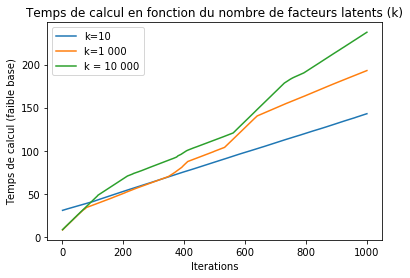

In [16]:
## Temps de calcul en fonction du nombre de facteurs latents (k) dans la faible base
 
l3 = [8.046968460083008, 8.431196928024292, 8.763111352920532, 9.109402656555176, 9.446686029434204, 9.77793550491333, 10.194197654724121, 10.532560110092163, 10.879488945007324, 11.210350036621094, 11.54801344871521, 11.910101413726807, 12.248919010162354, 12.579752683639526, 12.910592079162598, 13.248211145401001, 13.647640466690063, 13.978821516036987, 14.311136245727539, 14.648552179336548, 14.979838132858276, 15.34854006767273, 15.67985987663269, 16.01165223121643, 16.350517511367798, 16.682765245437622, 17.08315920829773, 17.417017698287964, 17.758445739746094, 18.0838303565979, 18.415643453598022, 18.78429675102234, 19.11611318588257, 19.454017877578735, 19.770195484161377, 20.11763596534729, 20.518062591552734, 20.856419563293457, 21.188725233078003, 21.520540475845337, 21.857478380203247, 22.220547437667847, 22.55892539024353, 22.89065170288086, 23.206934690475464, 23.560088872909546, 23.960127592086792, 24.291500329971313, 24.63958215713501, 24.959617137908936, 25.30633306503296, 25.67543649673462, 26.006624460220337, 26.342455863952637, 26.66071367263794, 27.007589101791382, 27.40836477279663, 27.745264768600464, 28.077120065689087, 28.407930612564087, 28.744825839996338, 29.007972240447998, 29.324648141860962, 29.66301727294922, 29.99384331703186, 30.341306447982788, 30.746278047561646, 30.992950916290283, 31.208714485168457, 31.40893840789795, 31.62424397468567, 31.861408472061157, 32.061606645584106, 32.34235119819641, 32.66162323951721, 32.99340558052063, 33.40893363952637, 33.74585938453674, 34.062023878097534, 34.19358253479004, 34.30950045585632, 34.447603702545166, 34.56352615356445, 34.67898488044739, 34.81055974960327, 34.94209098815918, 35.079731702804565, 35.21100044250488, 35.32661056518555, 35.46431016921997, 35.580294132232666, 35.727476358413696, 35.8487491607666, 35.98019886016846, 36.09611964225769, 36.22733449935913, 36.36451601982117, 36.4800591468811, 36.61161947250366, 36.74444556236267, 36.864545583724976, 36.99615478515625, 37.12715005874634, 37.248655557632446, 37.37989854812622, 37.49541878700256, 37.64818477630615, 37.76384449005127, 37.89504408836365, 38.01060724258423, 38.14791131019592, 38.27969431877136, 38.41094255447388, 38.52656078338623, 38.64847993850708, 38.78024935722351, 38.927019119262695, 39.04891324043274, 39.18024277687073, 39.295809745788574, 39.426953077316284, 39.564570903778076, 39.69617247581482, 39.82766318321228, 39.94961190223694, 40.06534147262573, 40.21211886405945, 40.34439826011658, 40.46545457839966, 40.581000328063965, 40.71250629425049, 40.85011696815491, 40.965739488601685, 41.11247229576111, 41.24867653846741, 41.38137125968933, 41.55016875267029, 41.697577714920044, 41.82892942428589, 41.96707463264465, 42.098708152770996, 42.267773151397705, 42.40370059013367, 42.53038740158081, 42.66814732551575, 42.79978394508362, 42.98411822319031, 43.115556716918945, 43.2531623840332, 43.38449668884277, 43.51583766937256, 43.6688289642334, 43.80000686645508, 43.93158841133118, 44.06933283805847, 44.2005672454834, 44.369096755981445, 44.50043487548828, 44.63172101974487, 44.76924133300781, 44.9006073474884, 45.05345940589905, 45.20073223114014, 45.33230900764465, 45.46998047828674, 45.601542711257935, 45.77034139633179, 45.90140914916992, 46.03282332420349, 46.1706018447876, 46.302168130874634, 46.45524311065674, 46.60247778892517, 46.73405146598816, 46.87167453765869, 47.00275945663452, 47.17135953903198, 47.302764654159546, 47.4184992313385, 47.55570673942566, 47.68730020523071, 47.834551095962524, 47.955899238586426, 48.103336334228516, 48.23460793495178, 48.372411251068115, 48.53501582145691, 48.67273163795471, 48.80398106575012, 48.93523335456848, 49.07313299179077, 49.21945071220398, 49.35754466056824, 49.4890558719635, 49.620582580566406, 49.75788855552673, 49.9206280708313, 50.05790448188782, 50.18953227996826, 50.32069253921509, 50.458796977996826, 50.60559344291687, 50.73676300048828, 50.874446868896484, 51.00579118728638, 51.13716173171997, 51.42169213294983, 51.560195446014404, 51.69138693809509, 51.82252645492554, 51.95988082885742, 52.09132361412048, 52.23808288574219, 52.37573218345642, 52.50700116157532, 52.638206005096436, 52.791330099105835, 52.93818426132202, 53.075833559036255, 53.207011461257935, 53.33824276924133, 53.47620153427124, 53.62301826477051, 53.75866675376892, 53.87651991844177, 54.00811219215393, 54.17708659172058, 54.324251651763916, 54.46239686012268, 54.59366774559021, 54.725231647491455, 54.862454652786255, 55.00960183143616, 55.14095664024353, 55.2788302898407, 55.41029095649719, 55.56324291229248, 55.72583293914795, 55.86331796646118, 55.99497199058533, 56.126397132873535, 56.26359987258911, 56.41091823577881, 56.541975259780884, 56.663968563079834, 56.78003525733948, 56.911365032196045, 57.04261255264282, 57.180535554885864, 57.296144008636475, 57.4272997379303, 57.55851221084595, 57.680684089660645, 57.81183314323425, 57.92776846885681, 58.064980030059814, 58.19640326499939, 58.32763123512268, 58.45877146720886, 58.58047866821289, 58.70132923126221, 58.82746720314026, 58.96520805358887, 59.09644865989685, 59.212013959884644, 59.34325861930847, 59.46581172943115, 59.597391843795776, 59.728618144989014, 59.85979413986206, 59.98188376426697, 60.09742879867554, 60.24432611465454, 60.36633062362671, 60.48261046409607, 60.6138858795166, 60.74545121192932, 60.883533239364624, 61.015013456344604, 61.13063287734985, 61.26783466339111, 61.38393521308899, 61.53058123588562, 61.66403293609619, 61.78409218788147, 61.89971160888672, 62.031269550323486, 62.1842565536499, 62.300172328948975, 62.43133354187012, 62.56350302696228, 62.68424153327942, 62.815808057785034, 62.94671177864075, 63.08418130874634, 63.19967317581177, 63.33086562156677, 63.483848571777344, 63.61502003669739, 63.73084592819214, 63.868226528167725, 63.984233379364014, 64.1154294013977, 64.24675059318542, 64.36896753311157, 64.50009274482727, 64.63129711151123, 64.76846837997437, 64.88419198989868, 65.01537656784058, 65.1465961933136, 65.26862716674805, 65.41594934463501, 65.53190231323242, 65.66917133331299, 65.78485202789307, 65.91618466377258, 66.06902074813843, 66.18460822105408, 66.31573343276978, 66.43604350090027, 66.56873512268066, 66.70043468475342, 66.83172035217285, 66.94720482826233, 67.08481216430664, 67.2003071308136, 67.34753346443176, 67.46937704086304, 67.60094928741455, 67.73209595680237, 67.84763836860657, 67.98537254333496, 68.11672496795654, 68.23229718208313, 68.3696391582489, 68.48526573181152, 68.63208436965942, 68.76384377479553, 68.88549304008484, 69.01706027984619, 69.13242769241333, 69.28546619415283, 69.41663885116577, 69.53259062767029, 69.66975045204163, 69.78578925132751, 69.93255233764648, 70.11759877204895, 70.3329222202301, 70.5482325553894, 70.77015042304993, 71.01636624336243, 71.23215794563293, 71.45260715484619, 71.66994667053223, 71.91706347465515, 72.16970205307007, 72.38505411148071, 72.61649966239929, 72.83229565620422, 73.04762387275696, 73.30079889297485, 73.5164704322815, 73.74789714813232, 73.96979784965515, 74.21698713302612, 74.46499395370483, 74.68686437606812, 74.90264964103699, 75.17187309265137, 75.4189145565033, 75.70418858528137, 75.95150661468506, 76.2055926322937, 76.44157981872559, 76.73752117156982, 77.00666046142578, 77.25397229194641, 77.50761079788208, 77.79271793365479, 78.14012742042542, 78.4244475364685, 78.64048504829407, 78.85644221305847, 79.07917618751526, 79.34159016609192, 79.57881593704224, 79.79463911056519, 80.02605819702148, 80.24214625358582, 80.57957768440247, 80.98046970367432, 81.32744431495667, 81.68004250526428, 82.02821969985962, 82.41325306892395, 82.78191924095154, 83.11373257637024, 83.46067094802856, 83.78240895271301, 84.113285779953, 84.48191213607788, 84.81275463104248, 85.15977144241333, 85.48105883598328, 85.85881972312927, 86.2431001663208, 86.57775783538818, 86.91179823875427, 87.22705745697021, 87.44285750389099, 87.59572172164917, 87.72732043266296, 87.85891723632812, 87.9961805343628, 88.14323663711548, 88.28079056739807, 88.41205930709839, 88.52760171890259, 88.65883445739746, 88.78092527389526, 88.91247344017029, 89.0436589717865, 89.15920615196228, 89.28126096725464, 89.42800641059875, 89.55871176719666, 89.68026995658875, 89.81173181533813, 89.92729043960571, 90.05879974365234, 90.22768998146057, 90.35881066322327, 90.49629974365234, 90.62788224220276, 90.7807207107544, 90.92789030075073, 91.0592839717865, 91.19706583023071, 91.3282458782196, 91.44869685173035, 91.59706807136536, 91.72865533828735, 91.86012768745422, 91.9974455833435, 92.1290340423584, 92.2822060585022, 92.4148998260498, 92.54507493972778, 92.67815685272217, 92.79851865768433, 92.94570899009705, 93.08382415771484, 93.21512508392334, 93.34627413749695, 93.48433899879456, 93.63129043579102, 93.76265573501587, 93.90027785301208, 94.03184509277344, 94.16295385360718, 94.31645154953003, 94.44778776168823, 94.5854012966156, 94.71714186668396, 94.86379933357239, 95.00128197669983, 95.13281726837158, 95.2487576007843, 95.38538765907288, 95.50193428993225, 95.66472172737122, 95.78669810295105, 95.91784691810608, 96.04900097846985, 96.20231342315674, 96.34945869445801, 96.46967267990112, 96.6028904914856, 96.73445224761963, 96.8656210899353, 97.00330066680908, 97.13483023643494, 97.26559376716614, 97.40322923660278, 97.53457736968994, 97.6873471736908, 97.81885695457458, 97.95006060600281, 98.085608959198, 98.20364427566528, 98.35043454170227, 98.4880256652832, 98.61999869346619, 98.75159025192261, 98.88873529434204, 99.12053632736206, 99.26729035377502, 99.389244556427, 99.52110648155212, 99.65746307373047, 99.78992438316345, 99.93742299079895, 100.06890845298767, 100.20633220672607, 100.3531813621521, 100.49061846733093, 100.6223533153534, 100.76923990249634, 100.89115309715271, 101.02247381210327, 101.15401005744934, 101.30691146850586, 101.4429452419281, 101.56964683532715, 101.72282338142395, 101.853933095932, 101.99106645584106, 102.13827109336853, 102.2693681716919, 102.3908634185791, 102.52262830734253, 102.66962265968323, 102.80709671974182, 102.93819236755371, 103.06933093070984, 103.20704174041748, 103.35395693778992, 103.48615908622742, 103.60762023925781, 103.72323536872864, 103.88819456100464, 104.23963975906372, 104.57151961326599, 104.89422702789307, 105.27286648750305, 105.59586834907532, 105.95886182785034, 106.29712963104248, 106.62868571281433, 106.9448139667511, 107.27660036087036, 107.64639973640442, 107.97828340530396, 108.30138993263245, 108.66480946540833, 109.0028326511383, 109.36631274223328, 109.70363783836365, 110.0200743675232, 110.35182118415833, 110.6836040019989, 111.0380506515503, 111.38516783714294, 111.70796036720276, 112.07048797607422, 112.40828323364258, 112.77210092544556, 113.11074948310852, 113.42730832099915, 113.75950121879578, 114.09173321723938, 114.44576239585876, 114.79328775405884, 115.11597514152527, 115.47953653335571, 115.81825113296509, 116.1813485622406, 116.51967763900757, 116.85127544403076, 117.16780710220337, 117.51503920555115, 117.86878871917725, 118.21830582618713, 118.53873777389526, 118.90212225914001, 119.24081206321716, 119.60415077209473, 119.94254779815674, 120.27429223060608, 120.59079265594482, 120.92851161956787, 121.29202055931091, 121.63068985939026, 121.9622905254364, 122.33153986930847, 122.66350603103638, 123.03302145004272, 123.36524653434753, 123.69747686386108, 124.01398801803589, 124.35187482833862, 124.71478652954102, 125.05171203613281, 125.38335490226746, 125.75212454795837, 126.09997725486755, 126.46879887580872, 126.81582164764404, 127.13764524459839, 127.46980500221252, 127.80187034606934, 128.17126154899597, 128.50330424308777, 128.8420171737671, 129.20543003082275, 129.54424023628235, 129.9074683189392, 130.24594831466675, 130.5776765346527, 130.89415645599365, 131.22591471672058, 131.59559035301208, 131.9271640777588, 132.24938893318176, 132.61227917671204, 132.95099425315857, 133.3140161037445, 133.65204215049744, 133.96870493888855, 134.30044102668762, 134.63224864006042, 135.00131726264954, 135.33326196670532, 135.6719868183136, 136.0346212387085, 136.37286686897278, 136.73574495315552, 137.05834436416626, 137.3898742198944, 137.70640444755554, 138.0382809638977, 138.4072241783142, 138.73917412757874, 139.0616910457611, 139.42498421669006, 139.76318383216858, 140.12662935256958, 140.34283232688904, 140.49618363380432, 140.6333451271057, 140.78083848953247, 140.96351647377014, 141.11274337768555, 141.2622618675232, 141.41346764564514, 141.5667953491211, 141.74474024772644, 141.89762163162231, 142.04440569877625, 142.18193435668945, 142.34471440315247, 142.49798464775085, 142.66380429267883, 142.79820609092712, 142.96716022491455, 143.11400055885315, 143.2829008102417, 143.43009066581726, 143.5834321975708, 143.73029279708862, 143.88392663002014, 144.04676580429077, 144.1997332572937, 144.34692406654358, 144.51626467704773, 144.66919684410095, 144.8321352005005, 144.9853949546814, 145.1322135925293, 145.26935529708862, 145.43230032920837, 145.6008584499359, 145.74855756759644, 145.88660621643066, 146.0489902496338, 146.20199608802795, 146.37135124206543, 146.51773190498352, 146.6705560684204, 146.81785893440247, 146.97077012062073, 147.13361930847168, 147.28726243972778, 147.43414878845215, 147.58744287490845, 147.73420906066895, 147.90288543701172, 148.06917691230774, 148.20328831672668, 148.35020995140076, 148.50365900993347, 148.6727750301361, 148.8195743560791, 148.97298955917358, 149.13565182685852, 149.28868794441223, 149.45147728919983, 149.58954977989197, 149.73613262176514, 149.87412858009338, 150.0212962627411, 150.18984293937683, 150.3523211479187, 150.49003291130066, 150.6523313522339, 150.8060462474823, 150.97479152679443, 151.1221902370453, 151.2746365070343, 151.42210793495178, 151.57487082481384, 151.75349593162537, 151.90648221969604, 152.05366826057434, 152.20714330673218, 152.35396361351013, 152.50710010528564, 152.63866305351257, 152.77580189704895, 152.9234583377838, 153.05499124526978, 153.20814490318298, 153.35536360740662, 153.49329543113708, 153.64011764526367, 153.77734446525574, 153.92441296577454, 154.07728934288025, 154.20872473716736, 154.33989024162292, 154.4929575920105, 154.6398856639862, 154.77713561058044, 154.90850377082825, 155.05520629882812, 155.2084937095642, 155.35530710220337, 155.49270033836365, 155.6239836215973, 155.77333617210388, 155.9082169532776, 156.0551335811615, 156.1924147605896, 156.3393485546112, 156.47716426849365, 156.6243839263916, 156.77796983718872, 156.90944170951843, 157.056631565094, 157.1946783065796, 157.3416087627411, 157.4791932106018, 157.62617826461792, 157.77494287490845, 157.91151523590088, 158.05840063095093, 158.21167039871216, 158.3588891029358, 158.49678015708923, 158.6283996105194, 158.7787003517151, 158.9280276298523, 159.05915212631226, 159.19708156585693, 159.3599009513855, 159.4973201751709, 159.64448261260986, 159.79780077934265, 159.92904806137085, 160.06027102470398, 160.21396446228027, 160.3607850074768, 160.49841141700745, 160.64534544944763, 160.78317523002625, 160.93002939224243, 161.08306193351746, 161.2300488948822, 161.3611786365509, 161.4987452030182, 161.6459937095642, 161.79915237426758, 161.93036246299744, 162.08135056495667, 162.21509075164795, 162.36230969429016, 162.51561760902405, 162.6624002456665, 162.7997691631317, 162.93111515045166, 163.08342695236206, 163.2309753894806, 163.3621323108673, 163.4998335838318, 163.64633703231812, 163.87796783447266, 164.00030612945557, 164.1474392414093, 164.30038261413574, 164.4316017627716, 164.58457446098328, 164.71652126312256, 164.86299657821655, 165.00067901611328, 165.1479251384735, 165.28560638427734, 165.43278551101685, 165.5684037208557, 165.71727895736694, 165.84887051582336, 166.00180506706238, 166.13336634635925, 166.2649073600769, 166.41770029067993, 166.5645296573639, 166.71741724014282, 166.8489818572998, 166.98642754554749, 167.13327193260193, 167.28620505332947, 167.41918659210205, 167.54929566383362, 167.70267868041992, 167.8494040966034, 168.00317549705505, 168.14987206459045, 168.2875201702118, 168.41925692558289, 168.56642293930054, 168.719792842865, 168.8512613773346, 168.98899865150452, 169.13592553138733, 169.2891972064972, 169.4361560344696, 169.58791136741638, 169.72101712226868, 169.86736130714417, 170.03635263442993, 170.18911790847778, 170.35188150405884, 170.48955035209656, 170.65239691734314, 170.8213357925415, 170.9901692867279, 171.13702750205994, 171.2898027896881, 171.44129824638367, 171.60547375679016, 171.75234293937683, 171.88946413993835, 172.02089548110962, 172.16788816452026, 172.32096004486084, 172.46767616271973, 172.60523414611816, 172.75194931030273, 172.9050805568695, 173.0676474571228, 173.22061705589294, 173.36755990982056, 173.5206847190857, 173.66737532615662, 173.83620953559875, 174.00486040115356, 174.15170979499817, 174.3048484325409, 174.45166516304016, 174.62034678459167, 174.76723384857178, 174.9202983379364, 175.06707406044006, 175.22022986412048, 175.38876008987427, 175.5514509677887, 175.68867421150208, 175.82004642486572, 175.96687364578247, 176.11998915672302, 176.2511444091797, 176.3885214328766, 176.51990008354187, 176.6667456626892, 176.81986498832703, 176.96659088134766, 177.10414814949036, 177.23529648780823, 177.38365602493286, 177.51966500282288, 177.66652393341064, 177.80399298667908, 177.9351770877838, 178.088041305542, 178.23503708839417, 178.3870460987091, 178.51944994926453, 178.666246175766, 178.8193621635437, 178.96619033813477, 179.10350441932678, 179.25043606758118, 179.38777089118958, 179.53476095199585, 179.68619441986084, 179.8189878463745, 179.96594834327698, 180.10341095924377, 180.25027585029602, 180.38750672340393, 180.5345516204834, 180.66581797599792, 180.80321884155273, 180.95007252693176, 181.08731126785278, 181.23435711860657, 181.38725900650024, 181.5186836719513, 181.6659791469574, 181.80376267433167, 181.9505729675293, 182.08768224716187, 182.2197070121765, 182.36687779426575, 182.51979184150696, 182.66663098335266, 182.8043200969696, 182.95055603981018, 183.08794784545898, 183.23550248146057, 183.36657738685608, 183.51984310150146, 183.65138006210327, 183.78843712806702, 183.93590593338013, 184.0886733531952, 184.22037935256958, 184.36714553833008, 184.50475692749023, 184.65174508094788, 184.78951907157898, 184.93646097183228, 185.06773114204407, 185.20521545410156, 185.3524055480957, 185.50571060180664, 185.63678646087646, 185.78674697875977, 185.92167901992798, 186.06861233711243, 186.20671200752258, 186.3533947467804, 186.48905754089355, 186.62239360809326, 186.76961636543274, 186.92249250411987, 187.0532021522522, 187.19037103652954, 187.32222318649292, 187.4870240688324, 187.62235593795776, 187.75358271598816, 187.89170289039612, 188.03800892829895, 188.19176268577576, 188.33864831924438, 188.46991610527039, 188.6072359085083, 188.75442743301392, 188.9072892665863, 189.03843784332275, 189.16975116729736, 189.3076891899109, 189.45488047599792, 189.5924355983734, 189.73934745788574, 189.89215087890625, 190.02363419532776, 190.1551811695099, 190.30830311775208, 190.4398992061615, 190.5923936367035, 190.7238073348999, 190.8553810119629, 191.00826334953308, 191.15530705451965, 191.2929253578186, 191.42493987083435, 191.57172536849976, 191.72517085075378, 191.8563129901886, 191.99410438537598, 192.14108562469482, 192.27232813835144, 192.42703890800476, 192.57278680801392, 192.7099175453186, 192.84107899665833, 192.9939022064209]
l4 = [8.31306004524231, 8.678943872451782, 9.030767440795898, 9.362943649291992, 9.701188325881958, 10.033099889755249, 10.449357748031616, 10.80335259437561, 11.135560274124146, 11.467747688293457, 11.806362628936768, 12.169384479522705, 12.507614374160767, 12.839351892471313, 13.171255826950073, 13.51002812385559, 13.92606258392334, 14.257852554321289, 14.595927953720093, 14.912277460098267, 15.244318723678589, 15.613857507705688, 15.961276531219482, 16.297280073165894, 16.615029335021973, 16.96288824081421, 17.363729238510132, 17.716829776763916, 18.04793953895569, 18.36367177963257, 18.70191192626953, 19.08053970336914, 19.419105291366577, 19.735682249069214, 20.067826509475708, 20.406169652938843, 20.82286834716797, 21.154281854629517, 21.48626732826233, 21.809175491333008, 22.141002893447876, 22.510377407073975, 22.842579126358032, 23.17444372177124, 23.50856852531433, 23.844426155090332, 24.244621992111206, 24.591994762420654, 24.91509175300598, 25.231144189834595, 25.578840732574463, 25.932299613952637, 26.279394149780273, 26.60084342956543, 26.91762924194336, 27.265718698501587, 27.666466236114502, 28.014594316482544, 28.33651328086853, 28.667771100997925, 29.00003671646118, 29.36958146095276, 29.701453924179077, 30.024139404296875, 30.35591197013855, 30.703240156173706, 31.10392165184021, 31.441530466079712, 31.77302622795105, 32.10443377494812, 32.442143201828, 32.67351698875427, 32.97433519363403, 33.290427923202515, 33.62732744216919, 33.960675954818726, 34.36100959777832, 34.69308304786682, 35.030869007110596, 35.34775948524475, 35.69551205635071, 36.04975366592407, 36.397406578063965, 36.71399998664856, 37.037137031555176, 37.384939432144165, 37.78613519668579, 38.12345004081726, 38.45581388473511, 38.772419691085815, 39.11949348449707, 39.48888373374939, 39.820948362350464, 40.143675088882446, 40.47559905052185, 40.80744910240173, 41.208160638809204, 41.54617786407471, 41.87798810005188, 42.21014475822449, 42.54874873161316, 42.91173219680786, 43.25041961669922, 43.58226919174194, 43.914440393447876, 44.25201082229614, 44.65331792831421, 44.98558974266052, 45.31736350059509, 45.651336431503296, 45.98790526390076, 46.35547494888306, 46.689318895339966, 47.020856857299805, 47.33746004104614, 47.69172930717468, 48.26037001609802, 48.492233991622925, 48.70828628540039, 48.92411780357361, 49.156172037124634, 49.377002239227295, 49.624316453933716, 49.839545011520386, 50.0615668296814, 50.277496576309204, 50.52463436126709, 50.7777304649353, 50.99390268325806, 51.21013283729553, 51.44203591346741, 51.66380429267883, 51.9110381603241, 52.12681245803833, 52.343040227890015, 52.56528854370117, 52.81271743774414, 53.065940856933594, 53.29771947860718, 53.51372003555298, 53.72994685173035, 53.964709997177124, 54.214338541030884, 54.43037247657776, 54.64619064331055, 54.86894774436951, 55.13171744346619, 55.3845009803772, 55.600189208984375, 55.8165328502655, 56.04789686203003, 56.27021622657776, 56.51770281791687, 56.733890533447266, 56.94966173171997, 57.187325954437256, 57.43443512916565, 57.687429428100586, 57.903791427612305, 58.13517093658447, 58.35116696357727, 58.57323098182678, 58.8362455368042, 59.07410764694214, 59.305580139160156, 59.53750133514404, 59.79067087173462, 60.022239208221436, 60.27035427093506, 60.491660356521606, 60.707648277282715, 60.939212799072266, 61.19272565841675, 61.424052715301514, 61.639679193496704, 61.87504982948303, 62.125004053115845, 62.3784601688385, 62.59423565864563, 62.82599091529846, 63.04192519187927, 63.27959966659546, 63.54274368286133, 63.7760443687439, 63.95913362503052, 64.12825036048889, 64.39723825454712, 64.66034841537476, 64.8822431564331, 65.09837675094604, 65.33025360107422, 65.56211185455322, 65.81534719467163, 66.03111743927002, 66.24706315994263, 66.48429226875305, 66.74729132652283, 67.00087714195251, 67.23191452026367, 67.44814586639404, 67.68224620819092, 67.90133547782898, 68.1643123626709, 68.38670349121094, 68.61822175979614, 68.84951591491699, 69.10308074951172, 69.36587142944336, 69.58828663825989, 69.80448293685913, 70.03644156455994, 70.25233602523804, 70.46812057495117, 70.60535097122192, 70.736887216568, 70.86798143386841, 71.02100539207458, 71.16816687583923, 71.30586314201355, 71.4217734336853, 71.5573980808258, 71.69000673294067, 71.85265803337097, 71.98849534988403, 72.12203884124756, 72.25328540802002, 72.40613055229187, 72.56891965866089, 72.70684695243835, 72.8380675315857, 72.96934199333191, 73.10704493522644, 73.42284798622131, 73.55438423156738, 73.69244146347046, 73.83929777145386, 73.97062945365906, 74.10779809951782, 74.20763444900513, 74.3233253955841, 74.45466685295105, 74.5702075958252, 74.69176435470581, 74.80773067474365, 74.93926763534546, 75.05475521087646, 75.19198608398438, 75.32335495948792, 75.42334389686584, 75.53877687454224, 75.65479254722595, 75.77024245262146, 75.89177417755127, 75.99230098724365, 76.12372851371765, 76.23965644836426, 76.392422914505, 76.54403281211853, 76.67083048820496, 76.80864691734314, 76.9402105808258, 77.07090091705322, 77.2242329120636, 77.35544538497925, 77.48865222930908, 77.60871934890747, 77.75585842132568, 77.90896677970886, 78.05615615844727, 78.18924856185913, 78.30985617637634, 78.4566650390625, 78.60990500450134, 78.74136590957642, 78.87281227111816, 79.01068758964539, 79.15747308731079, 79.31038880348206, 79.45730376243591, 79.58937430381775, 79.71092367172241, 79.84233689308167, 79.99529004096985, 80.14243388175964, 80.27397346496582, 80.39552807807922, 80.55857825279236, 80.6958417892456, 80.84303379058838, 80.97445964813232, 81.11244678497314, 81.2435839176178, 81.39542412757874, 81.51245713233948, 81.6435534954071, 81.77512431144714, 81.92860054969788, 82.0755455493927, 82.21281886100769, 82.34436702728271, 82.47549319267273, 82.61334753036499, 82.76054191589355, 82.89790225028992, 83.02911019325256, 83.16064429283142, 83.29829955101013, 83.46069741249084, 83.59800314903259, 83.72983932495117, 83.84577703475952, 83.97686076164246, 84.11411356925964, 84.2455883026123, 84.37673425674438, 84.49838185310364, 84.64576554298401, 84.79899525642395, 84.93036341667175, 85.04586124420166, 85.17698073387146, 85.31483745574951, 85.46199560165405, 85.59567713737488, 85.71531128883362, 85.84689664840698, 86.00022864341736, 86.14739274978638, 86.27872490882874, 86.40035057067871, 86.5365719795227, 86.65823936462402, 86.79961657524109, 86.92713761329651, 87.04350447654724, 87.17503952980042, 87.32812190055847, 87.47535061836243, 87.59577822685242, 87.72932887077332, 87.8602249622345, 88.00712490081787, 88.14489436149597, 88.27645969390869, 88.41394233703613, 88.54562592506409, 88.69234681129456, 88.8455274105072, 88.97651624679565, 89.092449426651, 89.2293632030487, 89.36071467399597, 89.51356244087219, 89.62927484512329, 89.76038861274719, 89.89180731773376, 90.04498100280762, 90.19170308113098, 90.30734586715698, 90.41358280181885, 90.54558420181274, 90.67714667320251, 90.81426906585693, 90.94570827484131, 91.07703900337219, 91.21453642845154, 91.36181139945984, 91.51497673988342, 91.64657258987427, 91.77813935279846, 91.91547513008118, 92.04699802398682, 92.1942069530487, 92.36291885375977, 92.57885909080505, 92.7949788570404, 93.11761569976807, 93.46479773521423, 93.7964563369751, 94.06561017036438, 94.2653706073761, 94.46593832969666, 94.6348705291748, 94.78206992149353, 94.92015647888184, 95.06691193580627, 95.23540019989014, 95.41347694396973, 95.55130195617676, 95.78308010101318, 96.02024459838867, 96.23611354827881, 96.49853324890137, 96.73624515533447, 96.93689489364624, 97.15261650085449, 97.50026750564575, 97.80057692527771, 98.0011796951294, 98.2013292312622, 98.4013283252716, 98.60161900520325, 98.80221843719482, 98.98649716377258, 99.20240616798401, 99.4251561164856, 99.67169046401978, 99.92542576789856, 100.10423469543457, 100.24199533462524, 100.4045262336731, 100.54194593429565, 100.70525693893433, 100.85817456245422, 101.00498461723328, 101.14235997200012, 101.30484914779663, 101.54256701469421, 101.68922686576843, 101.826406955719, 101.94257664680481, 102.07371997833252, 102.1891222000122, 102.32669138908386, 102.45820140838623, 102.5893452167511, 102.72595429420471, 102.84214091300964, 102.97329115867615, 103.10474228858948, 103.22636103630066, 103.34225559234619, 103.47353291511536, 103.60512161254883, 103.72620391845703, 103.85758233070374, 103.9887535572052, 104.10434126853943, 104.24165749549866, 104.37290835380554, 104.48888778686523, 104.62560772895813, 104.75709104537964, 104.92191648483276, 105.05757427215576, 105.18874740600586, 105.32584023475647, 105.45761704444885, 105.60418605804443, 105.7266788482666, 105.84264874458313, 105.97360157966614, 106.10489320755005, 106.24225330352783, 106.37344098091125, 106.48942804336548, 106.6272611618042, 106.75838327407837, 106.90556621551514, 107.02692532539368, 107.14265084266663, 107.27431201934814, 107.39017844200134, 107.52737784385681, 107.6586012840271, 107.78980755805969, 107.92093753814697, 108.04263854026794, 108.1741852760315, 108.30508422851562, 108.42675495147705, 108.54282593727112, 108.68975853919983, 108.84305834770203, 108.9587082862854, 109.08987498283386, 109.22706818580627, 109.35833024978638, 109.48964548110962, 109.6052553653717, 109.74302625656128, 109.85851502418518, 109.99007105827332, 110.1226372718811, 110.24386429786682, 110.37498545646667, 110.52484273910522, 110.64468812942505, 110.79188084602356, 110.9294285774231, 111.0456931591034, 111.17725539207458, 111.30835175514221, 111.46166157722473, 111.59284234046936, 111.72564840316772, 111.86148357391357, 111.99278616905212, 112.1300265789032, 112.26139116287231, 112.39295029640198, 112.53006148338318, 112.6617271900177, 112.79326272010803, 112.93064594268799, 113.0618679523468, 113.20865082740784, 113.34628748893738, 113.4932496547699, 113.60874843597412, 113.74613118171692, 113.87799525260925, 114.0091667175293, 114.1463885307312, 114.2774932384491, 114.40859150886536, 114.56190013885498, 114.69315385818481, 114.84622430801392, 114.97785449028015, 115.10938811302185, 115.24713468551636, 115.37870192527771, 115.53040933609009, 115.64748239517212, 115.77866220474243, 115.93240904808044, 116.06398105621338, 116.2287540435791, 116.34892416000366, 116.48009729385376, 116.61138916015625, 116.74911665916443, 116.89620685577393, 117.03003859519958, 117.15002846717834, 117.31226062774658, 117.45000529289246, 117.59719467163086, 117.73230481147766, 117.85035467147827, 117.98190069198608, 118.11305952072144, 118.26671743392944, 118.39750480651855, 118.53264164924622, 118.66646814346313, 118.79763603210449, 118.95055532455444, 119.08211874961853, 119.21342015266418, 119.33500576019287, 119.4664671421051, 119.61413049697876, 119.7515640258789, 119.88278484344482, 120.0362777709961, 120.16744875907898, 120.31433296203613, 120.4522750377655, 120.58367681503296, 120.90026664733887, 121.25454640388489, 121.61754179000854, 121.9406590461731, 122.28846502304077, 122.65830588340759, 122.99052238464355, 123.36041975021362, 123.69245266914368, 124.04639482498169, 124.37860870361328, 124.72641444206238, 125.095956325531, 125.44932627677917, 125.78142642974854, 126.15142273902893, 126.49928069114685, 126.86904311180115, 127.20075392723083, 127.53292632102966, 127.85606646537781, 128.1882040500641, 128.55812454223633, 128.890376329422, 129.2218780517578, 129.59142637252808, 129.92357420921326, 130.29355430603027, 130.6256983280182, 130.9639892578125, 131.28055143356323, 131.62830758094788, 131.98256874084473, 132.31468057632446, 132.6468517780304, 133.0169141292572, 133.36626648902893, 133.71912240982056, 134.0512809753418, 134.38956022262573, 134.7215633392334, 135.05341362953186, 135.42301964759827, 135.75468635559082, 136.09340643882751, 136.45643305778503, 136.79495406150818, 137.17390394210815, 137.49705529212952, 137.82864809036255, 138.16082549095154, 138.49901795387268, 138.86200380325317, 139.20073747634888, 139.53281784057617, 139.90265727043152, 140.2504119873047, 140.61987781524658, 140.95146107673645, 141.2897243499756, 141.6219024658203, 141.95365643501282, 142.3226752281189, 142.66961932182312, 143.00782418251038, 143.37083315849304, 143.70952010154724, 144.08816123008728, 144.41073393821716, 144.75849843025208, 145.07504749298096, 145.41339492797852, 145.79499983787537, 146.11553764343262, 146.46324634552002, 146.8325867652893, 147.1648030281067, 147.5343050956726, 147.86645340919495, 148.20467114448547, 148.5369255542755, 148.88476419448853, 149.2539131641388, 149.58601593971252, 149.9243004322052, 150.2873661518097, 150.6405384540558, 151.00999855995178, 151.34222030639648, 151.67410039901733, 151.99068021774292, 152.32914853096008, 152.71168613433838, 153.03056645393372, 153.33138751983643, 153.69484615325928, 154.03358578681946, 154.39654755592346, 154.73479533195496, 155.0669436454773, 155.38353323936462, 155.72221612930298, 156.1008801460266, 156.42403411865234, 156.7561013698578, 157.1260688304901, 157.4734480381012, 157.8427734375, 158.17501544952393, 158.50679349899292, 158.8297905921936, 159.1774935722351, 159.547376871109, 159.87911915779114, 160.21132588386536, 160.58113980293274, 160.91882705688477, 161.28320932388306, 161.61434507369995, 161.95275807380676, 162.28496408462524, 162.61963963508606, 162.9866406917572, 163.31832361221313, 163.65625548362732, 164.04174494743347, 164.37389039993286, 164.7438018321991, 165.0755033493042, 165.40768694877625, 165.7398705482483, 166.07864141464233, 166.44588136672974, 166.76505422592163, 167.0969944000244, 167.4665687084198, 167.81431913375854, 168.1842713356018, 168.5164499282837, 168.85419583320618, 169.17028999328613, 169.51807284355164, 169.87243509292603, 170.20415353775024, 170.53635716438293, 170.90608477592468, 171.25394773483276, 171.60833883285522, 171.94004321098328, 172.27830052375793, 172.61004400253296, 172.9413547515869, 173.31065583229065, 173.64272737503052, 173.98135709762573, 174.34473371505737, 174.6983323097229, 175.06786561012268, 175.40048575401306, 175.73211550712585, 176.07035875320435, 176.40163564682007, 176.7713553905487, 177.1192021369934, 177.4509003162384, 177.82039999961853, 178.25243592262268, 178.47520232200623, 178.69144678115845, 178.9389386177063, 179.15467524528503, 179.37702679634094, 179.60873866081238, 179.8249442577362, 180.07783579826355, 180.31073784828186, 180.54259634017944, 180.7588188648224, 180.9814202785492, 181.2288625240326, 181.44505834579468, 181.67814755439758, 181.88273978233337, 182.09935665130615, 182.34681224822998, 182.60033535957336, 182.8321681022644, 183.0479576587677, 183.2636947631836, 183.50186944007874, 183.73363494873047, 183.94941878318787, 184.08149409294128, 184.23379945755005, 184.4184546470642, 184.60340857505798, 184.76612734794617, 184.91975355148315, 185.08828330039978, 185.26687908172607, 185.42019486427307, 185.5891842842102, 185.73647665977478, 185.8896780014038, 186.05251812934875, 186.22183322906494, 186.36903357505798, 186.52666068077087, 186.66916370391846, 186.8533456325531, 186.99045491218567, 187.1529381275177, 187.30581283569336, 187.45303511619568, 187.6215114593506, 187.78984713554382, 187.93791484832764, 188.09072732925415, 188.23797702789307, 188.40682744979858, 188.55382871627808, 188.70758533477783, 188.85462141036987, 189.00762224197388, 189.17015528678894, 189.3391354084015, 189.49237656593323, 189.63975262641907, 189.79252195358276, 189.9554762840271, 190.10884022712708, 190.30904364585876, 190.52504086494446, 190.7560796737671, 190.994234085083, 191.24109625816345, 191.4722273349762, 191.694842338562, 191.91065573692322, 192.1582067012787, 192.37337803840637, 192.5948359966278, 192.8106071949005, 193.02690291404724, 193.2736918926239, 193.5268518924713, 193.75845074653625, 193.9738130569458, 194.1948471069336, 194.4279932975769, 194.65909123420715, 194.87517476081848, 195.09698748588562, 195.3136396408081, 195.56115245819092, 195.81486916542053, 196.03024673461914, 196.24610114097595, 196.46176862716675, 196.71511483192444, 196.93101048469543, 197.1472418308258, 197.3632574081421, 197.57936668395996, 197.83259868621826, 198.07953763008118, 198.30139565467834, 198.51805663108826, 198.73359394073486, 198.9804036617279, 199.2032196521759, 199.41951656341553, 199.6353542804718, 199.86696219444275, 200.10443258285522, 200.36772751808167, 200.5837106704712, 200.8060245513916, 201.0223467350006, 201.26869106292725, 201.4846329689026, 201.70705842971802, 201.92303609848022, 202.13902735710144, 202.40163564682007, 202.63948702812195, 202.8710961341858, 203.08723974227905, 203.30945706367493, 203.54163146018982, 203.77328252792358, 203.98901295661926, 204.21082878112793, 204.42705631256104, 204.67406725883484, 204.9115662574768, 205.1425576210022, 205.35863089561462, 205.5748267173767, 205.82806372642517, 206.0440034866333, 206.26026225090027, 206.47652745246887, 206.6920449733734, 206.94578766822815, 207.19270420074463, 207.41474604606628, 207.63066744804382, 207.86217164993286, 208.11543583869934, 208.331476688385, 208.56305408477783, 208.779052734375, 209.01708245277405, 209.26374530792236, 209.5173144340515, 209.7488923072815, 209.9648494720459, 210.1808145046234, 210.43424153327942, 210.65021347999573, 210.86647081375122, 211.0821681022644, 211.29804253578186, 211.55627250671387, 211.79872918128967, 212.02067828178406, 212.2371289730072, 212.4529755115509, 212.69987964630127, 212.92210364341736, 213.13833355903625, 213.35452723503113, 213.57011795043945, 213.77014541625977, 214.02421760559082, 214.23967385292053, 214.47116136550903, 214.6870081424713, 214.92464637756348, 215.1564064025879, 215.3724229335785, 215.5882351398468, 215.8041877746582, 216.05735301971436, 216.3045117855072, 216.52685070037842, 216.74265146255493, 216.95763444900513, 217.2051510810852, 217.4269733428955, 217.6430447101593, 217.85883903503418, 218.07482886314392, 218.32850217819214, 218.57553625106812, 218.8069303035736, 219.0073480606079, 219.22960805892944, 219.47707176208496, 219.6932818889618, 219.9293532371521, 220.13136386871338, 220.34797716140747, 220.5952229499817, 220.84876012802124, 221.06483364105225, 221.29596972465515, 221.51223158836365, 221.74927592277527, 221.9807426929474, 222.19700264930725, 222.41234183311462, 222.6350395679474, 222.88208842277527, 223.1356372833252, 223.35146236419678, 223.5671260356903, 223.7827775478363, 224.03593826293945, 224.25174069404602, 224.48283648490906, 224.6990683078766, 224.91406869888306, 225.16714692115784, 225.41432547569275, 225.63680219650269, 225.85240197181702, 226.06839537620544, 226.31566977500916, 226.53761744499207, 226.75399518013, 226.96978044509888, 227.1855697631836, 227.43839740753174, 227.68599009513855, 227.91789078712463, 228.13616466522217, 228.35623288154602, 228.60347890853882, 228.81970381736755, 229.04215002059937, 229.25843214988708, 229.47432661056519, 229.7209815979004, 229.97404599189758, 230.19016432762146, 230.4060480594635, 230.62212896347046, 230.8756444454193, 231.0912766456604, 231.32309293746948, 231.54382133483887, 231.76152443885803, 232.0085391998291, 232.24669766426086, 232.47778606414795, 232.6935794353485, 232.90979719161987, 233.1628131866455, 233.37880778312683, 233.59493494033813, 233.81062245368958, 234.044527053833, 234.28045892715454, 234.52764320373535, 234.75005412101746, 234.9657804965973, 235.19695401191711, 235.44720911979675, 235.66561794281006, 235.8811936378479, 236.09656834602356, 236.3125057220459, 236.5657160282135, 236.81255292892456, 237.0461368560791, 237.25031304359436, 237.46641778945923]

plt.plot(list_iter, l2, label='k=10')
plt.plot(list_iter, l3, label='k=1 000')
plt.plot(list_iter, l4, label ='k = 10 000')
plt.legend( loc='upper left', numpoints = 1 )
plt.xlabel('Iterations')
plt.ylabel('Temps de calcul (faible base)')
plt.title('Temps de calcul en fonction du nombre de facteurs latents (k)')
plt.show()